In [1]:
magnification_factor = ''
trainable_blocks = []
irun = 0

In [2]:
# Parameters
magnification_factor = "200X"
trainable_blocks = ["block1", "block2", "block3", "block4"]
irun = 5


In [3]:
irun = str(irun)

In [4]:
name = 'FINETUNING_'+ magnification_factor +'-BREAKHIS-Dataset-60-10-30-VGGINet'

path = './VGGINET-FT/%s/%s' % (name, irun)
!mkdir -p {path}

path

'./VGGINET-FT/FINETUNING_200X-BREAKHIS-Dataset-60-10-30-VGGINet/5'

In [5]:
tb_path = './tensorboard/' + magnification_factor + '/' + irun
tb_path

'./tensorboard/200X/5'

# Training

In [6]:
import tensorflow as tf
tf.version.VERSION, tf.config.list_physical_devices()

('2.3.0-rc1',
 [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
  PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
  PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'),
  PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')])

In [7]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model
base_model = VGG16(include_top=False, input_shape=(224, 224, 3))
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [8]:
layer_name = 'block4_pool'
feature_ex_model = Model(inputs=base_model.input, outputs=base_model.get_layer(layer_name).output, name='vgg16_features')
feature_ex_model.trainable = False
feature_ex_model.summary()

Model: "vgg16_features"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)    

In [9]:
from tensorflow.keras.layers import Lambda, Input
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess

p1_layer = Lambda(vgg_preprocess, name='VGG_Preprocess')

image_input = Input((224, 224, 3), name='Image_Input')
p1_tensor = p1_layer(image_input)

out =feature_ex_model(p1_tensor)
feature_ex_model = Model(inputs=image_input, outputs=out)

In [10]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Concatenate,BatchNormalization,Activation 

def naive_inception_module(layer_in, f1, f2, f3):
    # 1x1 conv
    conv1 = Conv2D(f1, (1,1), padding='same', activation='relu')(layer_in)
    # 3x3 conv
    conv3 = Conv2D(f2, (3,3), padding='same', activation='relu')(layer_in)
    # 5x5 conv
    conv5 = Conv2D(f3, (5,5), padding='same', activation='relu')(layer_in)
    # 3x3 max pooling
    pool = MaxPooling2D((3,3), strides=(1,1), padding='same')(layer_in)
    # concatenate filters, assumes filters/channels last
    layer_out = Concatenate()([conv1, conv3, conv5, pool])
    return layer_out

In [11]:
out = naive_inception_module(feature_ex_model.output, 64, 128, 32)

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dropout, GlobalAveragePooling2D, Dropout, Dense, BatchNormalization, Flatten
num_classes = 2

bn1 = BatchNormalization(name='BN')(out)
f = Flatten()(bn1)
dropout = Dropout(0.4, name='Dropout')(f)
desne = Dense(num_classes, activation='softmax', name='Predictions')(dropout)

In [13]:
new_model = Model(inputs=feature_ex_model.input, outputs=desne)
new_model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Image_Input (InputLayer)        [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
VGG_Preprocess (Lambda)         (None, 224, 224, 3)  0           Image_Input[0][0]                
__________________________________________________________________________________________________
vgg16_features (Functional)     (None, 14, 14, 512)  7635264     VGG_Preprocess[0][0]             
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 14, 64)   32832       vgg16_features[0][0]             
_______________________________________________________________________________________

In [14]:
from tensorflow import keras
opt = keras.optimizers.Adam(lr=0.001)

In [15]:
new_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [16]:
from tensorflow.keras.callbacks import ModelCheckpoint
callbacks = [
    # ModelCheckpoint(monitor='val_accuracy',filepath="./model-weights.{epoch:02d}-{val_accuracy:.6f}.hdf5", verbose=1, save_best_only=True)
]

In [17]:
from tensorflow.keras.callbacks import TensorBoard
callbacks += [TensorBoard(tb_path)]

In [18]:
import tensorflow as tf

image_size = (224, 340)
crop_size = (224, 224)
batch_size = 128

train_path = '../../Splitted_' + magnification_factor + '/train'
val_path = '../../Splitted_' + magnification_factor + '/val'
test_path = '../../Splitted_' + magnification_factor + '/test'

def dataset(ds_path, image_size, crop_size, batch_size, train):
    ds = tf.keras.preprocessing.image_dataset_from_directory(
        ds_path, shuffle=train, label_mode='categorical',
        batch_size=batch_size, image_size=image_size)
    
    gen = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        shear_range=0.2,
        zoom_range=0.2)
    @tf.function
    def augment(images, labels):
        aug_images = tf.map_fn(lambda image: tf.numpy_function(gen.random_transform,
                                                               [image],
                                                               tf.float32), 
                               images)
        aug_images = tf.ensure_shape(aug_images, images.shape)
        return aug_images, labels
    
    crop_layer = tf.keras.layers.experimental.preprocessing.RandomCrop(*crop_size)
    @tf.function
    def crop(images, labels):
        cropped_images = crop_layer(images, training=train)
        return cropped_images, labels
    
    if train:
        ds = ds.map(augment, tf.data.experimental.AUTOTUNE)
    ds = ds.map(crop, tf.data.experimental.AUTOTUNE)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

train_ds = dataset(train_path, image_size, crop_size, batch_size, train=True)
val_ds = dataset(val_path, image_size, crop_size, batch_size, train=False)
test_ds = dataset(test_path, image_size, crop_size, batch_size, train=False)

Found 1087 files belonging to 2 classes.


Found 181 files belonging to 2 classes.


Found 545 files belonging to 2 classes.


In [19]:
init_epochs=100

In [20]:
train_history = new_model.fit(train_ds, epochs=init_epochs, 
                              validation_data=val_ds,
                              verbose=1, callbacks=callbacks)

Epoch 1/100


1/9 [==>...........................] - ETA: 0s - loss: 1.7810 - accuracy: 0.3828

Instructions for updating:
use `tf.profiler.experimental.stop` instead.


2/9 [=====>........................] - ETA: 4s - loss: 3.9937 - accuracy: 0.5742

3/9 [=========>....................] - ETA: 8s - loss: 5.1065 - accuracy: 0.6328

4/9 [============>.................] - ETA: 6s - loss: 5.1716 - accuracy: 0.6562

5/9 [===============>..............] - ETA: 5s - loss: 5.2040 - accuracy: 0.6750

6/9 [===================>..........] - ETA: 3s - loss: 5.3287 - accuracy: 0.6836

7/9 [======================>.......] - ETA: 2s - loss: 4.9658 - accuracy: 0.7031

8/9 [=========================>....] - ETA: 1s - loss: 4.6935 - accuracy: 0.7236

9/9 [==============================] - ETA: 0s - loss: 4.6081 - accuracy: 0.7277

9/9 [==============================] - 23s 3s/step - loss: 4.6081 - accuracy: 0.7277 - val_loss: 7.2304 - val_accuracy: 0.8729


Epoch 2/100


1/9 [==>...........................] - ETA: 0s - loss: 4.0237 - accuracy: 0.8047

2/9 [=====>........................] - ETA: 13s - loss: 3.1747 - accuracy: 0.8516

3/9 [=========>....................] - ETA: 9s - loss: 3.1857 - accuracy: 0.8411 

4/9 [============>.................] - ETA: 9s - loss: 2.8978 - accuracy: 0.8477

5/9 [===============>..............] - ETA: 7s - loss: 2.9201 - accuracy: 0.8453

6/9 [===================>..........] - ETA: 5s - loss: 2.5927 - accuracy: 0.8542

7/9 [======================>.......] - ETA: 3s - loss: 2.5947 - accuracy: 0.8504

8/9 [=========================>....] - ETA: 1s - loss: 2.5096 - accuracy: 0.8496

9/9 [==============================] - ETA: 0s - loss: 2.4426 - accuracy: 0.8519

9/9 [==============================] - 16s 2s/step - loss: 2.4426 - accuracy: 0.8519 - val_loss: 11.6502 - val_accuracy: 0.8011


Epoch 3/100


1/9 [==>...........................] - ETA: 0s - loss: 1.3887 - accuracy: 0.8672

2/9 [=====>........................] - ETA: 14s - loss: 1.4140 - accuracy: 0.8828

3/9 [=========>....................] - ETA: 9s - loss: 1.4486 - accuracy: 0.8828 

4/9 [============>.................] - ETA: 9s - loss: 1.4281 - accuracy: 0.8789

5/9 [===============>..............] - ETA: 7s - loss: 1.4545 - accuracy: 0.8797

6/9 [===================>..........] - ETA: 5s - loss: 1.5379 - accuracy: 0.8698

7/9 [======================>.......] - ETA: 3s - loss: 1.4751 - accuracy: 0.8728

8/9 [=========================>....] - ETA: 1s - loss: 1.3809 - accuracy: 0.8779

9/9 [==============================] - ETA: 0s - loss: 1.5414 - accuracy: 0.8721

9/9 [==============================] - 16s 2s/step - loss: 1.5414 - accuracy: 0.8721 - val_loss: 3.2830 - val_accuracy: 0.8840


Epoch 4/100


1/9 [==>...........................] - ETA: 0s - loss: 1.1215 - accuracy: 0.8984

2/9 [=====>........................] - ETA: 13s - loss: 1.1235 - accuracy: 0.8789

3/9 [=========>....................] - ETA: 9s - loss: 1.1719 - accuracy: 0.8828 

4/9 [============>.................] - ETA: 9s - loss: 1.1516 - accuracy: 0.8828

5/9 [===============>..............] - ETA: 8s - loss: 1.0274 - accuracy: 0.8844

6/9 [===================>..........] - ETA: 5s - loss: 1.0166 - accuracy: 0.8919

7/9 [======================>.......] - ETA: 3s - loss: 0.9777 - accuracy: 0.8906

8/9 [=========================>....] - ETA: 1s - loss: 1.0329 - accuracy: 0.8877

9/9 [==============================] - ETA: 0s - loss: 1.0650 - accuracy: 0.8859

9/9 [==============================] - 17s 2s/step - loss: 1.0650 - accuracy: 0.8859 - val_loss: 6.4147 - val_accuracy: 0.8287


Epoch 5/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3875 - accuracy: 0.9297

2/9 [=====>........................] - ETA: 13s - loss: 0.6742 - accuracy: 0.9297

3/9 [=========>....................] - ETA: 9s - loss: 0.5911 - accuracy: 0.9401 

4/9 [============>.................] - ETA: 9s - loss: 0.7521 - accuracy: 0.9297

5/9 [===============>..............] - ETA: 7s - loss: 0.8429 - accuracy: 0.9266

6/9 [===================>..........] - ETA: 5s - loss: 1.0009 - accuracy: 0.9141

7/9 [======================>.......] - ETA: 3s - loss: 0.9741 - accuracy: 0.9129

8/9 [=========================>....] - ETA: 1s - loss: 1.0698 - accuracy: 0.9121

9/9 [==============================] - ETA: 0s - loss: 1.1517 - accuracy: 0.9080

9/9 [==============================] - 16s 2s/step - loss: 1.1517 - accuracy: 0.9080 - val_loss: 2.2673 - val_accuracy: 0.8895


Epoch 6/100


1/9 [==>...........................] - ETA: 0s - loss: 1.6936 - accuracy: 0.8594

2/9 [=====>........................] - ETA: 13s - loss: 1.2618 - accuracy: 0.8867

3/9 [=========>....................] - ETA: 10s - loss: 1.1628 - accuracy: 0.8958

4/9 [============>.................] - ETA: 9s - loss: 1.1415 - accuracy: 0.8984 

5/9 [===============>..............] - ETA: 7s - loss: 1.0274 - accuracy: 0.9016

6/9 [===================>..........] - ETA: 5s - loss: 0.9962 - accuracy: 0.9089

7/9 [======================>.......] - ETA: 3s - loss: 1.0019 - accuracy: 0.9051

8/9 [=========================>....] - ETA: 1s - loss: 0.9599 - accuracy: 0.9082

9/9 [==============================] - ETA: 0s - loss: 0.9779 - accuracy: 0.9098

9/9 [==============================] - 16s 2s/step - loss: 0.9779 - accuracy: 0.9098 - val_loss: 1.3228 - val_accuracy: 0.9337


Epoch 7/100


1/9 [==>...........................] - ETA: 0s - loss: 0.7016 - accuracy: 0.9375

2/9 [=====>........................] - ETA: 13s - loss: 0.5142 - accuracy: 0.9414

3/9 [=========>....................] - ETA: 15s - loss: 1.0247 - accuracy: 0.9193

4/9 [============>.................] - ETA: 10s - loss: 1.0095 - accuracy: 0.9180

5/9 [===============>..............] - ETA: 7s - loss: 0.9631 - accuracy: 0.9078 

6/9 [===================>..........] - ETA: 5s - loss: 0.9045 - accuracy: 0.9076

7/9 [======================>.......] - ETA: 3s - loss: 0.8786 - accuracy: 0.9074

8/9 [=========================>....] - ETA: 1s - loss: 0.9287 - accuracy: 0.9043

9/9 [==============================] - ETA: 0s - loss: 0.9141 - accuracy: 0.9062

9/9 [==============================] - 16s 2s/step - loss: 0.9141 - accuracy: 0.9062 - val_loss: 2.8427 - val_accuracy: 0.8840


Epoch 8/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3360 - accuracy: 0.9453

2/9 [=====>........................] - ETA: 14s - loss: 0.3955 - accuracy: 0.9453

3/9 [=========>....................] - ETA: 10s - loss: 0.5468 - accuracy: 0.9479

4/9 [============>.................] - ETA: 10s - loss: 0.6221 - accuracy: 0.9473

5/9 [===============>..............] - ETA: 8s - loss: 0.7949 - accuracy: 0.9375 

6/9 [===================>..........] - ETA: 5s - loss: 0.8513 - accuracy: 0.9310

7/9 [======================>.......] - ETA: 3s - loss: 0.7938 - accuracy: 0.9342

8/9 [=========================>....] - ETA: 1s - loss: 0.7718 - accuracy: 0.9336

9/9 [==============================] - ETA: 0s - loss: 0.7780 - accuracy: 0.9338

9/9 [==============================] - 17s 2s/step - loss: 0.7780 - accuracy: 0.9338 - val_loss: 1.0007 - val_accuracy: 0.9227


Epoch 9/100


1/9 [==>...........................] - ETA: 0s - loss: 0.8978 - accuracy: 0.9062

2/9 [=====>........................] - ETA: 20s - loss: 0.8400 - accuracy: 0.9102

3/9 [=========>....................] - ETA: 13s - loss: 0.9607 - accuracy: 0.8958

4/9 [============>.................] - ETA: 13s - loss: 1.0484 - accuracy: 0.8887

5/9 [===============>..............] - ETA: 9s - loss: 0.9941 - accuracy: 0.8969 

6/9 [===================>..........] - ETA: 6s - loss: 0.9960 - accuracy: 0.8984

7/9 [======================>.......] - ETA: 3s - loss: 1.0280 - accuracy: 0.9007

8/9 [=========================>....] - ETA: 1s - loss: 1.0765 - accuracy: 0.9033

9/9 [==============================] - ETA: 0s - loss: 1.1171 - accuracy: 0.9006

9/9 [==============================] - 18s 2s/step - loss: 1.1171 - accuracy: 0.9006 - val_loss: 0.7871 - val_accuracy: 0.9448


Epoch 10/100


1/9 [==>...........................] - ETA: 0s - loss: 0.6675 - accuracy: 0.9219

2/9 [=====>........................] - ETA: 3s - loss: 0.5400 - accuracy: 0.9297

3/9 [=========>....................] - ETA: 8s - loss: 0.6778 - accuracy: 0.9062

4/9 [============>.................] - ETA: 10s - loss: 0.5915 - accuracy: 0.9180

5/9 [===============>..............] - ETA: 7s - loss: 0.6412 - accuracy: 0.9156 

6/9 [===================>..........] - ETA: 5s - loss: 0.6883 - accuracy: 0.9167

7/9 [======================>.......] - ETA: 3s - loss: 0.6823 - accuracy: 0.9174

8/9 [=========================>....] - ETA: 1s - loss: 0.6764 - accuracy: 0.9180

9/9 [==============================] - ETA: 0s - loss: 0.7231 - accuracy: 0.9154

9/9 [==============================] - 16s 2s/step - loss: 0.7231 - accuracy: 0.9154 - val_loss: 0.6079 - val_accuracy: 0.9448


Epoch 11/100


1/9 [==>...........................] - ETA: 0s - loss: 1.2934 - accuracy: 0.8906

2/9 [=====>........................] - ETA: 14s - loss: 1.0152 - accuracy: 0.9062

3/9 [=========>....................] - ETA: 9s - loss: 0.8411 - accuracy: 0.9245 

4/9 [============>.................] - ETA: 10s - loss: 0.9101 - accuracy: 0.9219

5/9 [===============>..............] - ETA: 7s - loss: 0.9438 - accuracy: 0.9125 

6/9 [===================>..........] - ETA: 5s - loss: 0.9663 - accuracy: 0.9180

7/9 [======================>.......] - ETA: 3s - loss: 0.8907 - accuracy: 0.9252

8/9 [=========================>....] - ETA: 1s - loss: 0.8557 - accuracy: 0.9297

9/9 [==============================] - ETA: 0s - loss: 0.8259 - accuracy: 0.9310

9/9 [==============================] - 16s 2s/step - loss: 0.8259 - accuracy: 0.9310 - val_loss: 0.9475 - val_accuracy: 0.9448


Epoch 12/100


1/9 [==>...........................] - ETA: 0s - loss: 1.0917 - accuracy: 0.9062

2/9 [=====>........................] - ETA: 13s - loss: 0.9472 - accuracy: 0.9297

3/9 [=========>....................] - ETA: 16s - loss: 0.9078 - accuracy: 0.9297

4/9 [============>.................] - ETA: 11s - loss: 0.9524 - accuracy: 0.9219

5/9 [===============>..............] - ETA: 8s - loss: 0.8971 - accuracy: 0.9187 

6/9 [===================>..........] - ETA: 5s - loss: 0.8787 - accuracy: 0.9206

7/9 [======================>.......] - ETA: 3s - loss: 0.9009 - accuracy: 0.9185

8/9 [=========================>....] - ETA: 1s - loss: 0.8461 - accuracy: 0.9229

9/9 [==============================] - ETA: 0s - loss: 0.8178 - accuracy: 0.9227

9/9 [==============================] - 17s 2s/step - loss: 0.8178 - accuracy: 0.9227 - val_loss: 0.4677 - val_accuracy: 0.9503


Epoch 13/100


1/9 [==>...........................] - ETA: 0s - loss: 0.5153 - accuracy: 0.9297

2/9 [=====>........................] - ETA: 3s - loss: 0.9642 - accuracy: 0.9336

3/9 [=========>....................] - ETA: 10s - loss: 0.7439 - accuracy: 0.9349

4/9 [============>.................] - ETA: 10s - loss: 0.6636 - accuracy: 0.9395

5/9 [===============>..............] - ETA: 8s - loss: 0.6499 - accuracy: 0.9391 

6/9 [===================>..........] - ETA: 5s - loss: 0.6173 - accuracy: 0.9375

7/9 [======================>.......] - ETA: 3s - loss: 0.5997 - accuracy: 0.9386

8/9 [=========================>....] - ETA: 1s - loss: 0.6115 - accuracy: 0.9395

9/9 [==============================] - ETA: 0s - loss: 0.6632 - accuracy: 0.9374

9/9 [==============================] - 17s 2s/step - loss: 0.6632 - accuracy: 0.9374 - val_loss: 2.4919 - val_accuracy: 0.9006


Epoch 14/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3914 - accuracy: 0.9453

2/9 [=====>........................] - ETA: 13s - loss: 0.3976 - accuracy: 0.9531

3/9 [=========>....................] - ETA: 10s - loss: 0.4348 - accuracy: 0.9479

4/9 [============>.................] - ETA: 10s - loss: 0.5272 - accuracy: 0.9512

5/9 [===============>..............] - ETA: 7s - loss: 0.4536 - accuracy: 0.9547 

6/9 [===================>..........] - ETA: 5s - loss: 0.5248 - accuracy: 0.9518

7/9 [======================>.......] - ETA: 3s - loss: 0.5001 - accuracy: 0.9542

8/9 [=========================>....] - ETA: 1s - loss: 0.5323 - accuracy: 0.9531

9/9 [==============================] - ETA: 0s - loss: 0.5499 - accuracy: 0.9522

9/9 [==============================] - 16s 2s/step - loss: 0.5499 - accuracy: 0.9522 - val_loss: 3.4842 - val_accuracy: 0.8895


Epoch 15/100


1/9 [==>...........................] - ETA: 0s - loss: 0.5739 - accuracy: 0.9297

2/9 [=====>........................] - ETA: 12s - loss: 1.0381 - accuracy: 0.9102

3/9 [=========>....................] - ETA: 10s - loss: 0.8654 - accuracy: 0.9219

4/9 [============>.................] - ETA: 10s - loss: 0.8701 - accuracy: 0.9180

5/9 [===============>..............] - ETA: 7s - loss: 0.7896 - accuracy: 0.9203 

6/9 [===================>..........] - ETA: 5s - loss: 0.7796 - accuracy: 0.9245

7/9 [======================>.......] - ETA: 3s - loss: 0.7318 - accuracy: 0.9319

8/9 [=========================>....] - ETA: 1s - loss: 0.6849 - accuracy: 0.9365

9/9 [==============================] - ETA: 0s - loss: 0.6803 - accuracy: 0.9374

9/9 [==============================] - 18s 2s/step - loss: 0.6803 - accuracy: 0.9374 - val_loss: 0.6499 - val_accuracy: 0.9503


Epoch 16/100


1/9 [==>...........................] - ETA: 0s - loss: 0.6446 - accuracy: 0.9453

2/9 [=====>........................] - ETA: 15s - loss: 0.8720 - accuracy: 0.9375

3/9 [=========>....................] - ETA: 12s - loss: 0.8070 - accuracy: 0.9401

4/9 [============>.................] - ETA: 12s - loss: 0.7427 - accuracy: 0.9453

5/9 [===============>..............] - ETA: 8s - loss: 0.6344 - accuracy: 0.9453 

6/9 [===================>..........] - ETA: 5s - loss: 0.5844 - accuracy: 0.9453

7/9 [======================>.......] - ETA: 3s - loss: 0.5885 - accuracy: 0.9442

8/9 [=========================>....] - ETA: 1s - loss: 0.6084 - accuracy: 0.9443

9/9 [==============================] - ETA: 0s - loss: 0.6017 - accuracy: 0.9430

9/9 [==============================] - 17s 2s/step - loss: 0.6017 - accuracy: 0.9430 - val_loss: 1.1020 - val_accuracy: 0.9337


Epoch 17/100


1/9 [==>...........................] - ETA: 0s - loss: 0.7627 - accuracy: 0.9062

2/9 [=====>........................] - ETA: 14s - loss: 0.8861 - accuracy: 0.9180

3/9 [=========>....................] - ETA: 10s - loss: 0.9025 - accuracy: 0.9219

4/9 [============>.................] - ETA: 10s - loss: 0.8710 - accuracy: 0.9219

5/9 [===============>..............] - ETA: 8s - loss: 0.8928 - accuracy: 0.9141 

6/9 [===================>..........] - ETA: 5s - loss: 0.8094 - accuracy: 0.9180

7/9 [======================>.......] - ETA: 3s - loss: 0.8995 - accuracy: 0.9174

8/9 [=========================>....] - ETA: 1s - loss: 0.8081 - accuracy: 0.9238

9/9 [==============================] - ETA: 0s - loss: 0.7951 - accuracy: 0.9255

9/9 [==============================] - 17s 2s/step - loss: 0.7951 - accuracy: 0.9255 - val_loss: 0.6811 - val_accuracy: 0.9392


Epoch 18/100


1/9 [==>...........................] - ETA: 0s - loss: 0.9128 - accuracy: 0.9375

2/9 [=====>........................] - ETA: 15s - loss: 0.8545 - accuracy: 0.9219

3/9 [=========>....................] - ETA: 10s - loss: 0.8089 - accuracy: 0.9349

4/9 [============>.................] - ETA: 12s - loss: 0.9792 - accuracy: 0.9277

5/9 [===============>..............] - ETA: 9s - loss: 0.8591 - accuracy: 0.9359 

6/9 [===================>..........] - ETA: 6s - loss: 0.7854 - accuracy: 0.9375

7/9 [======================>.......] - ETA: 3s - loss: 0.7200 - accuracy: 0.9408

8/9 [=========================>....] - ETA: 1s - loss: 0.7684 - accuracy: 0.9385

9/9 [==============================] - ETA: 0s - loss: 0.7602 - accuracy: 0.9393

9/9 [==============================] - 20s 2s/step - loss: 0.7602 - accuracy: 0.9393 - val_loss: 2.0249 - val_accuracy: 0.9116


Epoch 19/100


1/9 [==>...........................] - ETA: 0s - loss: 0.5337 - accuracy: 0.9375

2/9 [=====>........................] - ETA: 15s - loss: 1.0309 - accuracy: 0.9180

3/9 [=========>....................] - ETA: 17s - loss: 0.8186 - accuracy: 0.9297

4/9 [============>.................] - ETA: 12s - loss: 0.7417 - accuracy: 0.9336

5/9 [===============>..............] - ETA: 8s - loss: 0.8051 - accuracy: 0.9297 

6/9 [===================>..........] - ETA: 5s - loss: 0.7392 - accuracy: 0.9375

7/9 [======================>.......] - ETA: 3s - loss: 0.6821 - accuracy: 0.9420

8/9 [=========================>....] - ETA: 1s - loss: 0.6024 - accuracy: 0.9473

9/9 [==============================] - ETA: 0s - loss: 0.6109 - accuracy: 0.9457

9/9 [==============================] - 17s 2s/step - loss: 0.6109 - accuracy: 0.9457 - val_loss: 0.5098 - val_accuracy: 0.9613


Epoch 20/100


1/9 [==>...........................] - ETA: 0s - loss: 0.9571 - accuracy: 0.9375

2/9 [=====>........................] - ETA: 15s - loss: 0.8410 - accuracy: 0.9297

3/9 [=========>....................] - ETA: 16s - loss: 1.0283 - accuracy: 0.9219

4/9 [============>.................] - ETA: 11s - loss: 0.9338 - accuracy: 0.9277

5/9 [===============>..............] - ETA: 8s - loss: 0.8754 - accuracy: 0.9266 

6/9 [===================>..........] - ETA: 5s - loss: 0.7854 - accuracy: 0.9336

7/9 [======================>.......] - ETA: 3s - loss: 0.7362 - accuracy: 0.9364

8/9 [=========================>....] - ETA: 1s - loss: 0.7764 - accuracy: 0.9365

9/9 [==============================] - ETA: 0s - loss: 0.7614 - accuracy: 0.9374

9/9 [==============================] - 17s 2s/step - loss: 0.7614 - accuracy: 0.9374 - val_loss: 1.1532 - val_accuracy: 0.9282


Epoch 21/100


1/9 [==>...........................] - ETA: 0s - loss: 0.6553 - accuracy: 0.9297

2/9 [=====>........................] - ETA: 3s - loss: 0.6125 - accuracy: 0.9453

3/9 [=========>....................] - ETA: 11s - loss: 0.6362 - accuracy: 0.9479

4/9 [============>.................] - ETA: 11s - loss: 0.6706 - accuracy: 0.9414

5/9 [===============>..............] - ETA: 8s - loss: 0.6987 - accuracy: 0.9406 

6/9 [===================>..........] - ETA: 5s - loss: 0.7073 - accuracy: 0.9440

7/9 [======================>.......] - ETA: 3s - loss: 0.7348 - accuracy: 0.9420

8/9 [=========================>....] - ETA: 1s - loss: 0.7496 - accuracy: 0.9414

9/9 [==============================] - ETA: 0s - loss: 0.7254 - accuracy: 0.9402

9/9 [==============================] - 17s 2s/step - loss: 0.7254 - accuracy: 0.9402 - val_loss: 0.7377 - val_accuracy: 0.9448


Epoch 22/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3716 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 14s - loss: 0.2502 - accuracy: 0.9648

3/9 [=========>....................] - ETA: 10s - loss: 0.7017 - accuracy: 0.9349

4/9 [============>.................] - ETA: 10s - loss: 0.6326 - accuracy: 0.9414

5/9 [===============>..............] - ETA: 8s - loss: 0.5946 - accuracy: 0.9469 

6/9 [===================>..........] - ETA: 5s - loss: 0.5580 - accuracy: 0.9505

7/9 [======================>.......] - ETA: 3s - loss: 0.5533 - accuracy: 0.9509

8/9 [=========================>....] - ETA: 1s - loss: 0.5816 - accuracy: 0.9521

9/9 [==============================] - ETA: 0s - loss: 0.5854 - accuracy: 0.9540

9/9 [==============================] - 17s 2s/step - loss: 0.5854 - accuracy: 0.9540 - val_loss: 3.4778 - val_accuracy: 0.8840


Epoch 23/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1232 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 3s - loss: 0.3239 - accuracy: 0.9648

3/9 [=========>....................] - ETA: 8s - loss: 0.4207 - accuracy: 0.9583

4/9 [============>.................] - ETA: 6s - loss: 0.4293 - accuracy: 0.9570

5/9 [===============>..............] - ETA: 6s - loss: 0.3722 - accuracy: 0.9609

6/9 [===================>..........] - ETA: 5s - loss: 0.4811 - accuracy: 0.9557

7/9 [======================>.......] - ETA: 3s - loss: 0.5093 - accuracy: 0.9509

8/9 [=========================>....] - ETA: 1s - loss: 0.4936 - accuracy: 0.9502

9/9 [==============================] - ETA: 0s - loss: 0.4785 - accuracy: 0.9503

9/9 [==============================] - 16s 2s/step - loss: 0.4785 - accuracy: 0.9503 - val_loss: 1.1454 - val_accuracy: 0.9448


Epoch 24/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2865 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 15s - loss: 0.2978 - accuracy: 0.9727

3/9 [=========>....................] - ETA: 10s - loss: 0.3407 - accuracy: 0.9661

4/9 [============>.................] - ETA: 10s - loss: 0.3433 - accuracy: 0.9688

5/9 [===============>..............] - ETA: 7s - loss: 0.3932 - accuracy: 0.9672 

6/9 [===================>..........] - ETA: 5s - loss: 0.4344 - accuracy: 0.9688

7/9 [======================>.......] - ETA: 3s - loss: 0.5165 - accuracy: 0.9598

8/9 [=========================>....] - ETA: 1s - loss: 0.5515 - accuracy: 0.9551

9/9 [==============================] - ETA: 0s - loss: 0.5866 - accuracy: 0.9531

9/9 [==============================] - 16s 2s/step - loss: 0.5866 - accuracy: 0.9531 - val_loss: 0.8055 - val_accuracy: 0.9558


Epoch 25/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1675 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 20s - loss: 0.1795 - accuracy: 0.9688

3/9 [=========>....................] - ETA: 24s - loss: 0.2821 - accuracy: 0.9635

4/9 [============>.................] - ETA: 16s - loss: 0.4538 - accuracy: 0.9551

5/9 [===============>..............] - ETA: 11s - loss: 0.5106 - accuracy: 0.9547

6/9 [===================>..........] - ETA: 7s - loss: 0.5206 - accuracy: 0.9505 

7/9 [======================>.......] - ETA: 4s - loss: 0.6729 - accuracy: 0.9408

8/9 [=========================>....] - ETA: 2s - loss: 0.6365 - accuracy: 0.9453

9/9 [==============================] - ETA: 0s - loss: 0.6031 - accuracy: 0.9457

9/9 [==============================] - 22s 2s/step - loss: 0.6031 - accuracy: 0.9457 - val_loss: 2.1663 - val_accuracy: 0.9171


Epoch 26/100


1/9 [==>...........................] - ETA: 0s - loss: 1.6075 - accuracy: 0.9219

2/9 [=====>........................] - ETA: 15s - loss: 1.2095 - accuracy: 0.9297

3/9 [=========>....................] - ETA: 10s - loss: 0.8742 - accuracy: 0.9453

4/9 [============>.................] - ETA: 10s - loss: 0.8713 - accuracy: 0.9453

5/9 [===============>..............] - ETA: 8s - loss: 0.7976 - accuracy: 0.9453 

6/9 [===================>..........] - ETA: 5s - loss: 0.7173 - accuracy: 0.9505

7/9 [======================>.......] - ETA: 3s - loss: 0.6511 - accuracy: 0.9531

8/9 [=========================>....] - ETA: 1s - loss: 0.6216 - accuracy: 0.9531

9/9 [==============================] - ETA: 0s - loss: 0.6040 - accuracy: 0.9531

9/9 [==============================] - 17s 2s/step - loss: 0.6040 - accuracy: 0.9531 - val_loss: 1.8457 - val_accuracy: 0.9227


Epoch 27/100


1/9 [==>...........................] - ETA: 0s - loss: 0.5614 - accuracy: 0.9688

2/9 [=====>........................] - ETA: 26s - loss: 0.4526 - accuracy: 0.9648

3/9 [=========>....................] - ETA: 17s - loss: 0.5292 - accuracy: 0.9583

4/9 [============>.................] - ETA: 14s - loss: 0.6529 - accuracy: 0.9590

5/9 [===============>..............] - ETA: 10s - loss: 0.5821 - accuracy: 0.9625

6/9 [===================>..........] - ETA: 7s - loss: 0.6050 - accuracy: 0.9583 

7/9 [======================>.......] - ETA: 4s - loss: 0.5807 - accuracy: 0.9542

8/9 [=========================>....] - ETA: 1s - loss: 0.5581 - accuracy: 0.9502

9/9 [==============================] - ETA: 0s - loss: 0.5545 - accuracy: 0.9494

9/9 [==============================] - 20s 2s/step - loss: 0.5545 - accuracy: 0.9494 - val_loss: 2.4287 - val_accuracy: 0.9227


Epoch 28/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0150 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 14s - loss: 0.1964 - accuracy: 0.9805

3/9 [=========>....................] - ETA: 10s - loss: 0.3041 - accuracy: 0.9688

4/9 [============>.................] - ETA: 10s - loss: 0.2598 - accuracy: 0.9727

5/9 [===============>..............] - ETA: 7s - loss: 0.3616 - accuracy: 0.9625 

6/9 [===================>..........] - ETA: 5s - loss: 0.4092 - accuracy: 0.9583

7/9 [======================>.......] - ETA: 3s - loss: 0.3690 - accuracy: 0.9598

8/9 [=========================>....] - ETA: 1s - loss: 0.3845 - accuracy: 0.9551

9/9 [==============================] - ETA: 0s - loss: 0.3927 - accuracy: 0.9549

9/9 [==============================] - 16s 2s/step - loss: 0.3927 - accuracy: 0.9549 - val_loss: 1.0246 - val_accuracy: 0.9448


Epoch 29/100


1/9 [==>...........................] - ETA: 0s - loss: 0.6016 - accuracy: 0.9453

2/9 [=====>........................] - ETA: 14s - loss: 0.6525 - accuracy: 0.9492

3/9 [=========>....................] - ETA: 10s - loss: 0.5726 - accuracy: 0.9557

4/9 [============>.................] - ETA: 10s - loss: 0.5150 - accuracy: 0.9590

5/9 [===============>..............] - ETA: 7s - loss: 0.4142 - accuracy: 0.9656 

6/9 [===================>..........] - ETA: 5s - loss: 0.4823 - accuracy: 0.9622

7/9 [======================>.......] - ETA: 3s - loss: 0.5230 - accuracy: 0.9609

8/9 [=========================>....] - ETA: 1s - loss: 0.4903 - accuracy: 0.9619

9/9 [==============================] - ETA: 0s - loss: 0.4619 - accuracy: 0.9641

9/9 [==============================] - 16s 2s/step - loss: 0.4619 - accuracy: 0.9641 - val_loss: 0.5472 - val_accuracy: 0.9669


Epoch 30/100


1/9 [==>...........................] - ETA: 0s - loss: 1.0418 - accuracy: 0.9531

2/9 [=====>........................] - ETA: 14s - loss: 0.7144 - accuracy: 0.9570

3/9 [=========>....................] - ETA: 9s - loss: 0.7307 - accuracy: 0.9557 

4/9 [============>.................] - ETA: 10s - loss: 0.5990 - accuracy: 0.9590

5/9 [===============>..............] - ETA: 7s - loss: 0.5547 - accuracy: 0.9609 

6/9 [===================>..........] - ETA: 5s - loss: 0.5172 - accuracy: 0.9648

7/9 [======================>.......] - ETA: 3s - loss: 0.4803 - accuracy: 0.9654

8/9 [=========================>....] - ETA: 1s - loss: 0.4830 - accuracy: 0.9658

9/9 [==============================] - ETA: 0s - loss: 0.4723 - accuracy: 0.9660

9/9 [==============================] - 16s 2s/step - loss: 0.4723 - accuracy: 0.9660 - val_loss: 2.1005 - val_accuracy: 0.9337


Epoch 31/100


1/9 [==>...........................] - ETA: 0s - loss: 1.1079 - accuracy: 0.9453

2/9 [=====>........................] - ETA: 14s - loss: 0.6666 - accuracy: 0.9648

3/9 [=========>....................] - ETA: 10s - loss: 0.7030 - accuracy: 0.9583

4/9 [============>.................] - ETA: 10s - loss: 0.6574 - accuracy: 0.9629

5/9 [===============>..............] - ETA: 7s - loss: 0.5383 - accuracy: 0.9656 

6/9 [===================>..........] - ETA: 5s - loss: 0.5073 - accuracy: 0.9635

7/9 [======================>.......] - ETA: 3s - loss: 0.5066 - accuracy: 0.9643

8/9 [=========================>....] - ETA: 1s - loss: 0.5731 - accuracy: 0.9600

9/9 [==============================] - ETA: 0s - loss: 0.6334 - accuracy: 0.9586

9/9 [==============================] - 17s 2s/step - loss: 0.6334 - accuracy: 0.9586 - val_loss: 0.5605 - val_accuracy: 0.9227


Epoch 32/100


1/9 [==>...........................] - ETA: 0s - loss: 0.4897 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 14s - loss: 0.5616 - accuracy: 0.9609

3/9 [=========>....................] - ETA: 10s - loss: 0.7461 - accuracy: 0.9505

4/9 [============>.................] - ETA: 10s - loss: 0.7933 - accuracy: 0.9453

5/9 [===============>..............] - ETA: 8s - loss: 0.6466 - accuracy: 0.9531 

6/9 [===================>..........] - ETA: 5s - loss: 0.6149 - accuracy: 0.9570

7/9 [======================>.......] - ETA: 3s - loss: 0.5462 - accuracy: 0.9609

8/9 [=========================>....] - ETA: 1s - loss: 0.4895 - accuracy: 0.9629

9/9 [==============================] - ETA: 0s - loss: 0.4872 - accuracy: 0.9641

9/9 [==============================] - 17s 2s/step - loss: 0.4872 - accuracy: 0.9641 - val_loss: 1.7948 - val_accuracy: 0.9282


Epoch 33/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3812 - accuracy: 0.9531

2/9 [=====>........................] - ETA: 10s - loss: 0.4966 - accuracy: 0.9531

3/9 [=========>....................] - ETA: 8s - loss: 0.6691 - accuracy: 0.9479 

4/9 [============>.................] - ETA: 9s - loss: 0.6709 - accuracy: 0.9551

5/9 [===============>..............] - ETA: 7s - loss: 0.8051 - accuracy: 0.9516

6/9 [===================>..........] - ETA: 5s - loss: 0.7311 - accuracy: 0.9544

7/9 [======================>.......] - ETA: 3s - loss: 0.6975 - accuracy: 0.9554

8/9 [=========================>....] - ETA: 1s - loss: 0.7413 - accuracy: 0.9521

9/9 [==============================] - ETA: 0s - loss: 0.7473 - accuracy: 0.9531

9/9 [==============================] - 16s 2s/step - loss: 0.7473 - accuracy: 0.9531 - val_loss: 1.3120 - val_accuracy: 0.9337


Epoch 34/100


1/9 [==>...........................] - ETA: 0s - loss: 1.0181 - accuracy: 0.9297

2/9 [=====>........................] - ETA: 14s - loss: 1.2010 - accuracy: 0.9258

3/9 [=========>....................] - ETA: 10s - loss: 1.0786 - accuracy: 0.9245

4/9 [============>.................] - ETA: 9s - loss: 0.8780 - accuracy: 0.9375 

5/9 [===============>..............] - ETA: 7s - loss: 0.7574 - accuracy: 0.9453

6/9 [===================>..........] - ETA: 5s - loss: 0.7231 - accuracy: 0.9479

7/9 [======================>.......] - ETA: 3s - loss: 0.7040 - accuracy: 0.9520

8/9 [=========================>....] - ETA: 1s - loss: 0.6409 - accuracy: 0.9551

9/9 [==============================] - ETA: 0s - loss: 0.6478 - accuracy: 0.9540

9/9 [==============================] - 16s 2s/step - loss: 0.6478 - accuracy: 0.9540 - val_loss: 0.5105 - val_accuracy: 0.9613


Epoch 35/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1022 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 14s - loss: 0.6967 - accuracy: 0.9609

3/9 [=========>....................] - ETA: 10s - loss: 0.6023 - accuracy: 0.9661

4/9 [============>.................] - ETA: 10s - loss: 0.6444 - accuracy: 0.9629

5/9 [===============>..............] - ETA: 7s - loss: 0.5410 - accuracy: 0.9656 

6/9 [===================>..........] - ETA: 5s - loss: 0.5511 - accuracy: 0.9648

7/9 [======================>.......] - ETA: 3s - loss: 0.5028 - accuracy: 0.9654

8/9 [=========================>....] - ETA: 1s - loss: 0.4576 - accuracy: 0.9668

9/9 [==============================] - ETA: 0s - loss: 0.4355 - accuracy: 0.9660

9/9 [==============================] - 16s 2s/step - loss: 0.4355 - accuracy: 0.9660 - val_loss: 0.4433 - val_accuracy: 0.9558


Epoch 36/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0640 - accuracy: 0.9688

2/9 [=====>........................] - ETA: 14s - loss: 0.4423 - accuracy: 0.9531

3/9 [=========>....................] - ETA: 10s - loss: 0.3509 - accuracy: 0.9583

4/9 [============>.................] - ETA: 9s - loss: 0.3749 - accuracy: 0.9551 

5/9 [===============>..............] - ETA: 7s - loss: 0.4318 - accuracy: 0.9578

6/9 [===================>..........] - ETA: 5s - loss: 0.3842 - accuracy: 0.9609

7/9 [======================>.......] - ETA: 3s - loss: 0.3468 - accuracy: 0.9643

8/9 [=========================>....] - ETA: 1s - loss: 0.3579 - accuracy: 0.9668

9/9 [==============================] - ETA: 0s - loss: 0.3372 - accuracy: 0.9687

9/9 [==============================] - 16s 2s/step - loss: 0.3372 - accuracy: 0.9687 - val_loss: 0.5090 - val_accuracy: 0.9558


Epoch 37/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3362 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 11s - loss: 0.7201 - accuracy: 0.9648

3/9 [=========>....................] - ETA: 8s - loss: 0.5703 - accuracy: 0.9688 

4/9 [============>.................] - ETA: 10s - loss: 0.5559 - accuracy: 0.9707

5/9 [===============>..............] - ETA: 7s - loss: 0.4843 - accuracy: 0.9688 

6/9 [===================>..........] - ETA: 4s - loss: 0.4996 - accuracy: 0.9701

7/9 [======================>.......] - ETA: 3s - loss: 0.5108 - accuracy: 0.9699

8/9 [=========================>....] - ETA: 1s - loss: 0.5584 - accuracy: 0.9648

9/9 [==============================] - ETA: 0s - loss: 0.5309 - accuracy: 0.9660

9/9 [==============================] - 16s 2s/step - loss: 0.5309 - accuracy: 0.9660 - val_loss: 1.3074 - val_accuracy: 0.9448


Epoch 38/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1284 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 14s - loss: 0.2071 - accuracy: 0.9805

3/9 [=========>....................] - ETA: 10s - loss: 0.2786 - accuracy: 0.9792

4/9 [============>.................] - ETA: 10s - loss: 0.2399 - accuracy: 0.9805

5/9 [===============>..............] - ETA: 7s - loss: 0.2135 - accuracy: 0.9797 

6/9 [===================>..........] - ETA: 5s - loss: 0.2559 - accuracy: 0.9779

7/9 [======================>.......] - ETA: 3s - loss: 0.3018 - accuracy: 0.9732

8/9 [=========================>....] - ETA: 1s - loss: 0.3359 - accuracy: 0.9707

9/9 [==============================] - ETA: 0s - loss: 0.3197 - accuracy: 0.9715

9/9 [==============================] - 17s 2s/step - loss: 0.3197 - accuracy: 0.9715 - val_loss: 0.9028 - val_accuracy: 0.9558


Epoch 39/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3512 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 12s - loss: 0.3896 - accuracy: 0.9688

3/9 [=========>....................] - ETA: 9s - loss: 0.3245 - accuracy: 0.9740 

4/9 [============>.................] - ETA: 10s - loss: 0.5076 - accuracy: 0.9727

5/9 [===============>..............] - ETA: 7s - loss: 0.4506 - accuracy: 0.9703 

6/9 [===================>..........] - ETA: 4s - loss: 0.5053 - accuracy: 0.9701

7/9 [======================>.......] - ETA: 3s - loss: 0.4642 - accuracy: 0.9699

8/9 [=========================>....] - ETA: 1s - loss: 0.4420 - accuracy: 0.9707

9/9 [==============================] - ETA: 0s - loss: 0.4388 - accuracy: 0.9706

9/9 [==============================] - 16s 2s/step - loss: 0.4388 - accuracy: 0.9706 - val_loss: 0.7152 - val_accuracy: 0.9669


Epoch 40/100


1/9 [==>...........................] - ETA: 0s - loss: 0.4098 - accuracy: 0.9688

2/9 [=====>........................] - ETA: 15s - loss: 0.4159 - accuracy: 0.9688

3/9 [=========>....................] - ETA: 10s - loss: 0.6682 - accuracy: 0.9531

4/9 [============>.................] - ETA: 10s - loss: 0.6613 - accuracy: 0.9590

5/9 [===============>..............] - ETA: 8s - loss: 0.6076 - accuracy: 0.9594 

6/9 [===================>..........] - ETA: 5s - loss: 0.6171 - accuracy: 0.9583

7/9 [======================>.......] - ETA: 3s - loss: 0.6085 - accuracy: 0.9576

8/9 [=========================>....] - ETA: 1s - loss: 0.6065 - accuracy: 0.9590

9/9 [==============================] - ETA: 0s - loss: 0.5769 - accuracy: 0.9604

9/9 [==============================] - 17s 2s/step - loss: 0.5769 - accuracy: 0.9604 - val_loss: 0.4955 - val_accuracy: 0.9669


Epoch 41/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3781 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 14s - loss: 0.5202 - accuracy: 0.9648

3/9 [=========>....................] - ETA: 10s - loss: 0.3620 - accuracy: 0.9714

4/9 [============>.................] - ETA: 7s - loss: 0.3707 - accuracy: 0.9707 

5/9 [===============>..............] - ETA: 7s - loss: 0.3675 - accuracy: 0.9703

6/9 [===================>..........] - ETA: 5s - loss: 0.6041 - accuracy: 0.9622

7/9 [======================>.......] - ETA: 3s - loss: 0.5565 - accuracy: 0.9632

8/9 [=========================>....] - ETA: 1s - loss: 0.5050 - accuracy: 0.9668

9/9 [==============================] - ETA: 0s - loss: 0.4953 - accuracy: 0.9678

9/9 [==============================] - 17s 2s/step - loss: 0.4953 - accuracy: 0.9678 - val_loss: 0.3788 - val_accuracy: 0.9724


Epoch 42/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3189 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 15s - loss: 0.4704 - accuracy: 0.9688

3/9 [=========>....................] - ETA: 10s - loss: 0.3226 - accuracy: 0.9740

4/9 [============>.................] - ETA: 10s - loss: 0.2971 - accuracy: 0.9746

5/9 [===============>..............] - ETA: 8s - loss: 0.3734 - accuracy: 0.9750 

6/9 [===================>..........] - ETA: 5s - loss: 0.3899 - accuracy: 0.9727

7/9 [======================>.......] - ETA: 3s - loss: 0.4212 - accuracy: 0.9676

8/9 [=========================>....] - ETA: 1s - loss: 0.4111 - accuracy: 0.9678

9/9 [==============================] - ETA: 0s - loss: 0.4372 - accuracy: 0.9641

9/9 [==============================] - 17s 2s/step - loss: 0.4372 - accuracy: 0.9641 - val_loss: 0.4502 - val_accuracy: 0.9669


Epoch 43/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3509 - accuracy: 0.9609

2/9 [=====>........................] - ETA: 3s - loss: 0.1773 - accuracy: 0.9805

3/9 [=========>....................] - ETA: 8s - loss: 0.1182 - accuracy: 0.9870

4/9 [============>.................] - ETA: 10s - loss: 0.3354 - accuracy: 0.9766

5/9 [===============>..............] - ETA: 7s - loss: 0.5506 - accuracy: 0.9656 

6/9 [===================>..........] - ETA: 5s - loss: 0.4765 - accuracy: 0.9701

7/9 [======================>.......] - ETA: 3s - loss: 0.4723 - accuracy: 0.9688

8/9 [=========================>....] - ETA: 1s - loss: 0.4349 - accuracy: 0.9697

9/9 [==============================] - ETA: 0s - loss: 0.4349 - accuracy: 0.9687

9/9 [==============================] - 16s 2s/step - loss: 0.4349 - accuracy: 0.9687 - val_loss: 1.6261 - val_accuracy: 0.9503


Epoch 44/100


1/9 [==>...........................] - ETA: 0s - loss: 0.4276 - accuracy: 0.9531

2/9 [=====>........................] - ETA: 17s - loss: 0.3211 - accuracy: 0.9609

3/9 [=========>....................] - ETA: 11s - loss: 0.3730 - accuracy: 0.9635

4/9 [============>.................] - ETA: 11s - loss: 0.3313 - accuracy: 0.9668

5/9 [===============>..............] - ETA: 8s - loss: 0.4094 - accuracy: 0.9594 

6/9 [===================>..........] - ETA: 5s - loss: 0.3770 - accuracy: 0.9635

7/9 [======================>.......] - ETA: 3s - loss: 0.3232 - accuracy: 0.9688

8/9 [=========================>....] - ETA: 1s - loss: 0.2857 - accuracy: 0.9717

9/9 [==============================] - ETA: 0s - loss: 0.2762 - accuracy: 0.9724

9/9 [==============================] - 17s 2s/step - loss: 0.2762 - accuracy: 0.9724 - val_loss: 0.4845 - val_accuracy: 0.9503


Epoch 45/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2233 - accuracy: 0.9688

2/9 [=====>........................] - ETA: 14s - loss: 0.1142 - accuracy: 0.9844

3/9 [=========>....................] - ETA: 10s - loss: 0.1781 - accuracy: 0.9844

4/9 [============>.................] - ETA: 10s - loss: 0.2102 - accuracy: 0.9805

5/9 [===============>..............] - ETA: 7s - loss: 0.1892 - accuracy: 0.9797 

6/9 [===================>..........] - ETA: 5s - loss: 0.2219 - accuracy: 0.9779

7/9 [======================>.......] - ETA: 3s - loss: 0.2646 - accuracy: 0.9754

8/9 [=========================>....] - ETA: 1s - loss: 0.2763 - accuracy: 0.9746

9/9 [==============================] - ETA: 0s - loss: 0.2957 - accuracy: 0.9742

9/9 [==============================] - 16s 2s/step - loss: 0.2957 - accuracy: 0.9742 - val_loss: 1.5063 - val_accuracy: 0.9448


Epoch 46/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1205 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 15s - loss: 0.2446 - accuracy: 0.9844

3/9 [=========>....................] - ETA: 10s - loss: 0.2305 - accuracy: 0.9870

4/9 [============>.................] - ETA: 10s - loss: 0.2110 - accuracy: 0.9844

5/9 [===============>..............] - ETA: 8s - loss: 0.2057 - accuracy: 0.9812 

6/9 [===================>..........] - ETA: 5s - loss: 0.2641 - accuracy: 0.9792

7/9 [======================>.......] - ETA: 3s - loss: 0.2783 - accuracy: 0.9788

8/9 [=========================>....] - ETA: 1s - loss: 0.2999 - accuracy: 0.9775

9/9 [==============================] - ETA: 0s - loss: 0.3032 - accuracy: 0.9770

9/9 [==============================] - 17s 2s/step - loss: 0.3032 - accuracy: 0.9770 - val_loss: 1.2564 - val_accuracy: 0.9448


Epoch 47/100


1/9 [==>...........................] - ETA: 0s - loss: 1.4624 - accuracy: 0.9062

2/9 [=====>........................] - ETA: 14s - loss: 1.0317 - accuracy: 0.9375

3/9 [=========>....................] - ETA: 10s - loss: 0.8057 - accuracy: 0.9531

4/9 [============>.................] - ETA: 10s - loss: 0.6329 - accuracy: 0.9629

5/9 [===============>..............] - ETA: 8s - loss: 0.5552 - accuracy: 0.9641 

6/9 [===================>..........] - ETA: 5s - loss: 0.4967 - accuracy: 0.9674

7/9 [======================>.......] - ETA: 3s - loss: 0.6253 - accuracy: 0.9632

8/9 [=========================>....] - ETA: 1s - loss: 0.5692 - accuracy: 0.9639

9/9 [==============================] - ETA: 0s - loss: 0.5477 - accuracy: 0.9641

9/9 [==============================] - 17s 2s/step - loss: 0.5477 - accuracy: 0.9641 - val_loss: 0.5585 - val_accuracy: 0.9779


Epoch 48/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0718 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 3s - loss: 0.1737 - accuracy: 0.9844

3/9 [=========>....................] - ETA: 8s - loss: 0.1600 - accuracy: 0.9844

4/9 [============>.................] - ETA: 6s - loss: 0.4669 - accuracy: 0.9766

5/9 [===============>..............] - ETA: 6s - loss: 0.3849 - accuracy: 0.9797

6/9 [===================>..........] - ETA: 4s - loss: 0.3553 - accuracy: 0.9792

7/9 [======================>.......] - ETA: 3s - loss: 0.3924 - accuracy: 0.9777

8/9 [=========================>....] - ETA: 1s - loss: 0.3986 - accuracy: 0.9785

9/9 [==============================] - ETA: 0s - loss: 0.3955 - accuracy: 0.9779

9/9 [==============================] - 15s 2s/step - loss: 0.3955 - accuracy: 0.9779 - val_loss: 0.7872 - val_accuracy: 0.9669


Epoch 49/100


1/9 [==>...........................] - ETA: 0s - loss: 0.8426 - accuracy: 0.9609

2/9 [=====>........................] - ETA: 14s - loss: 0.8296 - accuracy: 0.9688

3/9 [=========>....................] - ETA: 14s - loss: 0.6422 - accuracy: 0.9714

4/9 [============>.................] - ETA: 10s - loss: 0.5564 - accuracy: 0.9688

5/9 [===============>..............] - ETA: 7s - loss: 0.5369 - accuracy: 0.9641 

6/9 [===================>..........] - ETA: 5s - loss: 0.4592 - accuracy: 0.9688

7/9 [======================>.......] - ETA: 3s - loss: 0.4476 - accuracy: 0.9688

8/9 [=========================>....] - ETA: 1s - loss: 0.4396 - accuracy: 0.9697

9/9 [==============================] - ETA: 0s - loss: 0.4222 - accuracy: 0.9706

9/9 [==============================] - 16s 2s/step - loss: 0.4222 - accuracy: 0.9706 - val_loss: 1.2009 - val_accuracy: 0.9669


Epoch 50/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2033 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 15s - loss: 0.6529 - accuracy: 0.9688

3/9 [=========>....................] - ETA: 17s - loss: 0.7083 - accuracy: 0.9583

4/9 [============>.................] - ETA: 12s - loss: 0.7784 - accuracy: 0.9551

5/9 [===============>..............] - ETA: 8s - loss: 0.6323 - accuracy: 0.9625 

6/9 [===================>..........] - ETA: 5s - loss: 0.5619 - accuracy: 0.9661

7/9 [======================>.......] - ETA: 3s - loss: 0.4899 - accuracy: 0.9676

8/9 [=========================>....] - ETA: 1s - loss: 0.4835 - accuracy: 0.9688

9/9 [==============================] - ETA: 0s - loss: 0.4748 - accuracy: 0.9678

9/9 [==============================] - 17s 2s/step - loss: 0.4748 - accuracy: 0.9678 - val_loss: 0.7413 - val_accuracy: 0.9669


Epoch 51/100


1/9 [==>...........................] - ETA: 0s - loss: 0.4837 - accuracy: 0.9688

2/9 [=====>........................] - ETA: 15s - loss: 0.2428 - accuracy: 0.9844

3/9 [=========>....................] - ETA: 10s - loss: 0.3213 - accuracy: 0.9844

4/9 [============>.................] - ETA: 10s - loss: 0.2596 - accuracy: 0.9844

5/9 [===============>..............] - ETA: 8s - loss: 0.2253 - accuracy: 0.9812 

6/9 [===================>..........] - ETA: 5s - loss: 0.1960 - accuracy: 0.9831

7/9 [======================>.......] - ETA: 3s - loss: 0.1680 - accuracy: 0.9855

8/9 [=========================>....] - ETA: 1s - loss: 0.1531 - accuracy: 0.9863

9/9 [==============================] - ETA: 0s - loss: 0.1559 - accuracy: 0.9862

9/9 [==============================] - 17s 2s/step - loss: 0.1559 - accuracy: 0.9862 - val_loss: 0.7943 - val_accuracy: 0.9613


Epoch 52/100


1/9 [==>...........................] - ETA: 0s - loss: 0.9261 - accuracy: 0.9688

2/9 [=====>........................] - ETA: 14s - loss: 0.5389 - accuracy: 0.9727

3/9 [=========>....................] - ETA: 10s - loss: 0.7201 - accuracy: 0.9661

4/9 [============>.................] - ETA: 10s - loss: 0.5401 - accuracy: 0.9746

5/9 [===============>..............] - ETA: 8s - loss: 0.4663 - accuracy: 0.9766 

6/9 [===================>..........] - ETA: 5s - loss: 0.4584 - accuracy: 0.9766

7/9 [======================>.......] - ETA: 3s - loss: 0.4640 - accuracy: 0.9777

8/9 [=========================>....] - ETA: 1s - loss: 0.4382 - accuracy: 0.9785

9/9 [==============================] - ETA: 0s - loss: 0.4613 - accuracy: 0.9770

9/9 [==============================] - 17s 2s/step - loss: 0.4613 - accuracy: 0.9770 - val_loss: 0.8349 - val_accuracy: 0.9724


Epoch 53/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2832 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 3s - loss: 0.8949 - accuracy: 0.9609

3/9 [=========>....................] - ETA: 4s - loss: 0.8589 - accuracy: 0.9531

4/9 [============>.................] - ETA: 7s - loss: 0.7273 - accuracy: 0.9590

5/9 [===============>..............] - ETA: 7s - loss: 0.6342 - accuracy: 0.9625

6/9 [===================>..........] - ETA: 5s - loss: 0.6358 - accuracy: 0.9648

7/9 [======================>.......] - ETA: 3s - loss: 0.5451 - accuracy: 0.9699

8/9 [=========================>....] - ETA: 1s - loss: 0.4812 - accuracy: 0.9727

9/9 [==============================] - ETA: 0s - loss: 0.4547 - accuracy: 0.9733

9/9 [==============================] - 17s 2s/step - loss: 0.4547 - accuracy: 0.9733 - val_loss: 0.8267 - val_accuracy: 0.9669


Epoch 54/100


1/9 [==>...........................] - ETA: 0s - loss: 0.5455 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 3s - loss: 0.3126 - accuracy: 0.9844

3/9 [=========>....................] - ETA: 8s - loss: 0.5074 - accuracy: 0.9818

4/9 [============>.................] - ETA: 6s - loss: 0.4270 - accuracy: 0.9805

5/9 [===============>..............] - ETA: 7s - loss: 0.4231 - accuracy: 0.9781

6/9 [===================>..........] - ETA: 5s - loss: 0.3782 - accuracy: 0.9792

7/9 [======================>.......] - ETA: 3s - loss: 0.3661 - accuracy: 0.9799

8/9 [=========================>....] - ETA: 1s - loss: 0.4427 - accuracy: 0.9766

9/9 [==============================] - ETA: 0s - loss: 0.4171 - accuracy: 0.9779

9/9 [==============================] - 16s 2s/step - loss: 0.4171 - accuracy: 0.9779 - val_loss: 0.8766 - val_accuracy: 0.9613


Epoch 55/100


1/9 [==>...........................] - ETA: 0s - loss: 0.7943 - accuracy: 0.9531

2/9 [=====>........................] - ETA: 3s - loss: 0.7925 - accuracy: 0.9531

3/9 [=========>....................] - ETA: 3s - loss: 0.7898 - accuracy: 0.9531

4/9 [============>.................] - ETA: 7s - loss: 0.6053 - accuracy: 0.9629

5/9 [===============>..............] - ETA: 7s - loss: 0.5397 - accuracy: 0.9672

6/9 [===================>..........] - ETA: 5s - loss: 0.4617 - accuracy: 0.9714

7/9 [======================>.......] - ETA: 3s - loss: 0.4699 - accuracy: 0.9699

8/9 [=========================>....] - ETA: 1s - loss: 0.4469 - accuracy: 0.9697

9/9 [==============================] - ETA: 0s - loss: 0.4481 - accuracy: 0.9696

9/9 [==============================] - 16s 2s/step - loss: 0.4481 - accuracy: 0.9696 - val_loss: 1.2121 - val_accuracy: 0.9448


Epoch 56/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2093 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 15s - loss: 0.2320 - accuracy: 0.9766

3/9 [=========>....................] - ETA: 10s - loss: 0.3075 - accuracy: 0.9766

4/9 [============>.................] - ETA: 11s - loss: 0.2424 - accuracy: 0.9785

5/9 [===============>..............] - ETA: 8s - loss: 0.3315 - accuracy: 0.9781 

6/9 [===================>..........] - ETA: 5s - loss: 0.3142 - accuracy: 0.9805

7/9 [======================>.......] - ETA: 3s - loss: 0.3232 - accuracy: 0.9799

8/9 [=========================>....] - ETA: 1s - loss: 0.3667 - accuracy: 0.9775

9/9 [==============================] - ETA: 0s - loss: 0.3614 - accuracy: 0.9752

9/9 [==============================] - 17s 2s/step - loss: 0.3614 - accuracy: 0.9752 - val_loss: 1.0206 - val_accuracy: 0.9392


Epoch 57/100


1/9 [==>...........................] - ETA: 0s - loss: 0.9180 - accuracy: 0.9531

2/9 [=====>........................] - ETA: 15s - loss: 0.5662 - accuracy: 0.9648

3/9 [=========>....................] - ETA: 11s - loss: 0.6103 - accuracy: 0.9583

4/9 [============>.................] - ETA: 11s - loss: 0.5910 - accuracy: 0.9590

5/9 [===============>..............] - ETA: 8s - loss: 0.6003 - accuracy: 0.9656 

6/9 [===================>..........] - ETA: 5s - loss: 0.5529 - accuracy: 0.9648

7/9 [======================>.......] - ETA: 3s - loss: 0.4879 - accuracy: 0.9665

8/9 [=========================>....] - ETA: 1s - loss: 0.4544 - accuracy: 0.9688

9/9 [==============================] - ETA: 0s - loss: 0.4341 - accuracy: 0.9696

9/9 [==============================] - 17s 2s/step - loss: 0.4341 - accuracy: 0.9696 - val_loss: 0.6237 - val_accuracy: 0.9669


Epoch 58/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3501 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 3s - loss: 0.4746 - accuracy: 0.9766

3/9 [=========>....................] - ETA: 8s - loss: 0.3164 - accuracy: 0.9844

4/9 [============>.................] - ETA: 6s - loss: 0.4029 - accuracy: 0.9844

5/9 [===============>..............] - ETA: 7s - loss: 0.3544 - accuracy: 0.9859

6/9 [===================>..........] - ETA: 5s - loss: 0.4128 - accuracy: 0.9844

7/9 [======================>.......] - ETA: 3s - loss: 0.4179 - accuracy: 0.9833

8/9 [=========================>....] - ETA: 1s - loss: 0.4303 - accuracy: 0.9814

9/9 [==============================] - ETA: 0s - loss: 0.4122 - accuracy: 0.9816

9/9 [==============================] - 16s 2s/step - loss: 0.4122 - accuracy: 0.9816 - val_loss: 0.5558 - val_accuracy: 0.9779


Epoch 59/100


1/9 [==>...........................] - ETA: 0s - loss: 0.5760 - accuracy: 0.9688

2/9 [=====>........................] - ETA: 12s - loss: 0.3137 - accuracy: 0.9805

3/9 [=========>....................] - ETA: 9s - loss: 0.3256 - accuracy: 0.9818 

4/9 [============>.................] - ETA: 9s - loss: 0.3655 - accuracy: 0.9805

5/9 [===============>..............] - ETA: 7s - loss: 0.3382 - accuracy: 0.9781

6/9 [===================>..........] - ETA: 5s - loss: 0.4145 - accuracy: 0.9753

7/9 [======================>.......] - ETA: 3s - loss: 0.3579 - accuracy: 0.9777

8/9 [=========================>....] - ETA: 1s - loss: 0.3759 - accuracy: 0.9746

9/9 [==============================] - ETA: 0s - loss: 0.3864 - accuracy: 0.9742

9/9 [==============================] - 16s 2s/step - loss: 0.3864 - accuracy: 0.9742 - val_loss: 0.5283 - val_accuracy: 0.9779


Epoch 60/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3830 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 15s - loss: 0.2827 - accuracy: 0.9805

3/9 [=========>....................] - ETA: 10s - loss: 0.2027 - accuracy: 0.9844

4/9 [============>.................] - ETA: 10s - loss: 0.1821 - accuracy: 0.9785

5/9 [===============>..............] - ETA: 8s - loss: 0.1763 - accuracy: 0.9766 

6/9 [===================>..........] - ETA: 5s - loss: 0.1895 - accuracy: 0.9766

7/9 [======================>.......] - ETA: 3s - loss: 0.1828 - accuracy: 0.9777

8/9 [=========================>....] - ETA: 1s - loss: 0.1626 - accuracy: 0.9785

9/9 [==============================] - ETA: 0s - loss: 0.1552 - accuracy: 0.9788

9/9 [==============================] - 17s 2s/step - loss: 0.1552 - accuracy: 0.9788 - val_loss: 0.4669 - val_accuracy: 0.9724


Epoch 61/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1702 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 15s - loss: 0.1942 - accuracy: 0.9844

3/9 [=========>....................] - ETA: 10s - loss: 0.2596 - accuracy: 0.9818

4/9 [============>.................] - ETA: 10s - loss: 0.2180 - accuracy: 0.9824

5/9 [===============>..............] - ETA: 7s - loss: 0.2265 - accuracy: 0.9828 

6/9 [===================>..........] - ETA: 5s - loss: 0.1946 - accuracy: 0.9831

7/9 [======================>.......] - ETA: 3s - loss: 0.2923 - accuracy: 0.9799

8/9 [=========================>....] - ETA: 1s - loss: 0.2779 - accuracy: 0.9814

9/9 [==============================] - ETA: 0s - loss: 0.2664 - accuracy: 0.9816

9/9 [==============================] - 17s 2s/step - loss: 0.2664 - accuracy: 0.9816 - val_loss: 0.3905 - val_accuracy: 0.9779


Epoch 62/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2220 - accuracy: 0.9688

2/9 [=====>........................] - ETA: 3s - loss: 0.4979 - accuracy: 0.9648

3/9 [=========>....................] - ETA: 6s - loss: 0.4635 - accuracy: 0.9635

4/9 [============>.................] - ETA: 9s - loss: 0.4947 - accuracy: 0.9668

5/9 [===============>..............] - ETA: 7s - loss: 0.6478 - accuracy: 0.9688

6/9 [===================>..........] - ETA: 5s - loss: 0.5433 - accuracy: 0.9727

7/9 [======================>.......] - ETA: 3s - loss: 0.5029 - accuracy: 0.9732

8/9 [=========================>....] - ETA: 1s - loss: 0.4635 - accuracy: 0.9746

9/9 [==============================] - ETA: 0s - loss: 0.4981 - accuracy: 0.9733

9/9 [==============================] - 16s 2s/step - loss: 0.4981 - accuracy: 0.9733 - val_loss: 0.9645 - val_accuracy: 0.9669


Epoch 63/100


1/9 [==>...........................] - ETA: 0s - loss: 0.6145 - accuracy: 0.9688

2/9 [=====>........................] - ETA: 16s - loss: 0.3667 - accuracy: 0.9727

3/9 [=========>....................] - ETA: 11s - loss: 0.4072 - accuracy: 0.9766

4/9 [============>.................] - ETA: 11s - loss: 0.5160 - accuracy: 0.9727

5/9 [===============>..............] - ETA: 8s - loss: 0.4683 - accuracy: 0.9750 

6/9 [===================>..........] - ETA: 5s - loss: 0.4786 - accuracy: 0.9753

7/9 [======================>.......] - ETA: 3s - loss: 0.4306 - accuracy: 0.9777

8/9 [=========================>....] - ETA: 1s - loss: 0.4017 - accuracy: 0.9795

9/9 [==============================] - ETA: 0s - loss: 0.3941 - accuracy: 0.9779

9/9 [==============================] - 17s 2s/step - loss: 0.3941 - accuracy: 0.9779 - val_loss: 0.9893 - val_accuracy: 0.9558


Epoch 64/100


1/9 [==>...........................] - ETA: 0s - loss: 0.5734 - accuracy: 0.9688

2/9 [=====>........................] - ETA: 3s - loss: 0.5052 - accuracy: 0.9766

3/9 [=========>....................] - ETA: 8s - loss: 0.4395 - accuracy: 0.9766

4/9 [============>.................] - ETA: 6s - loss: 0.3872 - accuracy: 0.9785

5/9 [===============>..............] - ETA: 7s - loss: 0.3097 - accuracy: 0.9828

6/9 [===================>..........] - ETA: 5s - loss: 0.3156 - accuracy: 0.9818

7/9 [======================>.......] - ETA: 3s - loss: 0.3394 - accuracy: 0.9821

8/9 [=========================>....] - ETA: 1s - loss: 0.3229 - accuracy: 0.9834

9/9 [==============================] - ETA: 0s - loss: 0.3504 - accuracy: 0.9825

9/9 [==============================] - 16s 2s/step - loss: 0.3504 - accuracy: 0.9825 - val_loss: 1.1278 - val_accuracy: 0.9558


Epoch 65/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3360 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 14s - loss: 0.2429 - accuracy: 0.9844

3/9 [=========>....................] - ETA: 10s - loss: 0.3048 - accuracy: 0.9818

4/9 [============>.................] - ETA: 10s - loss: 0.3043 - accuracy: 0.9824

5/9 [===============>..............] - ETA: 8s - loss: 0.2435 - accuracy: 0.9859 

6/9 [===================>..........] - ETA: 5s - loss: 0.2188 - accuracy: 0.9870

7/9 [======================>.......] - ETA: 3s - loss: 0.2171 - accuracy: 0.9877

8/9 [=========================>....] - ETA: 1s - loss: 0.2106 - accuracy: 0.9873

9/9 [==============================] - ETA: 0s - loss: 0.1987 - accuracy: 0.9880

9/9 [==============================] - 17s 2s/step - loss: 0.1987 - accuracy: 0.9880 - val_loss: 0.4824 - val_accuracy: 0.9779


Epoch 66/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2261 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 14s - loss: 0.1814 - accuracy: 0.9844

3/9 [=========>....................] - ETA: 10s - loss: 0.1661 - accuracy: 0.9844

4/9 [============>.................] - ETA: 10s - loss: 0.1248 - accuracy: 0.9883

5/9 [===============>..............] - ETA: 8s - loss: 0.1731 - accuracy: 0.9844 

6/9 [===================>..........] - ETA: 5s - loss: 0.2055 - accuracy: 0.9844

7/9 [======================>.......] - ETA: 3s - loss: 0.2742 - accuracy: 0.9799

8/9 [=========================>....] - ETA: 1s - loss: 0.2737 - accuracy: 0.9785

9/9 [==============================] - ETA: 0s - loss: 0.2653 - accuracy: 0.9788

9/9 [==============================] - 17s 2s/step - loss: 0.2653 - accuracy: 0.9788 - val_loss: 0.9502 - val_accuracy: 0.9613


Epoch 67/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3926 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 14s - loss: 0.3585 - accuracy: 0.9805

3/9 [=========>....................] - ETA: 10s - loss: 0.2394 - accuracy: 0.9870

4/9 [============>.................] - ETA: 10s - loss: 0.2212 - accuracy: 0.9844

5/9 [===============>..............] - ETA: 7s - loss: 0.2782 - accuracy: 0.9859 

6/9 [===================>..........] - ETA: 5s - loss: 0.2542 - accuracy: 0.9818

7/9 [======================>.......] - ETA: 3s - loss: 0.2437 - accuracy: 0.9810

8/9 [=========================>....] - ETA: 1s - loss: 0.2380 - accuracy: 0.9814

9/9 [==============================] - ETA: 0s - loss: 0.2495 - accuracy: 0.9807

9/9 [==============================] - 16s 2s/step - loss: 0.2495 - accuracy: 0.9807 - val_loss: 1.2871 - val_accuracy: 0.9613


Epoch 68/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1451 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 11s - loss: 0.0985 - accuracy: 0.9844

3/9 [=========>....................] - ETA: 9s - loss: 0.2407 - accuracy: 0.9818 

4/9 [============>.................] - ETA: 9s - loss: 0.2171 - accuracy: 0.9824

5/9 [===============>..............] - ETA: 7s - loss: 0.3056 - accuracy: 0.9812

6/9 [===================>..........] - ETA: 4s - loss: 0.3665 - accuracy: 0.9805

7/9 [======================>.......] - ETA: 3s - loss: 0.3623 - accuracy: 0.9810

8/9 [=========================>....] - ETA: 1s - loss: 0.4214 - accuracy: 0.9805

9/9 [==============================] - ETA: 0s - loss: 0.3996 - accuracy: 0.9807

9/9 [==============================] - 16s 2s/step - loss: 0.3996 - accuracy: 0.9807 - val_loss: 0.6316 - val_accuracy: 0.9834


Epoch 69/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1994 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 14s - loss: 0.1180 - accuracy: 0.9844

3/9 [=========>....................] - ETA: 10s - loss: 0.2156 - accuracy: 0.9844

4/9 [============>.................] - ETA: 7s - loss: 0.1963 - accuracy: 0.9844 

5/9 [===============>..............] - ETA: 6s - loss: 0.2594 - accuracy: 0.9828

6/9 [===================>..........] - ETA: 5s - loss: 0.2377 - accuracy: 0.9831

7/9 [======================>.......] - ETA: 3s - loss: 0.2159 - accuracy: 0.9844

8/9 [=========================>....] - ETA: 1s - loss: 0.2543 - accuracy: 0.9824

9/9 [==============================] - ETA: 0s - loss: 0.2451 - accuracy: 0.9825

9/9 [==============================] - 17s 2s/step - loss: 0.2451 - accuracy: 0.9825 - val_loss: 0.8551 - val_accuracy: 0.9724


Epoch 70/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3432 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 3s - loss: 0.2118 - accuracy: 0.9883

3/9 [=========>....................] - ETA: 8s - loss: 0.3034 - accuracy: 0.9844

4/9 [============>.................] - ETA: 7s - loss: 0.2880 - accuracy: 0.9844

5/9 [===============>..............] - ETA: 6s - loss: 0.2439 - accuracy: 0.9859

6/9 [===================>..........] - ETA: 5s - loss: 0.2068 - accuracy: 0.9870

7/9 [======================>.......] - ETA: 3s - loss: 0.1884 - accuracy: 0.9866

8/9 [=========================>....] - ETA: 1s - loss: 0.1828 - accuracy: 0.9863

9/9 [==============================] - ETA: 0s - loss: 0.1767 - accuracy: 0.9862

9/9 [==============================] - 16s 2s/step - loss: 0.1767 - accuracy: 0.9862 - val_loss: 1.2309 - val_accuracy: 0.9503


Epoch 71/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2115 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 15s - loss: 0.2811 - accuracy: 0.9766

3/9 [=========>....................] - ETA: 10s - loss: 0.1880 - accuracy: 0.9844

4/9 [============>.................] - ETA: 11s - loss: 0.1847 - accuracy: 0.9844

5/9 [===============>..............] - ETA: 7s - loss: 0.1675 - accuracy: 0.9859 

6/9 [===================>..........] - ETA: 5s - loss: 0.1803 - accuracy: 0.9857

7/9 [======================>.......] - ETA: 3s - loss: 0.2117 - accuracy: 0.9833

8/9 [=========================>....] - ETA: 1s - loss: 0.2366 - accuracy: 0.9824

9/9 [==============================] - ETA: 0s - loss: 0.2422 - accuracy: 0.9816

9/9 [==============================] - 16s 2s/step - loss: 0.2422 - accuracy: 0.9816 - val_loss: 1.8307 - val_accuracy: 0.9448


Epoch 72/100


1/9 [==>...........................] - ETA: 0s - loss: 0.4229 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 14s - loss: 0.2422 - accuracy: 0.9844

3/9 [=========>....................] - ETA: 10s - loss: 0.3208 - accuracy: 0.9792

4/9 [============>.................] - ETA: 10s - loss: 0.2440 - accuracy: 0.9824

5/9 [===============>..............] - ETA: 8s - loss: 0.2054 - accuracy: 0.9844 

6/9 [===================>..........] - ETA: 5s - loss: 0.1730 - accuracy: 0.9857

7/9 [======================>.......] - ETA: 3s - loss: 0.2607 - accuracy: 0.9821

8/9 [=========================>....] - ETA: 1s - loss: 0.2293 - accuracy: 0.9834

9/9 [==============================] - ETA: 0s - loss: 0.2258 - accuracy: 0.9834

9/9 [==============================] - 17s 2s/step - loss: 0.2258 - accuracy: 0.9834 - val_loss: 1.0992 - val_accuracy: 0.9613


Epoch 73/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2739 - accuracy: 0.9609

2/9 [=====>........................] - ETA: 14s - loss: 0.3953 - accuracy: 0.9688

3/9 [=========>....................] - ETA: 10s - loss: 0.2705 - accuracy: 0.9766

4/9 [============>.................] - ETA: 10s - loss: 0.2689 - accuracy: 0.9746

5/9 [===============>..............] - ETA: 7s - loss: 0.2581 - accuracy: 0.9750 

6/9 [===================>..........] - ETA: 5s - loss: 0.2578 - accuracy: 0.9740

7/9 [======================>.......] - ETA: 3s - loss: 0.3107 - accuracy: 0.9732

8/9 [=========================>....] - ETA: 1s - loss: 0.2789 - accuracy: 0.9756

9/9 [==============================] - ETA: 0s - loss: 0.2644 - accuracy: 0.9761

9/9 [==============================] - 16s 2s/step - loss: 0.2644 - accuracy: 0.9761 - val_loss: 0.8885 - val_accuracy: 0.9669


Epoch 74/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3064 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 3s - loss: 0.3027 - accuracy: 0.9844

3/9 [=========>....................] - ETA: 9s - loss: 0.2019 - accuracy: 0.9896

4/9 [============>.................] - ETA: 10s - loss: 0.2659 - accuracy: 0.9883

5/9 [===============>..............] - ETA: 7s - loss: 0.2221 - accuracy: 0.9891 

6/9 [===================>..........] - ETA: 5s - loss: 0.1852 - accuracy: 0.9909

7/9 [======================>.......] - ETA: 3s - loss: 0.1588 - accuracy: 0.9922

8/9 [=========================>....] - ETA: 1s - loss: 0.1403 - accuracy: 0.9922

9/9 [==============================] - ETA: 0s - loss: 0.1322 - accuracy: 0.9926

9/9 [==============================] - 16s 2s/step - loss: 0.1322 - accuracy: 0.9926 - val_loss: 0.8171 - val_accuracy: 0.9669


Epoch 75/100


1/9 [==>...........................] - ETA: 0s - loss: 0.5080 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 14s - loss: 0.2923 - accuracy: 0.9844

3/9 [=========>....................] - ETA: 10s - loss: 0.3842 - accuracy: 0.9818

4/9 [============>.................] - ETA: 10s - loss: 0.2908 - accuracy: 0.9844

5/9 [===============>..............] - ETA: 7s - loss: 0.4101 - accuracy: 0.9781 

6/9 [===================>..........] - ETA: 5s - loss: 0.3904 - accuracy: 0.9766

7/9 [======================>.......] - ETA: 3s - loss: 0.3793 - accuracy: 0.9754

8/9 [=========================>....] - ETA: 1s - loss: 0.3319 - accuracy: 0.9785

9/9 [==============================] - ETA: 0s - loss: 0.3127 - accuracy: 0.9798

9/9 [==============================] - 16s 2s/step - loss: 0.3127 - accuracy: 0.9798 - val_loss: 1.1692 - val_accuracy: 0.9669


Epoch 76/100


1/9 [==>...........................] - ETA: 0s - loss: 6.7042e-04 - accuracy: 1.0000

2/9 [=====>........................] - ETA: 16s - loss: 0.2770 - accuracy: 0.9844   

3/9 [=========>....................] - ETA: 11s - loss: 0.3731 - accuracy: 0.9792

4/9 [============>.................] - ETA: 10s - loss: 0.3466 - accuracy: 0.9785

5/9 [===============>..............] - ETA: 8s - loss: 0.2773 - accuracy: 0.9828 

6/9 [===================>..........] - ETA: 5s - loss: 0.2695 - accuracy: 0.9818

7/9 [======================>.......] - ETA: 3s - loss: 0.2733 - accuracy: 0.9821

8/9 [=========================>....] - ETA: 1s - loss: 0.2606 - accuracy: 0.9834

9/9 [==============================] - ETA: 0s - loss: 0.2600 - accuracy: 0.9834

9/9 [==============================] - 17s 2s/step - loss: 0.2600 - accuracy: 0.9834 - val_loss: 1.1273 - val_accuracy: 0.9558


Epoch 77/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3016 - accuracy: 0.9688

2/9 [=====>........................] - ETA: 14s - loss: 0.2468 - accuracy: 0.9805

3/9 [=========>....................] - ETA: 10s - loss: 0.1646 - accuracy: 0.9870

4/9 [============>.................] - ETA: 10s - loss: 0.1523 - accuracy: 0.9883

5/9 [===============>..............] - ETA: 7s - loss: 0.1513 - accuracy: 0.9891 

6/9 [===================>..........] - ETA: 5s - loss: 0.1302 - accuracy: 0.9896

7/9 [======================>.......] - ETA: 3s - loss: 0.1592 - accuracy: 0.9888

8/9 [=========================>....] - ETA: 1s - loss: 0.2215 - accuracy: 0.9854

9/9 [==============================] - ETA: 0s - loss: 0.2294 - accuracy: 0.9853

9/9 [==============================] - 16s 2s/step - loss: 0.2294 - accuracy: 0.9853 - val_loss: 2.1777 - val_accuracy: 0.9392


Epoch 78/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1906 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 3s - loss: 0.4246 - accuracy: 0.9805

3/9 [=========>....................] - ETA: 8s - loss: 0.2914 - accuracy: 0.9844

4/9 [============>.................] - ETA: 10s - loss: 0.2505 - accuracy: 0.9824

5/9 [===============>..............] - ETA: 7s - loss: 0.2679 - accuracy: 0.9828 

6/9 [===================>..........] - ETA: 5s - loss: 0.2238 - accuracy: 0.9857

7/9 [======================>.......] - ETA: 3s - loss: 0.2259 - accuracy: 0.9866

8/9 [=========================>....] - ETA: 1s - loss: 0.2546 - accuracy: 0.9834

9/9 [==============================] - ETA: 0s - loss: 0.2537 - accuracy: 0.9834

9/9 [==============================] - 16s 2s/step - loss: 0.2537 - accuracy: 0.9834 - val_loss: 1.3040 - val_accuracy: 0.9613


Epoch 79/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2340 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 14s - loss: 0.5347 - accuracy: 0.9688

3/9 [=========>....................] - ETA: 10s - loss: 0.5278 - accuracy: 0.9661

4/9 [============>.................] - ETA: 11s - loss: 0.3971 - accuracy: 0.9746

5/9 [===============>..............] - ETA: 7s - loss: 0.3505 - accuracy: 0.9781 

6/9 [===================>..........] - ETA: 5s - loss: 0.3516 - accuracy: 0.9805

7/9 [======================>.......] - ETA: 3s - loss: 0.3016 - accuracy: 0.9833

8/9 [=========================>....] - ETA: 1s - loss: 0.2858 - accuracy: 0.9834

9/9 [==============================] - ETA: 0s - loss: 0.2766 - accuracy: 0.9834

9/9 [==============================] - 17s 2s/step - loss: 0.2766 - accuracy: 0.9834 - val_loss: 2.0061 - val_accuracy: 0.9337


Epoch 80/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0298 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 11s - loss: 0.3095 - accuracy: 0.9805

3/9 [=========>....................] - ETA: 8s - loss: 0.3814 - accuracy: 0.9792 

4/9 [============>.................] - ETA: 9s - loss: 0.3389 - accuracy: 0.9805

5/9 [===============>..............] - ETA: 7s - loss: 0.2781 - accuracy: 0.9812

6/9 [===================>..........] - ETA: 5s - loss: 0.3344 - accuracy: 0.9805

7/9 [======================>.......] - ETA: 3s - loss: 0.3448 - accuracy: 0.9799

8/9 [=========================>....] - ETA: 1s - loss: 0.3352 - accuracy: 0.9805

9/9 [==============================] - ETA: 0s - loss: 0.3158 - accuracy: 0.9816

9/9 [==============================] - 16s 2s/step - loss: 0.3158 - accuracy: 0.9816 - val_loss: 2.1064 - val_accuracy: 0.9503


Epoch 81/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0537 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 3s - loss: 0.0290 - accuracy: 0.9961

3/9 [=========>....................] - ETA: 8s - loss: 0.0197 - accuracy: 0.9974

4/9 [============>.................] - ETA: 6s - loss: 0.1068 - accuracy: 0.9941

5/9 [===============>..............] - ETA: 6s - loss: 0.0854 - accuracy: 0.9953

6/9 [===================>..........] - ETA: 5s - loss: 0.1329 - accuracy: 0.9922

7/9 [======================>.......] - ETA: 3s - loss: 0.1149 - accuracy: 0.9922

8/9 [=========================>....] - ETA: 1s - loss: 0.1411 - accuracy: 0.9893

9/9 [==============================] - ETA: 0s - loss: 0.1502 - accuracy: 0.9880

9/9 [==============================] - 16s 2s/step - loss: 0.1502 - accuracy: 0.9880 - val_loss: 1.8203 - val_accuracy: 0.9503


Epoch 82/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2598 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 14s - loss: 0.2939 - accuracy: 0.9844

3/9 [=========>....................] - ETA: 10s - loss: 0.2435 - accuracy: 0.9870

4/9 [============>.................] - ETA: 10s - loss: 0.1838 - accuracy: 0.9902

5/9 [===============>..............] - ETA: 7s - loss: 0.2738 - accuracy: 0.9844 

6/9 [===================>..........] - ETA: 5s - loss: 0.2465 - accuracy: 0.9831

7/9 [======================>.......] - ETA: 3s - loss: 0.2784 - accuracy: 0.9799

8/9 [=========================>....] - ETA: 1s - loss: 0.2780 - accuracy: 0.9795

9/9 [==============================] - ETA: 0s - loss: 0.2683 - accuracy: 0.9779

9/9 [==============================] - 16s 2s/step - loss: 0.2683 - accuracy: 0.9779 - val_loss: 1.4708 - val_accuracy: 0.9558


Epoch 83/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0129 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 14s - loss: 0.0086 - accuracy: 0.9961

3/9 [=========>....................] - ETA: 10s - loss: 0.0986 - accuracy: 0.9948

4/9 [============>.................] - ETA: 10s - loss: 0.0956 - accuracy: 0.9941

5/9 [===============>..............] - ETA: 7s - loss: 0.1610 - accuracy: 0.9922 

6/9 [===================>..........] - ETA: 5s - loss: 0.2027 - accuracy: 0.9883

7/9 [======================>.......] - ETA: 3s - loss: 0.2202 - accuracy: 0.9855

8/9 [=========================>....] - ETA: 1s - loss: 0.2390 - accuracy: 0.9854

9/9 [==============================] - ETA: 0s - loss: 0.2255 - accuracy: 0.9862

9/9 [==============================] - 16s 2s/step - loss: 0.2255 - accuracy: 0.9862 - val_loss: 0.6734 - val_accuracy: 0.9724


Epoch 84/100


1/9 [==>...........................] - ETA: 0s - loss: 0.4507 - accuracy: 0.9688

2/9 [=====>........................] - ETA: 14s - loss: 0.2960 - accuracy: 0.9766

3/9 [=========>....................] - ETA: 10s - loss: 0.1974 - accuracy: 0.9844

4/9 [============>.................] - ETA: 10s - loss: 0.1702 - accuracy: 0.9844

5/9 [===============>..............] - ETA: 7s - loss: 0.1808 - accuracy: 0.9859 

6/9 [===================>..........] - ETA: 5s - loss: 0.1660 - accuracy: 0.9857

7/9 [======================>.......] - ETA: 3s - loss: 0.1623 - accuracy: 0.9866

8/9 [=========================>....] - ETA: 1s - loss: 0.1819 - accuracy: 0.9873

9/9 [==============================] - ETA: 0s - loss: 0.1714 - accuracy: 0.9880

9/9 [==============================] - 16s 2s/step - loss: 0.1714 - accuracy: 0.9880 - val_loss: 1.1761 - val_accuracy: 0.9558


Epoch 85/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1993 - accuracy: 0.9688

2/9 [=====>........................] - ETA: 10s - loss: 0.3028 - accuracy: 0.9727

3/9 [=========>....................] - ETA: 9s - loss: 0.2260 - accuracy: 0.9792 

4/9 [============>.................] - ETA: 9s - loss: 0.2214 - accuracy: 0.9766

5/9 [===============>..............] - ETA: 7s - loss: 0.2101 - accuracy: 0.9797

6/9 [===================>..........] - ETA: 4s - loss: 0.1751 - accuracy: 0.9831

7/9 [======================>.......] - ETA: 3s - loss: 0.1774 - accuracy: 0.9833

8/9 [=========================>....] - ETA: 1s - loss: 0.1892 - accuracy: 0.9824

9/9 [==============================] - ETA: 0s - loss: 0.2542 - accuracy: 0.9807

9/9 [==============================] - 15s 2s/step - loss: 0.2542 - accuracy: 0.9807 - val_loss: 2.0467 - val_accuracy: 0.9613


Epoch 86/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1910 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 15s - loss: 0.1838 - accuracy: 0.9883

3/9 [=========>....................] - ETA: 10s - loss: 0.1293 - accuracy: 0.9896

4/9 [============>.................] - ETA: 10s - loss: 0.1318 - accuracy: 0.9902

5/9 [===============>..............] - ETA: 8s - loss: 0.1055 - accuracy: 0.9922 

6/9 [===================>..........] - ETA: 5s - loss: 0.2035 - accuracy: 0.9857

7/9 [======================>.......] - ETA: 3s - loss: 0.1881 - accuracy: 0.9866

8/9 [=========================>....] - ETA: 1s - loss: 0.1951 - accuracy: 0.9854

9/9 [==============================] - ETA: 0s - loss: 0.2124 - accuracy: 0.9844

9/9 [==============================] - 17s 2s/step - loss: 0.2124 - accuracy: 0.9844 - val_loss: 1.2850 - val_accuracy: 0.9558


Epoch 87/100


1/9 [==>...........................] - ETA: 0s - loss: 0.8696 - accuracy: 0.9609

2/9 [=====>........................] - ETA: 3s - loss: 0.8800 - accuracy: 0.9609

3/9 [=========>....................] - ETA: 8s - loss: 1.1907 - accuracy: 0.9531

4/9 [============>.................] - ETA: 7s - loss: 1.0891 - accuracy: 0.9570

5/9 [===============>..............] - ETA: 5s - loss: 0.8717 - accuracy: 0.9656

6/9 [===================>..........] - ETA: 3s - loss: 0.7521 - accuracy: 0.9701

7/9 [======================>.......] - ETA: 2s - loss: 0.6753 - accuracy: 0.9721

8/9 [=========================>....] - ETA: 1s - loss: 0.6306 - accuracy: 0.9746

9/9 [==============================] - ETA: 0s - loss: 0.5940 - accuracy: 0.9761

9/9 [==============================] - 13s 1s/step - loss: 0.5940 - accuracy: 0.9761 - val_loss: 3.2954 - val_accuracy: 0.9006


Epoch 88/100


1/9 [==>...........................] - ETA: 0s - loss: 0.0125 - accuracy: 0.9922

2/9 [=====>........................] - ETA: 14s - loss: 0.1746 - accuracy: 0.9883

3/9 [=========>....................] - ETA: 16s - loss: 0.6003 - accuracy: 0.9714

4/9 [============>.................] - ETA: 11s - loss: 0.5335 - accuracy: 0.9727

5/9 [===============>..............] - ETA: 8s - loss: 0.4404 - accuracy: 0.9750 

6/9 [===================>..........] - ETA: 5s - loss: 0.3984 - accuracy: 0.9740

7/9 [======================>.......] - ETA: 3s - loss: 0.4248 - accuracy: 0.9743

8/9 [=========================>....] - ETA: 1s - loss: 0.3769 - accuracy: 0.9766

9/9 [==============================] - ETA: 0s - loss: 0.3951 - accuracy: 0.9761

9/9 [==============================] - 17s 2s/step - loss: 0.3951 - accuracy: 0.9761 - val_loss: 0.4356 - val_accuracy: 0.9669


Epoch 89/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2177 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 14s - loss: 0.1378 - accuracy: 0.9844

3/9 [=========>....................] - ETA: 10s - loss: 0.0919 - accuracy: 0.9896

4/9 [============>.................] - ETA: 11s - loss: 0.0817 - accuracy: 0.9902

5/9 [===============>..............] - ETA: 8s - loss: 0.1331 - accuracy: 0.9891 

6/9 [===================>..........] - ETA: 5s - loss: 0.1247 - accuracy: 0.9896

7/9 [======================>.......] - ETA: 3s - loss: 0.1075 - accuracy: 0.9911

8/9 [=========================>....] - ETA: 1s - loss: 0.0940 - accuracy: 0.9922

9/9 [==============================] - ETA: 0s - loss: 0.0886 - accuracy: 0.9926

9/9 [==============================] - 17s 2s/step - loss: 0.0886 - accuracy: 0.9926 - val_loss: 1.8944 - val_accuracy: 0.9503


Epoch 90/100


1/9 [==>...........................] - ETA: 0s - loss: 1.5590e-04 - accuracy: 1.0000

2/9 [=====>........................] - ETA: 3s - loss: 0.0010 - accuracy: 1.0000    

3/9 [=========>....................] - ETA: 8s - loss: 6.8953e-04 - accuracy: 1.0000

4/9 [============>.................] - ETA: 6s - loss: 0.1333 - accuracy: 0.9961    

5/9 [===============>..............] - ETA: 6s - loss: 0.1904 - accuracy: 0.9906

6/9 [===================>..........] - ETA: 4s - loss: 0.1586 - accuracy: 0.9922

7/9 [======================>.......] - ETA: 3s - loss: 0.1396 - accuracy: 0.9911

8/9 [=========================>....] - ETA: 1s - loss: 0.1977 - accuracy: 0.9902

9/9 [==============================] - ETA: 0s - loss: 0.1938 - accuracy: 0.9899

9/9 [==============================] - 16s 2s/step - loss: 0.1938 - accuracy: 0.9899 - val_loss: 1.8759 - val_accuracy: 0.9558


Epoch 91/100


1/9 [==>...........................] - ETA: 0s - loss: 4.1126e-06 - accuracy: 1.0000

2/9 [=====>........................] - ETA: 14s - loss: 0.0540 - accuracy: 0.9961   

3/9 [=========>....................] - ETA: 10s - loss: 0.3300 - accuracy: 0.9896

4/9 [============>.................] - ETA: 10s - loss: 0.2475 - accuracy: 0.9922

5/9 [===============>..............] - ETA: 7s - loss: 0.3323 - accuracy: 0.9891 

6/9 [===================>..........] - ETA: 5s - loss: 0.3138 - accuracy: 0.9870

7/9 [======================>.......] - ETA: 3s - loss: 0.3233 - accuracy: 0.9855

8/9 [=========================>....] - ETA: 1s - loss: 0.2964 - accuracy: 0.9844

9/9 [==============================] - ETA: 0s - loss: 0.2884 - accuracy: 0.9844

9/9 [==============================] - 16s 2s/step - loss: 0.2884 - accuracy: 0.9844 - val_loss: 0.9042 - val_accuracy: 0.9669


Epoch 92/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2092 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 14s - loss: 0.1637 - accuracy: 0.9883

3/9 [=========>....................] - ETA: 10s - loss: 0.1451 - accuracy: 0.9870

4/9 [============>.................] - ETA: 10s - loss: 0.1357 - accuracy: 0.9863

5/9 [===============>..............] - ETA: 8s - loss: 0.1398 - accuracy: 0.9859 

6/9 [===================>..........] - ETA: 5s - loss: 0.2405 - accuracy: 0.9831

7/9 [======================>.......] - ETA: 3s - loss: 0.2061 - accuracy: 0.9855

8/9 [=========================>....] - ETA: 1s - loss: 0.2406 - accuracy: 0.9834

9/9 [==============================] - ETA: 0s - loss: 0.2284 - accuracy: 0.9834

9/9 [==============================] - 17s 2s/step - loss: 0.2284 - accuracy: 0.9834 - val_loss: 1.6850 - val_accuracy: 0.9669


Epoch 93/100


1/9 [==>...........................] - ETA: 0s - loss: 0.4472 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 15s - loss: 0.2684 - accuracy: 0.9844

3/9 [=========>....................] - ETA: 16s - loss: 0.2346 - accuracy: 0.9818

4/9 [============>.................] - ETA: 11s - loss: 0.4183 - accuracy: 0.9746

5/9 [===============>..............] - ETA: 8s - loss: 0.4116 - accuracy: 0.9734 

6/9 [===================>..........] - ETA: 5s - loss: 0.3430 - accuracy: 0.9779

7/9 [======================>.......] - ETA: 3s - loss: 0.3443 - accuracy: 0.9766

8/9 [=========================>....] - ETA: 1s - loss: 0.3278 - accuracy: 0.9775

9/9 [==============================] - ETA: 0s - loss: 0.3192 - accuracy: 0.9779

9/9 [==============================] - 17s 2s/step - loss: 0.3192 - accuracy: 0.9779 - val_loss: 2.1750 - val_accuracy: 0.9448


Epoch 94/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3214 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 14s - loss: 0.1611 - accuracy: 0.9922

3/9 [=========>....................] - ETA: 10s - loss: 0.1321 - accuracy: 0.9870

4/9 [============>.................] - ETA: 10s - loss: 0.1909 - accuracy: 0.9824

5/9 [===============>..............] - ETA: 7s - loss: 0.1836 - accuracy: 0.9828 

6/9 [===================>..........] - ETA: 5s - loss: 0.1530 - accuracy: 0.9857

7/9 [======================>.......] - ETA: 3s - loss: 0.1311 - accuracy: 0.9877

8/9 [=========================>....] - ETA: 1s - loss: 0.1459 - accuracy: 0.9883

9/9 [==============================] - ETA: 0s - loss: 0.1376 - accuracy: 0.9890

9/9 [==============================] - 16s 2s/step - loss: 0.1376 - accuracy: 0.9890 - val_loss: 1.5523 - val_accuracy: 0.9503


Epoch 95/100


1/9 [==>...........................] - ETA: 0s - loss: 2.4066e-04 - accuracy: 1.0000

2/9 [=====>........................] - ETA: 15s - loss: 0.3501 - accuracy: 0.9844   

3/9 [=========>....................] - ETA: 10s - loss: 0.4164 - accuracy: 0.9844

4/9 [============>.................] - ETA: 12s - loss: 0.3884 - accuracy: 0.9863

5/9 [===============>..............] - ETA: 8s - loss: 0.3113 - accuracy: 0.9891 

6/9 [===================>..........] - ETA: 5s - loss: 0.2926 - accuracy: 0.9883

7/9 [======================>.......] - ETA: 3s - loss: 0.2862 - accuracy: 0.9888

8/9 [=========================>....] - ETA: 1s - loss: 0.2512 - accuracy: 0.9893

9/9 [==============================] - ETA: 0s - loss: 0.2367 - accuracy: 0.9899

9/9 [==============================] - 17s 2s/step - loss: 0.2367 - accuracy: 0.9899 - val_loss: 0.7375 - val_accuracy: 0.9669


Epoch 96/100


1/9 [==>...........................] - ETA: 0s - loss: 0.3330 - accuracy: 0.9844

2/9 [=====>........................] - ETA: 15s - loss: 0.1899 - accuracy: 0.9883

3/9 [=========>....................] - ETA: 10s - loss: 0.1266 - accuracy: 0.9922

4/9 [============>.................] - ETA: 10s - loss: 0.0974 - accuracy: 0.9941

5/9 [===============>..............] - ETA: 8s - loss: 0.0787 - accuracy: 0.9953 

6/9 [===================>..........] - ETA: 5s - loss: 0.1178 - accuracy: 0.9948

7/9 [======================>.......] - ETA: 3s - loss: 0.1178 - accuracy: 0.9944

8/9 [=========================>....] - ETA: 1s - loss: 0.1031 - accuracy: 0.9951

9/9 [==============================] - ETA: 0s - loss: 0.0971 - accuracy: 0.9954

9/9 [==============================] - 17s 2s/step - loss: 0.0971 - accuracy: 0.9954 - val_loss: 1.3554 - val_accuracy: 0.9558


Epoch 97/100


1/9 [==>...........................] - ETA: 0s - loss: 0.1373 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 12s - loss: 0.1914 - accuracy: 0.9766

3/9 [=========>....................] - ETA: 9s - loss: 0.3507 - accuracy: 0.9740 

4/9 [============>.................] - ETA: 10s - loss: 0.2807 - accuracy: 0.9785

5/9 [===============>..............] - ETA: 7s - loss: 0.3006 - accuracy: 0.9797 

6/9 [===================>..........] - ETA: 5s - loss: 0.2969 - accuracy: 0.9818

7/9 [======================>.......] - ETA: 3s - loss: 0.3328 - accuracy: 0.9810

8/9 [=========================>....] - ETA: 1s - loss: 0.3427 - accuracy: 0.9795

9/9 [==============================] - ETA: 0s - loss: 0.3672 - accuracy: 0.9770

9/9 [==============================] - 16s 2s/step - loss: 0.3672 - accuracy: 0.9770 - val_loss: 1.1126 - val_accuracy: 0.9669


Epoch 98/100


1/9 [==>...........................] - ETA: 0s - loss: 2.1991e-05 - accuracy: 1.0000

2/9 [=====>........................] - ETA: 15s - loss: 0.3048 - accuracy: 0.9883   

3/9 [=========>....................] - ETA: 10s - loss: 0.3268 - accuracy: 0.9870

4/9 [============>.................] - ETA: 10s - loss: 0.4949 - accuracy: 0.9805

5/9 [===============>..............] - ETA: 7s - loss: 0.3961 - accuracy: 0.9844 

6/9 [===================>..........] - ETA: 5s - loss: 0.3791 - accuracy: 0.9831

7/9 [======================>.......] - ETA: 3s - loss: 0.3261 - accuracy: 0.9855

8/9 [=========================>....] - ETA: 1s - loss: 0.2853 - accuracy: 0.9873

9/9 [==============================] - ETA: 0s - loss: 0.2688 - accuracy: 0.9880

9/9 [==============================] - 16s 2s/step - loss: 0.2688 - accuracy: 0.9880 - val_loss: 1.0892 - val_accuracy: 0.9669


Epoch 99/100


1/9 [==>...........................] - ETA: 0s - loss: 1.5324e-05 - accuracy: 1.0000

2/9 [=====>........................] - ETA: 15s - loss: 0.4218 - accuracy: 0.9766   

3/9 [=========>....................] - ETA: 10s - loss: 0.4462 - accuracy: 0.9766

4/9 [============>.................] - ETA: 10s - loss: 0.5243 - accuracy: 0.9746

5/9 [===============>..............] - ETA: 7s - loss: 0.4373 - accuracy: 0.9781 

6/9 [===================>..........] - ETA: 5s - loss: 0.4174 - accuracy: 0.9805

7/9 [======================>.......] - ETA: 3s - loss: 0.4495 - accuracy: 0.9799

8/9 [=========================>....] - ETA: 1s - loss: 0.3933 - accuracy: 0.9824

9/9 [==============================] - ETA: 0s - loss: 0.3705 - accuracy: 0.9834

9/9 [==============================] - 16s 2s/step - loss: 0.3705 - accuracy: 0.9834 - val_loss: 1.6187 - val_accuracy: 0.9558


Epoch 100/100


1/9 [==>...........................] - ETA: 0s - loss: 0.2258 - accuracy: 0.9766

2/9 [=====>........................] - ETA: 4s - loss: 0.1188 - accuracy: 0.9883

3/9 [=========>....................] - ETA: 10s - loss: 0.1702 - accuracy: 0.9844

4/9 [============>.................] - ETA: 11s - loss: 0.1294 - accuracy: 0.9863

5/9 [===============>..............] - ETA: 7s - loss: 0.1714 - accuracy: 0.9875 

6/9 [===================>..........] - ETA: 5s - loss: 0.1428 - accuracy: 0.9896

7/9 [======================>.......] - ETA: 3s - loss: 0.1252 - accuracy: 0.9900

8/9 [=========================>....] - ETA: 1s - loss: 0.1095 - accuracy: 0.9912

9/9 [==============================] - ETA: 0s - loss: 0.1289 - accuracy: 0.9899

9/9 [==============================] - 16s 2s/step - loss: 0.1289 - accuracy: 0.9899 - val_loss: 3.2858 - val_accuracy: 0.9392


In [21]:
new_model.save_weights(path + '/init_model.h5')

In [22]:
from matplotlib import pyplot as plt
plt.style.use("ggplot")

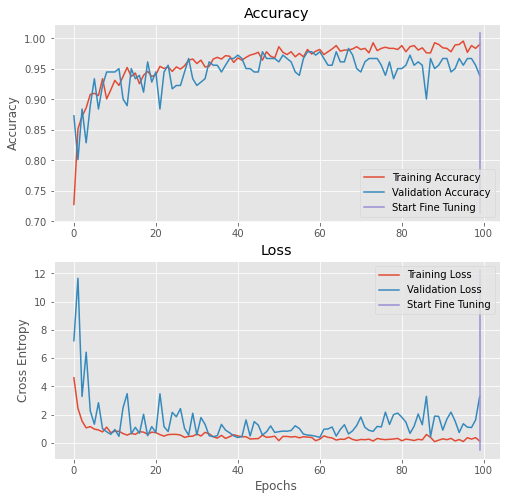

In [23]:
acc = train_history.history['accuracy']
val_acc = train_history.history['val_accuracy']

loss = train_history.history['loss']
val_loss = train_history.history['val_loss']

fig = plt.figure(figsize=(8, 8))
fig.patch.set_alpha(0.5)

plt.subplot(2, 1, 1)
plt.plot(acc)
plt.plot(val_acc)
plt.plot([init_epochs - 1, init_epochs - 1], plt.ylim())
plt.legend(['Training Accuracy', 'Validation Accuracy', 'Start Fine Tuning'],
           loc='lower right')
plt.ylabel('Accuracy')
plt.title('Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss)
plt.plot(val_loss)
plt.plot([init_epochs - 1, init_epochs - 1], plt.ylim())
plt.legend(['Training Loss', 'Validation Loss', 'Start Fine Tuning'],
           loc='upper right')
plt.ylabel('Cross Entropy')
plt.xlabel('Epochs')
plt.title('Loss')
plt.savefig(path + "/training_plot1.pdf")
plt.show()

In [24]:
new_model.evaluate(test_ds)

1/5 [=====>........................] - ETA: 0s - loss: 8.0705 - accuracy: 0.8125

2/5 [===========>..................] - ETA: 2s - loss: 5.7944 - accuracy: 0.8750

3/5 [=================>............] - ETA: 2s - loss: 3.8629 - accuracy: 0.9167

4/5 [=======================>......] - ETA: 1s - loss: 2.8972 - accuracy: 0.9375

5/5 [==============================] - ETA: 0s - loss: 2.7218 - accuracy: 0.9413

5/5 [==============================] - 9s 2s/step - loss: 2.7218 - accuracy: 0.9413


[2.7217845916748047, 0.9412844181060791]

# Fine Tuning

In [25]:
new_model.get_layer('vgg16_features').trainable = False
for layer in new_model.get_layer('vgg16_features').layers:
    for block_name in trainable_blocks:
        if layer.name.startswith(block_name):
            layer.trainable = True
new_model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Image_Input (InputLayer)        [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
VGG_Preprocess (Lambda)         (None, 224, 224, 3)  0           Image_Input[0][0]                
__________________________________________________________________________________________________
vgg16_features (Functional)     (None, 14, 14, 512)  7635264     VGG_Preprocess[0][0]             
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 14, 64)   32832       vgg16_features[0][0]             
_______________________________________________________________________________________

In [26]:
lr_start = lr_min = 1e-5
lr_max = 5e-5

lr_warmup_epochs = 25
lr_exp_decay = 0.8

def lr_schedule(epoch):
    if epoch < lr_warmup_epochs:
        lr = (lr_max - lr_start) / lr_warmup_epochs * epoch + lr_start
    else:
        lr = (lr_max - lr_min) * lr_exp_decay ** (epoch - lr_warmup_epochs) + lr_min
    return lr

cbs = [keras.callbacks.LearningRateScheduler(lr_schedule, verbose=True)]


In [27]:
cbs += [TensorBoard(tb_path)]

In [28]:
epochs=50

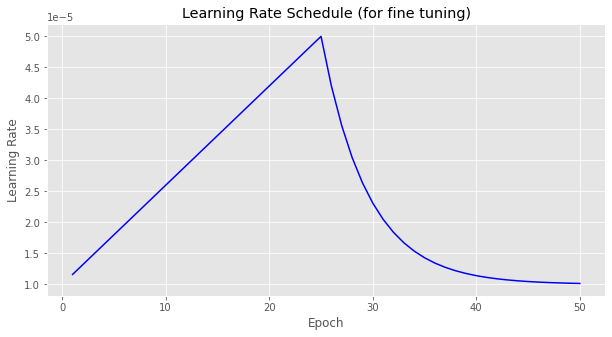

In [29]:
epx = range(1, epochs + 1)
lrs = [lr_schedule(e) for e in epx]
plt.figure(figsize=(10, 5))
plt.plot(epx, lrs, 'b-')
plt.title("Learning Rate Schedule (for fine tuning)")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.savefig(path + '/lr_schedule.pdf')
plt.show()

In [30]:
new_model.compile('adam', 'categorical_crossentropy',
               metrics=['accuracy'])

In [31]:
train_ds = dataset(train_path, image_size, crop_size, 64, train=True)

Found 1087 files belonging to 2 classes.


In [32]:
train_history = new_model.fit(train_ds, epochs=init_epochs+epochs, 
                              validation_data=val_ds,
                              initial_epoch=init_epochs,
                              callbacks=cbs,
                              verbose=1)


Epoch 00101: LearningRateScheduler reducing learning rate to 1.0000002156795734e-05.
Epoch 101/150


 1/17 [>.............................] - ETA: 0s - loss: 8.3496e-04 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 4s - loss: 4.1748e-04 - accuracy: 1.0000

 3/17 [====>.........................] - ETA: 5s - loss: 0.0412 - accuracy: 0.9948    

 4/17 [======>.......................] - ETA: 15s - loss: 0.1210 - accuracy: 0.9883

 5/17 [=======>......................] - ETA: 13s - loss: 0.0968 - accuracy: 0.9906

 6/17 [=========>....................] - ETA: 13s - loss: 0.1064 - accuracy: 0.9896

 7/17 [===========>..................] - ETA: 12s - loss: 0.0912 - accuracy: 0.9911

 8/17 [=============>................] - ETA: 11s - loss: 0.2293 - accuracy: 0.9844

 9/17 [==============>...............] - ETA: 9s - loss: 0.2079 - accuracy: 0.9844 

10/17 [================>.............] - ETA: 8s - loss: 0.2817 - accuracy: 0.9828

11/17 [==================>...........] - ETA: 8s - loss: 0.2561 - accuracy: 0.9844

12/17 [====================>.........] - ETA: 7s - loss: 0.2348 - accuracy: 0.9857

13/17 [=====================>........] - ETA: 5s - loss: 0.2167 - accuracy: 0.9868

14/17 [=======================>......] - ETA: 3s - loss: 0.2015 - accuracy: 0.9877

15/17 [=========================>....] - ETA: 2s - loss: 0.1915 - accuracy: 0.9875

16/17 [===========================>..] - ETA: 1s - loss: 0.1795 - accuracy: 0.9883

17/17 [==============================] - ETA: 0s - loss: 0.2321 - accuracy: 0.9862

17/17 [==============================] - 23s 1s/step - loss: 0.2321 - accuracy: 0.9862 - val_loss: 2.6421 - val_accuracy: 0.9448



Epoch 00102: LearningRateScheduler reducing learning rate to 1.0000001725436587e-05.
Epoch 102/150


 1/17 [>.............................] - ETA: 0s - loss: 3.3878e-06 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 8s - loss: 1.6958e-06 - accuracy: 1.0000

 3/17 [====>.........................] - ETA: 19s - loss: 0.2402 - accuracy: 0.9844   

 4/17 [======>.......................] - ETA: 16s - loss: 0.1805 - accuracy: 0.9883

 5/17 [=======>......................] - ETA: 15s - loss: 0.1444 - accuracy: 0.9906

 6/17 [=========>....................] - ETA: 15s - loss: 0.1203 - accuracy: 0.9922

 7/17 [===========>..................] - ETA: 13s - loss: 0.1031 - accuracy: 0.9933

 8/17 [=============>................] - ETA: 13s - loss: 0.0902 - accuracy: 0.9941

 9/17 [==============>...............] - ETA: 12s - loss: 0.0802 - accuracy: 0.9948

10/17 [================>.............] - ETA: 11s - loss: 0.1135 - accuracy: 0.9937

11/17 [==================>...........] - ETA: 9s - loss: 0.1593 - accuracy: 0.9915 

12/17 [====================>.........] - ETA: 7s - loss: 0.1462 - accuracy: 0.9922

13/17 [=====================>........] - ETA: 5s - loss: 0.2075 - accuracy: 0.9904

14/17 [=======================>......] - ETA: 4s - loss: 0.2263 - accuracy: 0.9888

15/17 [=========================>....] - ETA: 2s - loss: 0.2737 - accuracy: 0.9875

16/17 [===========================>..] - ETA: 1s - loss: 0.2586 - accuracy: 0.9873

17/17 [==============================] - ETA: 0s - loss: 0.2450 - accuracy: 0.9871

17/17 [==============================] - 24s 1s/step - loss: 0.2450 - accuracy: 0.9871 - val_loss: 2.3045 - val_accuracy: 0.9503



Epoch 00103: LearningRateScheduler reducing learning rate to 1.0000001380349271e-05.
Epoch 103/150


 1/17 [>.............................] - ETA: 0s - loss: 0.1357 - accuracy: 0.9844

 2/17 [==>...........................] - ETA: 11s - loss: 0.0678 - accuracy: 0.9922

 3/17 [====>.........................] - ETA: 9s - loss: 0.0452 - accuracy: 0.9948 

 4/17 [======>.......................] - ETA: 10s - loss: 0.0339 - accuracy: 0.9961

 5/17 [=======>......................] - ETA: 12s - loss: 0.1854 - accuracy: 0.9906

 6/17 [=========>....................] - ETA: 13s - loss: 0.1545 - accuracy: 0.9922

 7/17 [===========>..................] - ETA: 12s - loss: 0.1532 - accuracy: 0.9911

 8/17 [=============>................] - ETA: 12s - loss: 0.1520 - accuracy: 0.9883

 9/17 [==============>...............] - ETA: 11s - loss: 0.1351 - accuracy: 0.9896

10/17 [================>.............] - ETA: 10s - loss: 0.2137 - accuracy: 0.9875

11/17 [==================>...........] - ETA: 9s - loss: 0.2784 - accuracy: 0.9858 

12/17 [====================>.........] - ETA: 7s - loss: 0.2830 - accuracy: 0.9857

13/17 [=====================>........] - ETA: 5s - loss: 0.2616 - accuracy: 0.9868

14/17 [=======================>......] - ETA: 3s - loss: 0.2429 - accuracy: 0.9877

15/17 [=========================>....] - ETA: 2s - loss: 0.2383 - accuracy: 0.9875

16/17 [===========================>..] - ETA: 1s - loss: 0.2234 - accuracy: 0.9883

17/17 [==============================] - ETA: 0s - loss: 0.2107 - accuracy: 0.9890

17/17 [==============================] - 23s 1s/step - loss: 0.2107 - accuracy: 0.9890 - val_loss: 2.0227 - val_accuracy: 0.9558



Epoch 00104: LearningRateScheduler reducing learning rate to 1.0000001104279416e-05.
Epoch 104/150


 1/17 [>.............................] - ETA: 0s - loss: 0.8145 - accuracy: 0.9844

 2/17 [==>...........................] - ETA: 9s - loss: 0.4526 - accuracy: 0.9844

 3/17 [====>.........................] - ETA: 14s - loss: 0.3450 - accuracy: 0.9844

 4/17 [======>.......................] - ETA: 11s - loss: 0.4319 - accuracy: 0.9727

 5/17 [=======>......................] - ETA: 16s - loss: 0.3455 - accuracy: 0.9781

 6/17 [=========>....................] - ETA: 13s - loss: 0.2951 - accuracy: 0.9792

 7/17 [===========>..................] - ETA: 13s - loss: 0.2769 - accuracy: 0.9799

 8/17 [=============>................] - ETA: 13s - loss: 0.2423 - accuracy: 0.9824

 9/17 [==============>...............] - ETA: 12s - loss: 0.2918 - accuracy: 0.9809

10/17 [================>.............] - ETA: 11s - loss: 0.3759 - accuracy: 0.9812

11/17 [==================>...........] - ETA: 9s - loss: 0.3441 - accuracy: 0.9815 

12/17 [====================>.........] - ETA: 7s - loss: 0.3155 - accuracy: 0.9831

13/17 [=====================>........] - ETA: 5s - loss: 0.3896 - accuracy: 0.9796

14/17 [=======================>......] - ETA: 4s - loss: 0.3617 - accuracy: 0.9810

15/17 [=========================>....] - ETA: 2s - loss: 0.3522 - accuracy: 0.9812

16/17 [===========================>..] - ETA: 1s - loss: 0.3303 - accuracy: 0.9824

17/17 [==============================] - ETA: 0s - loss: 0.3111 - accuracy: 0.9834

17/17 [==============================] - 24s 1s/step - loss: 0.3111 - accuracy: 0.9834 - val_loss: 1.8218 - val_accuracy: 0.9558



Epoch 00105: LearningRateScheduler reducing learning rate to 1.0000000883423533e-05.
Epoch 105/150


 1/17 [>.............................] - ETA: 0s - loss: 0.1068 - accuracy: 0.9844

 2/17 [==>...........................] - ETA: 28s - loss: 0.0992 - accuracy: 0.9844

 3/17 [====>.........................] - ETA: 19s - loss: 0.4530 - accuracy: 0.9740

 4/17 [======>.......................] - ETA: 15s - loss: 0.6098 - accuracy: 0.9648

 5/17 [=======>......................] - ETA: 15s - loss: 0.5534 - accuracy: 0.9688

 6/17 [=========>....................] - ETA: 16s - loss: 0.4612 - accuracy: 0.9740

 7/17 [===========>..................] - ETA: 14s - loss: 0.3953 - accuracy: 0.9777

 8/17 [=============>................] - ETA: 13s - loss: 0.4472 - accuracy: 0.9746

 9/17 [==============>...............] - ETA: 11s - loss: 0.4496 - accuracy: 0.9740

10/17 [================>.............] - ETA: 10s - loss: 0.4201 - accuracy: 0.9750

11/17 [==================>...........] - ETA: 8s - loss: 0.3819 - accuracy: 0.9773 

12/17 [====================>.........] - ETA: 6s - loss: 0.3521 - accuracy: 0.9779

13/17 [=====================>........] - ETA: 5s - loss: 0.3379 - accuracy: 0.9784

14/17 [=======================>......] - ETA: 3s - loss: 0.4289 - accuracy: 0.9766

15/17 [=========================>....] - ETA: 2s - loss: 0.4354 - accuracy: 0.9771

16/17 [===========================>..] - ETA: 1s - loss: 0.4082 - accuracy: 0.9785

17/17 [==============================] - ETA: 0s - loss: 0.3845 - accuracy: 0.9798

17/17 [==============================] - 24s 1s/step - loss: 0.3845 - accuracy: 0.9798 - val_loss: 1.6424 - val_accuracy: 0.9558



Epoch 00106: LearningRateScheduler reducing learning rate to 1.0000000706738827e-05.
Epoch 106/150


 1/17 [>.............................] - ETA: 0s - loss: 0.2335 - accuracy: 0.9688

 2/17 [==>...........................] - ETA: 21s - loss: 0.1550 - accuracy: 0.9688

 3/17 [====>.........................] - ETA: 15s - loss: 0.1816 - accuracy: 0.9740

 4/17 [======>.......................] - ETA: 12s - loss: 0.1751 - accuracy: 0.9766

 5/17 [=======>......................] - ETA: 14s - loss: 0.2009 - accuracy: 0.9750

 6/17 [=========>....................] - ETA: 13s - loss: 0.1675 - accuracy: 0.9792

 7/17 [===========>..................] - ETA: 16s - loss: 0.1453 - accuracy: 0.9799

 8/17 [=============>................] - ETA: 14s - loss: 0.2762 - accuracy: 0.9766

 9/17 [==============>...............] - ETA: 13s - loss: 0.2455 - accuracy: 0.9792

10/17 [================>.............] - ETA: 10s - loss: 0.2844 - accuracy: 0.9781

11/17 [==================>...........] - ETA: 9s - loss: 0.2625 - accuracy: 0.9773 

12/17 [====================>.........] - ETA: 7s - loss: 0.2408 - accuracy: 0.9792

13/17 [=====================>........] - ETA: 5s - loss: 0.2223 - accuracy: 0.9808

14/17 [=======================>......] - ETA: 3s - loss: 0.2086 - accuracy: 0.9810

15/17 [=========================>....] - ETA: 2s - loss: 0.2029 - accuracy: 0.9802

16/17 [===========================>..] - ETA: 1s - loss: 0.1902 - accuracy: 0.9814

17/17 [==============================] - ETA: 0s - loss: 0.2350 - accuracy: 0.9807

17/17 [==============================] - 23s 1s/step - loss: 0.2350 - accuracy: 0.9807 - val_loss: 1.4782 - val_accuracy: 0.9558



Epoch 00107: LearningRateScheduler reducing learning rate to 1.0000000565391061e-05.
Epoch 107/150


 1/17 [>.............................] - ETA: 0s - loss: 0.3688 - accuracy: 0.9844

 2/17 [==>...........................] - ETA: 8s - loss: 0.5825 - accuracy: 0.9766

 3/17 [====>.........................] - ETA: 23s - loss: 0.3883 - accuracy: 0.9844

 4/17 [======>.......................] - ETA: 19s - loss: 0.2912 - accuracy: 0.9883

 5/17 [=======>......................] - ETA: 15s - loss: 0.2330 - accuracy: 0.9906

 6/17 [=========>....................] - ETA: 16s - loss: 0.2175 - accuracy: 0.9896

 7/17 [===========>..................] - ETA: 17s - loss: 0.2206 - accuracy: 0.9844

 8/17 [=============>................] - ETA: 14s - loss: 0.2513 - accuracy: 0.9844

 9/17 [==============>...............] - ETA: 12s - loss: 0.2234 - accuracy: 0.9861

10/17 [================>.............] - ETA: 11s - loss: 0.2503 - accuracy: 0.9859

11/17 [==================>...........] - ETA: 10s - loss: 0.2522 - accuracy: 0.9858

12/17 [====================>.........] - ETA: 7s - loss: 0.2350 - accuracy: 0.9857 

13/17 [=====================>........] - ETA: 6s - loss: 0.2321 - accuracy: 0.9856

14/17 [=======================>......] - ETA: 4s - loss: 0.2400 - accuracy: 0.9844

15/17 [=========================>....] - ETA: 2s - loss: 0.2414 - accuracy: 0.9833

16/17 [===========================>..] - ETA: 1s - loss: 0.2697 - accuracy: 0.9824

17/17 [==============================] - ETA: 0s - loss: 0.2732 - accuracy: 0.9816

17/17 [==============================] - 25s 1s/step - loss: 0.2732 - accuracy: 0.9816 - val_loss: 1.3678 - val_accuracy: 0.9558



Epoch 00108: LearningRateScheduler reducing learning rate to 1.0000000452312849e-05.
Epoch 108/150


 1/17 [>.............................] - ETA: 0s - loss: 7.6553e-07 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 14s - loss: 0.1222 - accuracy: 0.9922   

 3/17 [====>.........................] - ETA: 14s - loss: 0.1498 - accuracy: 0.9844

 4/17 [======>.......................] - ETA: 18s - loss: 0.2755 - accuracy: 0.9805

 5/17 [=======>......................] - ETA: 16s - loss: 0.2204 - accuracy: 0.9844

 6/17 [=========>....................] - ETA: 14s - loss: 0.2043 - accuracy: 0.9844

 7/17 [===========>..................] - ETA: 13s - loss: 0.1830 - accuracy: 0.9844

 8/17 [=============>................] - ETA: 13s - loss: 0.3006 - accuracy: 0.9824

 9/17 [==============>...............] - ETA: 12s - loss: 0.2673 - accuracy: 0.9844

10/17 [================>.............] - ETA: 11s - loss: 0.2405 - accuracy: 0.9859

11/17 [==================>...........] - ETA: 9s - loss: 0.2538 - accuracy: 0.9844 

12/17 [====================>.........] - ETA: 7s - loss: 0.2326 - accuracy: 0.9857

13/17 [=====================>........] - ETA: 5s - loss: 0.2159 - accuracy: 0.9856

14/17 [=======================>......] - ETA: 4s - loss: 0.2005 - accuracy: 0.9866

15/17 [=========================>....] - ETA: 2s - loss: 0.1871 - accuracy: 0.9875

16/17 [===========================>..] - ETA: 1s - loss: 0.1818 - accuracy: 0.9873

17/17 [==============================] - ETA: 0s - loss: 0.1713 - accuracy: 0.9880

17/17 [==============================] - 24s 1s/step - loss: 0.1713 - accuracy: 0.9880 - val_loss: 1.3013 - val_accuracy: 0.9558



Epoch 00109: LearningRateScheduler reducing learning rate to 1.000000036185028e-05.
Epoch 109/150


 1/17 [>.............................] - ETA: 0s - loss: 5.3830e-07 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 7s - loss: 0.0338 - accuracy: 0.9922    

 3/17 [====>.........................] - ETA: 21s - loss: 0.1066 - accuracy: 0.9844

 4/17 [======>.......................] - ETA: 19s - loss: 0.1055 - accuracy: 0.9844

 5/17 [=======>......................] - ETA: 15s - loss: 0.4325 - accuracy: 0.9812

 6/17 [=========>....................] - ETA: 15s - loss: 0.3604 - accuracy: 0.9844

 7/17 [===========>..................] - ETA: 17s - loss: 0.3098 - accuracy: 0.9866

 8/17 [=============>................] - ETA: 16s - loss: 0.3115 - accuracy: 0.9844

 9/17 [==============>...............] - ETA: 14s - loss: 0.2817 - accuracy: 0.9844

10/17 [================>.............] - ETA: 11s - loss: 0.2535 - accuracy: 0.9859

11/17 [==================>...........] - ETA: 9s - loss: 0.2305 - accuracy: 0.9872 

12/17 [====================>.........] - ETA: 7s - loss: 0.2684 - accuracy: 0.9844

13/17 [=====================>........] - ETA: 6s - loss: 0.2567 - accuracy: 0.9844

14/17 [=======================>......] - ETA: 4s - loss: 0.2384 - accuracy: 0.9855

15/17 [=========================>....] - ETA: 2s - loss: 0.2419 - accuracy: 0.9854

16/17 [===========================>..] - ETA: 1s - loss: 0.2268 - accuracy: 0.9863

17/17 [==============================] - ETA: 0s - loss: 0.2136 - accuracy: 0.9871

17/17 [==============================] - 25s 1s/step - loss: 0.2136 - accuracy: 0.9871 - val_loss: 1.2418 - val_accuracy: 0.9669



Epoch 00110: LearningRateScheduler reducing learning rate to 1.0000000289480224e-05.
Epoch 110/150


 1/17 [>.............................] - ETA: 0s - loss: 0.1482 - accuracy: 0.9844

 2/17 [==>...........................] - ETA: 16s - loss: 0.4153 - accuracy: 0.9844

 3/17 [====>.........................] - ETA: 19s - loss: 0.2769 - accuracy: 0.9896

 4/17 [======>.......................] - ETA: 17s - loss: 0.3565 - accuracy: 0.9883

 5/17 [=======>......................] - ETA: 18s - loss: 0.2852 - accuracy: 0.9906

 6/17 [=========>....................] - ETA: 15s - loss: 0.2376 - accuracy: 0.9922

 7/17 [===========>..................] - ETA: 17s - loss: 0.2037 - accuracy: 0.9933

 8/17 [=============>................] - ETA: 16s - loss: 0.1782 - accuracy: 0.9941

 9/17 [==============>...............] - ETA: 14s - loss: 0.1604 - accuracy: 0.9931

10/17 [================>.............] - ETA: 11s - loss: 0.1548 - accuracy: 0.9922

11/17 [==================>...........] - ETA: 10s - loss: 0.1640 - accuracy: 0.9901

12/17 [====================>.........] - ETA: 7s - loss: 0.1503 - accuracy: 0.9909 

13/17 [=====================>........] - ETA: 5s - loss: 0.1635 - accuracy: 0.9904

14/17 [=======================>......] - ETA: 4s - loss: 0.1612 - accuracy: 0.9900

15/17 [=========================>....] - ETA: 2s - loss: 0.1504 - accuracy: 0.9906

16/17 [===========================>..] - ETA: 1s - loss: 0.1412 - accuracy: 0.9912

17/17 [==============================] - ETA: 0s - loss: 0.1339 - accuracy: 0.9917

17/17 [==============================] - 24s 1s/step - loss: 0.1339 - accuracy: 0.9917 - val_loss: 1.2040 - val_accuracy: 0.9669



Epoch 00111: LearningRateScheduler reducing learning rate to 1.0000000231584179e-05.
Epoch 111/150


 1/17 [>.............................] - ETA: 0s - loss: 1.8797e-04 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 8s - loss: 0.0688 - accuracy: 0.9922    

 3/17 [====>.........................] - ETA: 16s - loss: 0.5179 - accuracy: 0.9688

 4/17 [======>.......................] - ETA: 17s - loss: 0.5878 - accuracy: 0.9648

 5/17 [=======>......................] - ETA: 14s - loss: 0.5539 - accuracy: 0.9688

 6/17 [=========>....................] - ETA: 11s - loss: 0.4616 - accuracy: 0.9740

 7/17 [===========>..................] - ETA: 11s - loss: 0.4147 - accuracy: 0.9754

 8/17 [=============>................] - ETA: 11s - loss: 0.4486 - accuracy: 0.9746

 9/17 [==============>...............] - ETA: 11s - loss: 0.4253 - accuracy: 0.9740

10/17 [================>.............] - ETA: 10s - loss: 0.3827 - accuracy: 0.9766

11/17 [==================>...........] - ETA: 8s - loss: 0.4535 - accuracy: 0.9759 

12/17 [====================>.........] - ETA: 7s - loss: 0.4314 - accuracy: 0.9766

13/17 [=====================>........] - ETA: 5s - loss: 0.4185 - accuracy: 0.9772

14/17 [=======================>......] - ETA: 3s - loss: 0.3886 - accuracy: 0.9788

15/17 [=========================>....] - ETA: 2s - loss: 0.3650 - accuracy: 0.9792

16/17 [===========================>..] - ETA: 1s - loss: 0.3423 - accuracy: 0.9805

17/17 [==============================] - ETA: 0s - loss: 0.3224 - accuracy: 0.9816

17/17 [==============================] - 22s 1s/step - loss: 0.3224 - accuracy: 0.9816 - val_loss: 1.1895 - val_accuracy: 0.9669



Epoch 00112: LearningRateScheduler reducing learning rate to 1.0000000185267343e-05.
Epoch 112/150


 1/17 [>.............................] - ETA: 0s - loss: 0.1374 - accuracy: 0.9844

 2/17 [==>...........................] - ETA: 17s - loss: 0.1643 - accuracy: 0.9844

 3/17 [====>.........................] - ETA: 15s - loss: 0.3684 - accuracy: 0.9635

 4/17 [======>.......................] - ETA: 19s - loss: 0.2764 - accuracy: 0.9727

 5/17 [=======>......................] - ETA: 18s - loss: 0.2211 - accuracy: 0.9781

 6/17 [=========>....................] - ETA: 15s - loss: 0.1842 - accuracy: 0.9818

 7/17 [===========>..................] - ETA: 13s - loss: 0.1634 - accuracy: 0.9821

 8/17 [=============>................] - ETA: 13s - loss: 0.1890 - accuracy: 0.9805

 9/17 [==============>...............] - ETA: 12s - loss: 0.1779 - accuracy: 0.9809

10/17 [================>.............] - ETA: 11s - loss: 0.1601 - accuracy: 0.9828

11/17 [==================>...........] - ETA: 9s - loss: 0.1550 - accuracy: 0.9830 

12/17 [====================>.........] - ETA: 7s - loss: 0.1461 - accuracy: 0.9831

13/17 [=====================>........] - ETA: 5s - loss: 0.1349 - accuracy: 0.9844

14/17 [=======================>......] - ETA: 4s - loss: 0.1291 - accuracy: 0.9844

15/17 [=========================>....] - ETA: 2s - loss: 0.1419 - accuracy: 0.9844

16/17 [===========================>..] - ETA: 1s - loss: 0.1433 - accuracy: 0.9844

17/17 [==============================] - ETA: 0s - loss: 0.1354 - accuracy: 0.9853

17/17 [==============================] - 24s 1s/step - loss: 0.1354 - accuracy: 0.9853 - val_loss: 1.1889 - val_accuracy: 0.9669



Epoch 00113: LearningRateScheduler reducing learning rate to 1.0000000148213875e-05.
Epoch 113/150


 1/17 [>.............................] - ETA: 0s - loss: 7.2986e-04 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 9s - loss: 3.6496e-04 - accuracy: 1.0000

 3/17 [====>.........................] - ETA: 8s - loss: 2.4384e-04 - accuracy: 1.0000

 4/17 [======>.......................] - ETA: 12s - loss: 0.0392 - accuracy: 0.9961   

 5/17 [=======>......................] - ETA: 13s - loss: 0.0875 - accuracy: 0.9937

 6/17 [=========>....................] - ETA: 11s - loss: 0.1300 - accuracy: 0.9870

 7/17 [===========>..................] - ETA: 11s - loss: 0.1121 - accuracy: 0.9888

 8/17 [=============>................] - ETA: 12s - loss: 0.0981 - accuracy: 0.9902

 9/17 [==============>...............] - ETA: 11s - loss: 0.1245 - accuracy: 0.9896

10/17 [================>.............] - ETA: 10s - loss: 0.1121 - accuracy: 0.9906

11/17 [==================>...........] - ETA: 9s - loss: 0.1055 - accuracy: 0.9901 

12/17 [====================>.........] - ETA: 7s - loss: 0.2089 - accuracy: 0.9870

13/17 [=====================>........] - ETA: 5s - loss: 0.2055 - accuracy: 0.9856

14/17 [=======================>......] - ETA: 3s - loss: 0.2008 - accuracy: 0.9855

15/17 [=========================>....] - ETA: 2s - loss: 0.1897 - accuracy: 0.9854

16/17 [===========================>..] - ETA: 1s - loss: 0.2020 - accuracy: 0.9854

17/17 [==============================] - ETA: 0s - loss: 0.2020 - accuracy: 0.9853

17/17 [==============================] - 23s 1s/step - loss: 0.2020 - accuracy: 0.9853 - val_loss: 1.1683 - val_accuracy: 0.9669



Epoch 00114: LearningRateScheduler reducing learning rate to 1.00000001185711e-05.
Epoch 114/150


 1/17 [>.............................] - ETA: 0s - loss: 0.4765 - accuracy: 0.9844

 2/17 [==>...........................] - ETA: 16s - loss: 0.2382 - accuracy: 0.9922

 3/17 [====>.........................] - ETA: 16s - loss: 0.2378 - accuracy: 0.9740

 4/17 [======>.......................] - ETA: 14s - loss: 0.3370 - accuracy: 0.9766

 5/17 [=======>......................] - ETA: 18s - loss: 0.2857 - accuracy: 0.9781

 6/17 [=========>....................] - ETA: 16s - loss: 0.2437 - accuracy: 0.9792

 7/17 [===========>..................] - ETA: 13s - loss: 0.2089 - accuracy: 0.9821

 8/17 [=============>................] - ETA: 14s - loss: 0.1827 - accuracy: 0.9844

 9/17 [==============>...............] - ETA: 12s - loss: 0.1896 - accuracy: 0.9809

10/17 [================>.............] - ETA: 11s - loss: 0.1714 - accuracy: 0.9828

11/17 [==================>...........] - ETA: 9s - loss: 0.1972 - accuracy: 0.9815 

12/17 [====================>.........] - ETA: 7s - loss: 0.1808 - accuracy: 0.9831

13/17 [=====================>........] - ETA: 5s - loss: 0.2007 - accuracy: 0.9832

14/17 [=======================>......] - ETA: 4s - loss: 0.1864 - accuracy: 0.9844

15/17 [=========================>....] - ETA: 2s - loss: 0.2134 - accuracy: 0.9844

16/17 [===========================>..] - ETA: 1s - loss: 0.2001 - accuracy: 0.9854

17/17 [==============================] - ETA: 0s - loss: 0.2269 - accuracy: 0.9844

17/17 [==============================] - 24s 1s/step - loss: 0.2269 - accuracy: 0.9844 - val_loss: 1.1418 - val_accuracy: 0.9669



Epoch 00115: LearningRateScheduler reducing learning rate to 1.0000000094856881e-05.
Epoch 115/150


 1/17 [>.............................] - ETA: 0s - loss: 5.0768e-06 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 3s - loss: 0.0041 - accuracy: 1.0000    

 3/17 [====>.........................] - ETA: 18s - loss: 0.0029 - accuracy: 1.0000

 4/17 [======>.......................] - ETA: 18s - loss: 0.0796 - accuracy: 0.9922

 5/17 [=======>......................] - ETA: 14s - loss: 0.0637 - accuracy: 0.9937

 6/17 [=========>....................] - ETA: 12s - loss: 0.1941 - accuracy: 0.9922

 7/17 [===========>..................] - ETA: 14s - loss: 0.1891 - accuracy: 0.9888

 8/17 [=============>................] - ETA: 13s - loss: 0.1760 - accuracy: 0.9883

 9/17 [==============>...............] - ETA: 12s - loss: 0.1895 - accuracy: 0.9878

10/17 [================>.............] - ETA: 11s - loss: 0.1705 - accuracy: 0.9891

11/17 [==================>...........] - ETA: 9s - loss: 0.1613 - accuracy: 0.9886 

12/17 [====================>.........] - ETA: 7s - loss: 0.1481 - accuracy: 0.9896

13/17 [=====================>........] - ETA: 5s - loss: 0.1367 - accuracy: 0.9904

14/17 [=======================>......] - ETA: 4s - loss: 0.1270 - accuracy: 0.9911

15/17 [=========================>....] - ETA: 2s - loss: 0.1230 - accuracy: 0.9906

16/17 [===========================>..] - ETA: 1s - loss: 0.1696 - accuracy: 0.9893

17/17 [==============================] - ETA: 0s - loss: 0.1820 - accuracy: 0.9890

17/17 [==============================] - 24s 1s/step - loss: 0.1820 - accuracy: 0.9890 - val_loss: 1.1308 - val_accuracy: 0.9669



Epoch 00116: LearningRateScheduler reducing learning rate to 1.0000000075885505e-05.
Epoch 116/150


 1/17 [>.............................] - ETA: 0s - loss: 0.1166 - accuracy: 0.9844

 2/17 [==>...........................] - ETA: 3s - loss: 0.2356 - accuracy: 0.9844

 3/17 [====>.........................] - ETA: 17s - loss: 0.6758 - accuracy: 0.9844

 4/17 [======>.......................] - ETA: 13s - loss: 0.6588 - accuracy: 0.9844

 5/17 [=======>......................] - ETA: 16s - loss: 0.5293 - accuracy: 0.9844

 6/17 [=========>....................] - ETA: 13s - loss: 0.5037 - accuracy: 0.9818

 7/17 [===========>..................] - ETA: 13s - loss: 0.4319 - accuracy: 0.9844

 8/17 [=============>................] - ETA: 13s - loss: 0.3965 - accuracy: 0.9844

 9/17 [==============>...............] - ETA: 10s - loss: 0.3527 - accuracy: 0.9861

10/17 [================>.............] - ETA: 9s - loss: 0.3369 - accuracy: 0.9859 

11/17 [==================>...........] - ETA: 8s - loss: 0.3063 - accuracy: 0.9872

12/17 [====================>.........] - ETA: 7s - loss: 0.2808 - accuracy: 0.9883

13/17 [=====================>........] - ETA: 5s - loss: 0.2600 - accuracy: 0.9880

14/17 [=======================>......] - ETA: 4s - loss: 0.2512 - accuracy: 0.9877

15/17 [=========================>....] - ETA: 2s - loss: 0.2350 - accuracy: 0.9885

16/17 [===========================>..] - ETA: 1s - loss: 0.2253 - accuracy: 0.9883

17/17 [==============================] - ETA: 0s - loss: 0.2122 - accuracy: 0.9890

17/17 [==============================] - 23s 1s/step - loss: 0.2122 - accuracy: 0.9890 - val_loss: 1.1094 - val_accuracy: 0.9669



Epoch 00117: LearningRateScheduler reducing learning rate to 1.0000000060708404e-05.
Epoch 117/150


 1/17 [>.............................] - ETA: 0s - loss: 0.2236 - accuracy: 0.9688

 2/17 [==>...........................] - ETA: 3s - loss: 0.1911 - accuracy: 0.9766

 3/17 [====>.........................] - ETA: 18s - loss: 0.1274 - accuracy: 0.9844

 4/17 [======>.......................] - ETA: 15s - loss: 0.0955 - accuracy: 0.9883

 5/17 [=======>......................] - ETA: 14s - loss: 0.0801 - accuracy: 0.9875

 6/17 [=========>....................] - ETA: 14s - loss: 0.0668 - accuracy: 0.9896

 7/17 [===========>..................] - ETA: 13s - loss: 0.0572 - accuracy: 0.9911

 8/17 [=============>................] - ETA: 13s - loss: 0.0506 - accuracy: 0.9922

 9/17 [==============>...............] - ETA: 12s - loss: 0.0450 - accuracy: 0.9931

10/17 [================>.............] - ETA: 11s - loss: 0.0470 - accuracy: 0.9922

11/17 [==================>...........] - ETA: 9s - loss: 0.0667 - accuracy: 0.9915 

12/17 [====================>.........] - ETA: 7s - loss: 0.1209 - accuracy: 0.9909

13/17 [=====================>........] - ETA: 5s - loss: 0.1545 - accuracy: 0.9904

14/17 [=======================>......] - ETA: 4s - loss: 0.1435 - accuracy: 0.9911

15/17 [=========================>....] - ETA: 2s - loss: 0.1369 - accuracy: 0.9906

16/17 [===========================>..] - ETA: 1s - loss: 0.1462 - accuracy: 0.9902

17/17 [==============================] - ETA: 0s - loss: 0.1670 - accuracy: 0.9899

17/17 [==============================] - 24s 1s/step - loss: 0.1670 - accuracy: 0.9899 - val_loss: 1.0821 - val_accuracy: 0.9669



Epoch 00118: LearningRateScheduler reducing learning rate to 1.0000000048566724e-05.
Epoch 118/150


 1/17 [>.............................] - ETA: 0s - loss: 1.8626e-09 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 11s - loss: 0.0652 - accuracy: 0.9844   

 3/17 [====>.........................] - ETA: 22s - loss: 0.0945 - accuracy: 0.9844

 4/17 [======>.......................] - ETA: 23s - loss: 0.1774 - accuracy: 0.9844

 5/17 [=======>......................] - ETA: 18s - loss: 0.1938 - accuracy: 0.9812

 6/17 [=========>....................] - ETA: 16s - loss: 0.2294 - accuracy: 0.9792

 7/17 [===========>..................] - ETA: 13s - loss: 0.1966 - accuracy: 0.9821

 8/17 [=============>................] - ETA: 13s - loss: 0.1725 - accuracy: 0.9844

 9/17 [==============>...............] - ETA: 12s - loss: 0.1894 - accuracy: 0.9844

10/17 [================>.............] - ETA: 11s - loss: 0.2963 - accuracy: 0.9844

11/17 [==================>...........] - ETA: 9s - loss: 0.3163 - accuracy: 0.9830 

12/17 [====================>.........] - ETA: 7s - loss: 0.2901 - accuracy: 0.9844

13/17 [=====================>........] - ETA: 5s - loss: 0.2678 - accuracy: 0.9856

14/17 [=======================>......] - ETA: 4s - loss: 0.3448 - accuracy: 0.9844

15/17 [=========================>....] - ETA: 2s - loss: 0.3218 - accuracy: 0.9854

16/17 [===========================>..] - ETA: 1s - loss: 0.3106 - accuracy: 0.9854

17/17 [==============================] - ETA: 0s - loss: 0.2930 - accuracy: 0.9862

17/17 [==============================] - 24s 1s/step - loss: 0.2930 - accuracy: 0.9862 - val_loss: 1.0863 - val_accuracy: 0.9669



Epoch 00119: LearningRateScheduler reducing learning rate to 1.0000000038853378e-05.
Epoch 119/150


 1/17 [>.............................] - ETA: 0s - loss: 0.2315 - accuracy: 0.9688

 2/17 [==>...........................] - ETA: 11s - loss: 0.1890 - accuracy: 0.9766

 3/17 [====>.........................] - ETA: 16s - loss: 0.1262 - accuracy: 0.9844

 4/17 [======>.......................] - ETA: 18s - loss: 0.1428 - accuracy: 0.9805

 5/17 [=======>......................] - ETA: 18s - loss: 0.1667 - accuracy: 0.9812

 6/17 [=========>....................] - ETA: 14s - loss: 0.1389 - accuracy: 0.9844

 7/17 [===========>..................] - ETA: 17s - loss: 0.1190 - accuracy: 0.9866

 8/17 [=============>................] - ETA: 16s - loss: 0.1238 - accuracy: 0.9863

 9/17 [==============>...............] - ETA: 14s - loss: 0.1403 - accuracy: 0.9861

10/17 [================>.............] - ETA: 13s - loss: 0.1622 - accuracy: 0.9859

11/17 [==================>...........] - ETA: 10s - loss: 0.1894 - accuracy: 0.9858

12/17 [====================>.........] - ETA: 8s - loss: 0.1892 - accuracy: 0.9844 

13/17 [=====================>........] - ETA: 6s - loss: 0.2176 - accuracy: 0.9844

14/17 [=======================>......] - ETA: 4s - loss: 0.2230 - accuracy: 0.9844

15/17 [=========================>....] - ETA: 2s - loss: 0.2081 - accuracy: 0.9854

16/17 [===========================>..] - ETA: 1s - loss: 0.1953 - accuracy: 0.9863

17/17 [==============================] - ETA: 0s - loss: 0.1982 - accuracy: 0.9853

17/17 [==============================] - 25s 1s/step - loss: 0.1982 - accuracy: 0.9853 - val_loss: 1.0902 - val_accuracy: 0.9669



Epoch 00120: LearningRateScheduler reducing learning rate to 1.0000000031082703e-05.
Epoch 120/150


 1/17 [>.............................] - ETA: 0s - loss: 0.1666 - accuracy: 0.9844

 2/17 [==>...........................] - ETA: 13s - loss: 0.1506 - accuracy: 0.9844

 3/17 [====>.........................] - ETA: 17s - loss: 0.1475 - accuracy: 0.9844

 4/17 [======>.......................] - ETA: 15s - loss: 0.1215 - accuracy: 0.9844

 5/17 [=======>......................] - ETA: 19s - loss: 0.1884 - accuracy: 0.9844

 6/17 [=========>....................] - ETA: 16s - loss: 0.1570 - accuracy: 0.9870

 7/17 [===========>..................] - ETA: 14s - loss: 0.1346 - accuracy: 0.9888

 8/17 [=============>................] - ETA: 14s - loss: 0.1241 - accuracy: 0.9883

 9/17 [==============>...............] - ETA: 12s - loss: 0.1125 - accuracy: 0.9878

10/17 [================>.............] - ETA: 11s - loss: 0.1030 - accuracy: 0.9875

11/17 [==================>...........] - ETA: 10s - loss: 0.1455 - accuracy: 0.9858

12/17 [====================>.........] - ETA: 7s - loss: 0.1476 - accuracy: 0.9857 

13/17 [=====================>........] - ETA: 5s - loss: 0.1808 - accuracy: 0.9856

14/17 [=======================>......] - ETA: 4s - loss: 0.1679 - accuracy: 0.9866

15/17 [=========================>....] - ETA: 2s - loss: 0.1567 - accuracy: 0.9875

16/17 [===========================>..] - ETA: 1s - loss: 0.1647 - accuracy: 0.9873

17/17 [==============================] - ETA: 0s - loss: 0.1572 - accuracy: 0.9871

17/17 [==============================] - 25s 1s/step - loss: 0.1572 - accuracy: 0.9871 - val_loss: 1.0766 - val_accuracy: 0.9669



Epoch 00121: LearningRateScheduler reducing learning rate to 1.0000000024866162e-05.
Epoch 121/150


 1/17 [>.............................] - ETA: 0s - loss: 0.8257 - accuracy: 0.9844

 2/17 [==>...........................] - ETA: 4s - loss: 0.5900 - accuracy: 0.9844

 3/17 [====>.........................] - ETA: 14s - loss: 0.4187 - accuracy: 0.9792

 4/17 [======>.......................] - ETA: 16s - loss: 0.3184 - accuracy: 0.9805

 5/17 [=======>......................] - ETA: 15s - loss: 0.3057 - accuracy: 0.9750

 6/17 [=========>....................] - ETA: 12s - loss: 0.2798 - accuracy: 0.9766

 7/17 [===========>..................] - ETA: 12s - loss: 0.2409 - accuracy: 0.9799

 8/17 [=============>................] - ETA: 12s - loss: 0.2716 - accuracy: 0.9805

 9/17 [==============>...............] - ETA: 10s - loss: 0.2487 - accuracy: 0.9809

10/17 [================>.............] - ETA: 9s - loss: 0.2933 - accuracy: 0.9797 

11/17 [==================>...........] - ETA: 7s - loss: 0.2911 - accuracy: 0.9801

12/17 [====================>.........] - ETA: 6s - loss: 0.2717 - accuracy: 0.9805

13/17 [=====================>........] - ETA: 5s - loss: 0.2776 - accuracy: 0.9796

14/17 [=======================>......] - ETA: 3s - loss: 0.2577 - accuracy: 0.9810

15/17 [=========================>....] - ETA: 2s - loss: 0.2407 - accuracy: 0.9823

16/17 [===========================>..] - ETA: 1s - loss: 0.2450 - accuracy: 0.9814

17/17 [==============================] - ETA: 0s - loss: 0.2308 - accuracy: 0.9825

17/17 [==============================] - 23s 1s/step - loss: 0.2308 - accuracy: 0.9825 - val_loss: 1.0737 - val_accuracy: 0.9669



Epoch 00122: LearningRateScheduler reducing learning rate to 1.000000001989293e-05.
Epoch 122/150


 1/17 [>.............................] - ETA: 0s - loss: 0.2202 - accuracy: 0.9844

 2/17 [==>...........................] - ETA: 6s - loss: 0.1528 - accuracy: 0.9844

 3/17 [====>.........................] - ETA: 14s - loss: 0.3809 - accuracy: 0.9792

 4/17 [======>.......................] - ETA: 20s - loss: 0.2856 - accuracy: 0.9844

 5/17 [=======>......................] - ETA: 16s - loss: 0.2285 - accuracy: 0.9875

 6/17 [=========>....................] - ETA: 14s - loss: 0.1904 - accuracy: 0.9896

 7/17 [===========>..................] - ETA: 12s - loss: 0.1645 - accuracy: 0.9911

 8/17 [=============>................] - ETA: 12s - loss: 0.1560 - accuracy: 0.9902

 9/17 [==============>...............] - ETA: 11s - loss: 0.1701 - accuracy: 0.9896

10/17 [================>.............] - ETA: 9s - loss: 0.1969 - accuracy: 0.9875 

11/17 [==================>...........] - ETA: 8s - loss: 0.2209 - accuracy: 0.9858

12/17 [====================>.........] - ETA: 7s - loss: 0.2025 - accuracy: 0.9870

13/17 [=====================>........] - ETA: 5s - loss: 0.1873 - accuracy: 0.9880

14/17 [=======================>......] - ETA: 3s - loss: 0.1739 - accuracy: 0.9888

15/17 [=========================>....] - ETA: 2s - loss: 0.1748 - accuracy: 0.9885

16/17 [===========================>..] - ETA: 1s - loss: 0.1808 - accuracy: 0.9883

17/17 [==============================] - ETA: 0s - loss: 0.1703 - accuracy: 0.9890

17/17 [==============================] - 23s 1s/step - loss: 0.1703 - accuracy: 0.9890 - val_loss: 1.0818 - val_accuracy: 0.9669



Epoch 00123: LearningRateScheduler reducing learning rate to 1.0000000015914344e-05.
Epoch 123/150


 1/17 [>.............................] - ETA: 0s - loss: 0.3023 - accuracy: 0.9844

 2/17 [==>...........................] - ETA: 9s - loss: 0.2921 - accuracy: 0.9844

 3/17 [====>.........................] - ETA: 13s - loss: 0.1948 - accuracy: 0.9896

 4/17 [======>.......................] - ETA: 12s - loss: 0.3367 - accuracy: 0.9805

 5/17 [=======>......................] - ETA: 12s - loss: 0.2790 - accuracy: 0.9812

 6/17 [=========>....................] - ETA: 11s - loss: 0.3978 - accuracy: 0.9818

 7/17 [===========>..................] - ETA: 11s - loss: 0.3409 - accuracy: 0.9844

 8/17 [=============>................] - ETA: 12s - loss: 0.2983 - accuracy: 0.9863

 9/17 [==============>...............] - ETA: 11s - loss: 0.2862 - accuracy: 0.9861

10/17 [================>.............] - ETA: 10s - loss: 0.2588 - accuracy: 0.9859

11/17 [==================>...........] - ETA: 9s - loss: 0.2472 - accuracy: 0.9858 

12/17 [====================>.........] - ETA: 7s - loss: 0.2267 - accuracy: 0.9870

13/17 [=====================>........] - ETA: 5s - loss: 0.2235 - accuracy: 0.9868

14/17 [=======================>......] - ETA: 3s - loss: 0.2575 - accuracy: 0.9866

15/17 [=========================>....] - ETA: 2s - loss: 0.2474 - accuracy: 0.9865

16/17 [===========================>..] - ETA: 1s - loss: 0.2319 - accuracy: 0.9873

17/17 [==============================] - ETA: 0s - loss: 0.2185 - accuracy: 0.9880

17/17 [==============================] - 23s 1s/step - loss: 0.2185 - accuracy: 0.9880 - val_loss: 1.0644 - val_accuracy: 0.9669



Epoch 00124: LearningRateScheduler reducing learning rate to 1.0000000012731475e-05.
Epoch 124/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 3s - loss: 0.1078 - accuracy: 0.9844    

 3/17 [====>.........................] - ETA: 8s - loss: 0.3006 - accuracy: 0.9792

 4/17 [======>.......................] - ETA: 8s - loss: 0.3553 - accuracy: 0.9805

 5/17 [=======>......................] - ETA: 7s - loss: 0.3139 - accuracy: 0.9812

 6/17 [=========>....................] - ETA: 10s - loss: 0.2616 - accuracy: 0.9844

 7/17 [===========>..................] - ETA: 9s - loss: 0.2242 - accuracy: 0.9866 

 8/17 [=============>................] - ETA: 10s - loss: 0.2467 - accuracy: 0.9824

 9/17 [==============>...............] - ETA: 9s - loss: 0.2193 - accuracy: 0.9844 

10/17 [================>.............] - ETA: 9s - loss: 0.2011 - accuracy: 0.9844

11/17 [==================>...........] - ETA: 8s - loss: 0.1829 - accuracy: 0.9858

12/17 [====================>.........] - ETA: 6s - loss: 0.1754 - accuracy: 0.9857

13/17 [=====================>........] - ETA: 4s - loss: 0.1635 - accuracy: 0.9856

14/17 [=======================>......] - ETA: 3s - loss: 0.1972 - accuracy: 0.9855

15/17 [=========================>....] - ETA: 2s - loss: 0.2122 - accuracy: 0.9833

16/17 [===========================>..] - ETA: 1s - loss: 0.2253 - accuracy: 0.9834

17/17 [==============================] - ETA: 0s - loss: 0.2403 - accuracy: 0.9834

17/17 [==============================] - 21s 1s/step - loss: 0.2403 - accuracy: 0.9834 - val_loss: 1.0604 - val_accuracy: 0.9669



Epoch 00125: LearningRateScheduler reducing learning rate to 1.000000001018518e-05.
Epoch 125/150


 1/17 [>.............................] - ETA: 0s - loss: 3.7253e-09 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 26s - loss: 0.0483 - accuracy: 0.9922   

 3/17 [====>.........................] - ETA: 25s - loss: 0.0396 - accuracy: 0.9896

 4/17 [======>.......................] - ETA: 21s - loss: 0.1760 - accuracy: 0.9844

 5/17 [=======>......................] - ETA: 17s - loss: 0.1408 - accuracy: 0.9875

 6/17 [=========>....................] - ETA: 14s - loss: 0.1173 - accuracy: 0.9896

 7/17 [===========>..................] - ETA: 12s - loss: 0.1006 - accuracy: 0.9911

 8/17 [=============>................] - ETA: 12s - loss: 0.0966 - accuracy: 0.9902

 9/17 [==============>...............] - ETA: 11s - loss: 0.0859 - accuracy: 0.9913

10/17 [================>.............] - ETA: 9s - loss: 0.1073 - accuracy: 0.9906 

11/17 [==================>...........] - ETA: 8s - loss: 0.1633 - accuracy: 0.9901

12/17 [====================>.........] - ETA: 7s - loss: 0.1512 - accuracy: 0.9896

13/17 [=====================>........] - ETA: 5s - loss: 0.1395 - accuracy: 0.9904

14/17 [=======================>......] - ETA: 3s - loss: 0.1296 - accuracy: 0.9911

15/17 [=========================>....] - ETA: 2s - loss: 0.1209 - accuracy: 0.9917

16/17 [===========================>..] - ETA: 1s - loss: 0.1201 - accuracy: 0.9902

17/17 [==============================] - ETA: 0s - loss: 0.1807 - accuracy: 0.9871

17/17 [==============================] - 23s 1s/step - loss: 0.1807 - accuracy: 0.9871 - val_loss: 1.0650 - val_accuracy: 0.9669



Epoch 00126: LearningRateScheduler reducing learning rate to 1.0000000008148144e-05.
Epoch 126/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 7s - loss: 0.0000e+00 - accuracy: 1.0000

 3/17 [====>.........................] - ETA: 16s - loss: 0.0108 - accuracy: 0.9948   

 4/17 [======>.......................] - ETA: 14s - loss: 0.0945 - accuracy: 0.9883

 5/17 [=======>......................] - ETA: 12s - loss: 0.0756 - accuracy: 0.9906

 6/17 [=========>....................] - ETA: 13s - loss: 0.0630 - accuracy: 0.9922

 7/17 [===========>..................] - ETA: 12s - loss: 0.0741 - accuracy: 0.9911

 8/17 [=============>................] - ETA: 14s - loss: 0.0648 - accuracy: 0.9922

 9/17 [==============>...............] - ETA: 12s - loss: 0.0576 - accuracy: 0.9931

10/17 [================>.............] - ETA: 10s - loss: 0.2454 - accuracy: 0.9891

11/17 [==================>...........] - ETA: 9s - loss: 0.2231 - accuracy: 0.9901 

12/17 [====================>.........] - ETA: 7s - loss: 0.2058 - accuracy: 0.9896

13/17 [=====================>........] - ETA: 5s - loss: 0.1900 - accuracy: 0.9904

14/17 [=======================>......] - ETA: 3s - loss: 0.1799 - accuracy: 0.9900

15/17 [=========================>....] - ETA: 2s - loss: 0.1805 - accuracy: 0.9896

16/17 [===========================>..] - ETA: 1s - loss: 0.1813 - accuracy: 0.9893

17/17 [==============================] - ETA: 0s - loss: 0.1905 - accuracy: 0.9890

17/17 [==============================] - 23s 1s/step - loss: 0.1905 - accuracy: 0.9890 - val_loss: 1.0402 - val_accuracy: 0.9669



Epoch 00127: LearningRateScheduler reducing learning rate to 1.0000000006518516e-05.
Epoch 127/150


 1/17 [>.............................] - ETA: 0s - loss: 0.6113 - accuracy: 0.9688

 2/17 [==>...........................] - ETA: 10s - loss: 0.6868 - accuracy: 0.9609

 3/17 [====>.........................] - ETA: 25s - loss: 0.4579 - accuracy: 0.9740

 4/17 [======>.......................] - ETA: 20s - loss: 0.4108 - accuracy: 0.9727

 5/17 [=======>......................] - ETA: 18s - loss: 0.3286 - accuracy: 0.9781

 6/17 [=========>....................] - ETA: 19s - loss: 0.2739 - accuracy: 0.9818

 7/17 [===========>..................] - ETA: 17s - loss: 0.2753 - accuracy: 0.9821

 8/17 [=============>................] - ETA: 16s - loss: 0.2489 - accuracy: 0.9824

 9/17 [==============>...............] - ETA: 13s - loss: 0.2509 - accuracy: 0.9809

10/17 [================>.............] - ETA: 11s - loss: 0.3051 - accuracy: 0.9797

11/17 [==================>...........] - ETA: 10s - loss: 0.2868 - accuracy: 0.9801

12/17 [====================>.........] - ETA: 7s - loss: 0.2631 - accuracy: 0.9818 

13/17 [=====================>........] - ETA: 5s - loss: 0.2429 - accuracy: 0.9832

14/17 [=======================>......] - ETA: 4s - loss: 0.2256 - accuracy: 0.9844

15/17 [=========================>....] - ETA: 2s - loss: 0.2330 - accuracy: 0.9833

16/17 [===========================>..] - ETA: 1s - loss: 0.2752 - accuracy: 0.9824

17/17 [==============================] - ETA: 0s - loss: 0.2598 - accuracy: 0.9834

17/17 [==============================] - 25s 1s/step - loss: 0.2598 - accuracy: 0.9834 - val_loss: 1.0203 - val_accuracy: 0.9613



Epoch 00128: LearningRateScheduler reducing learning rate to 1.0000000005214813e-05.
Epoch 128/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0649 - accuracy: 0.9844

 2/17 [==>...........................] - ETA: 11s - loss: 0.0326 - accuracy: 0.9922

 3/17 [====>.........................] - ETA: 22s - loss: 0.1029 - accuracy: 0.9896

 4/17 [======>.......................] - ETA: 16s - loss: 0.0772 - accuracy: 0.9922

 5/17 [=======>......................] - ETA: 19s - loss: 0.0829 - accuracy: 0.9906

 6/17 [=========>....................] - ETA: 15s - loss: 0.0691 - accuracy: 0.9922

 7/17 [===========>..................] - ETA: 18s - loss: 0.0602 - accuracy: 0.9933

 8/17 [=============>................] - ETA: 16s - loss: 0.0529 - accuracy: 0.9941

 9/17 [==============>...............] - ETA: 14s - loss: 0.0653 - accuracy: 0.9931

10/17 [================>.............] - ETA: 11s - loss: 0.0645 - accuracy: 0.9922

11/17 [==================>...........] - ETA: 10s - loss: 0.0587 - accuracy: 0.9929

12/17 [====================>.........] - ETA: 7s - loss: 0.0538 - accuracy: 0.9935 

13/17 [=====================>........] - ETA: 5s - loss: 0.0501 - accuracy: 0.9940

14/17 [=======================>......] - ETA: 4s - loss: 0.0475 - accuracy: 0.9933

15/17 [=========================>....] - ETA: 2s - loss: 0.0718 - accuracy: 0.9917

16/17 [===========================>..] - ETA: 1s - loss: 0.0677 - accuracy: 0.9922

17/17 [==============================] - ETA: 0s - loss: 0.0637 - accuracy: 0.9926

17/17 [==============================] - 25s 1s/step - loss: 0.0637 - accuracy: 0.9926 - val_loss: 1.0276 - val_accuracy: 0.9613



Epoch 00129: LearningRateScheduler reducing learning rate to 1.000000000417185e-05.
Epoch 129/150


 1/17 [>.............................] - ETA: 0s - loss: 9.6668e-07 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 15s - loss: 0.0168 - accuracy: 0.9922   

 3/17 [====>.........................] - ETA: 11s - loss: 0.0112 - accuracy: 0.9948

 4/17 [======>.......................] - ETA: 11s - loss: 0.1926 - accuracy: 0.9844

 5/17 [=======>......................] - ETA: 15s - loss: 0.1541 - accuracy: 0.9875

 6/17 [=========>....................] - ETA: 15s - loss: 0.1285 - accuracy: 0.9896

 7/17 [===========>..................] - ETA: 16s - loss: 0.1101 - accuracy: 0.9911

 8/17 [=============>................] - ETA: 15s - loss: 0.1007 - accuracy: 0.9902

 9/17 [==============>...............] - ETA: 13s - loss: 0.1004 - accuracy: 0.9896

10/17 [================>.............] - ETA: 11s - loss: 0.0904 - accuracy: 0.9906

11/17 [==================>...........] - ETA: 9s - loss: 0.0822 - accuracy: 0.9915 

12/17 [====================>.........] - ETA: 7s - loss: 0.0753 - accuracy: 0.9922

13/17 [=====================>........] - ETA: 5s - loss: 0.0785 - accuracy: 0.9916

14/17 [=======================>......] - ETA: 4s - loss: 0.1335 - accuracy: 0.9888

15/17 [=========================>....] - ETA: 2s - loss: 0.1246 - accuracy: 0.9896

16/17 [===========================>..] - ETA: 1s - loss: 0.1168 - accuracy: 0.9902

17/17 [==============================] - ETA: 0s - loss: 0.1221 - accuracy: 0.9899

17/17 [==============================] - 23s 1s/step - loss: 0.1221 - accuracy: 0.9899 - val_loss: 1.0358 - val_accuracy: 0.9669



Epoch 00130: LearningRateScheduler reducing learning rate to 1.000000000333748e-05.
Epoch 130/150


 1/17 [>.............................] - ETA: 0s - loss: 0.2486 - accuracy: 0.9844

 2/17 [==>...........................] - ETA: 3s - loss: 0.2119 - accuracy: 0.9844

 3/17 [====>.........................] - ETA: 13s - loss: 0.3154 - accuracy: 0.9792

 4/17 [======>.......................] - ETA: 18s - loss: 0.2366 - accuracy: 0.9844

 5/17 [=======>......................] - ETA: 16s - loss: 0.1893 - accuracy: 0.9875

 6/17 [=========>....................] - ETA: 14s - loss: 0.2297 - accuracy: 0.9844

 7/17 [===========>..................] - ETA: 16s - loss: 0.1987 - accuracy: 0.9844

 8/17 [=============>................] - ETA: 15s - loss: 0.2063 - accuracy: 0.9785

 9/17 [==============>...............] - ETA: 12s - loss: 0.2219 - accuracy: 0.9792

10/17 [================>.............] - ETA: 11s - loss: 0.1997 - accuracy: 0.9812

11/17 [==================>...........] - ETA: 9s - loss: 0.1856 - accuracy: 0.9815 

12/17 [====================>.........] - ETA: 7s - loss: 0.1951 - accuracy: 0.9805

13/17 [=====================>........] - ETA: 5s - loss: 0.1960 - accuracy: 0.9808

14/17 [=======================>......] - ETA: 4s - loss: 0.2073 - accuracy: 0.9810

15/17 [=========================>....] - ETA: 2s - loss: 0.1935 - accuracy: 0.9823

16/17 [===========================>..] - ETA: 1s - loss: 0.1814 - accuracy: 0.9834

17/17 [==============================] - ETA: 0s - loss: 0.1877 - accuracy: 0.9834

17/17 [==============================] - 24s 1s/step - loss: 0.1877 - accuracy: 0.9834 - val_loss: 1.0029 - val_accuracy: 0.9613



Epoch 00131: LearningRateScheduler reducing learning rate to 1.0000000002669984e-05.
Epoch 131/150


 1/17 [>.............................] - ETA: 0s - loss: 0.3005 - accuracy: 0.9844

 2/17 [==>...........................] - ETA: 19s - loss: 0.1569 - accuracy: 0.9844

 3/17 [====>.........................] - ETA: 16s - loss: 0.7250 - accuracy: 0.9740

 4/17 [======>.......................] - ETA: 18s - loss: 0.5437 - accuracy: 0.9805

 5/17 [=======>......................] - ETA: 18s - loss: 0.5287 - accuracy: 0.9781

 6/17 [=========>....................] - ETA: 15s - loss: 0.4406 - accuracy: 0.9818

 7/17 [===========>..................] - ETA: 14s - loss: 0.3776 - accuracy: 0.9844

 8/17 [=============>................] - ETA: 14s - loss: 0.3797 - accuracy: 0.9844

 9/17 [==============>...............] - ETA: 12s - loss: 0.3376 - accuracy: 0.9861

10/17 [================>.............] - ETA: 11s - loss: 0.3339 - accuracy: 0.9859

11/17 [==================>...........] - ETA: 10s - loss: 0.3373 - accuracy: 0.9830

12/17 [====================>.........] - ETA: 7s - loss: 0.3092 - accuracy: 0.9844 

13/17 [=====================>........] - ETA: 5s - loss: 0.2900 - accuracy: 0.9844

14/17 [=======================>......] - ETA: 4s - loss: 0.2856 - accuracy: 0.9833

15/17 [=========================>....] - ETA: 2s - loss: 0.2884 - accuracy: 0.9833

16/17 [===========================>..] - ETA: 1s - loss: 0.3343 - accuracy: 0.9824

17/17 [==============================] - ETA: 0s - loss: 0.3205 - accuracy: 0.9825

17/17 [==============================] - 24s 1s/step - loss: 0.3205 - accuracy: 0.9825 - val_loss: 0.9827 - val_accuracy: 0.9613



Epoch 00132: LearningRateScheduler reducing learning rate to 1.0000000002135988e-05.
Epoch 132/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0820 - accuracy: 0.9844

 2/17 [==>...........................] - ETA: 4s - loss: 0.1622 - accuracy: 0.9844

 3/17 [====>.........................] - ETA: 18s - loss: 0.1226 - accuracy: 0.9844

 4/17 [======>.......................] - ETA: 14s - loss: 0.0920 - accuracy: 0.9883

 5/17 [=======>......................] - ETA: 14s - loss: 0.1466 - accuracy: 0.9875

 6/17 [=========>....................] - ETA: 15s - loss: 0.1604 - accuracy: 0.9844

 7/17 [===========>..................] - ETA: 13s - loss: 0.1375 - accuracy: 0.9866

 8/17 [=============>................] - ETA: 13s - loss: 0.1203 - accuracy: 0.9883

 9/17 [==============>...............] - ETA: 11s - loss: 0.1187 - accuracy: 0.9878

10/17 [================>.............] - ETA: 9s - loss: 0.1129 - accuracy: 0.9875 

11/17 [==================>...........] - ETA: 7s - loss: 0.1026 - accuracy: 0.9886

12/17 [====================>.........] - ETA: 6s - loss: 0.0941 - accuracy: 0.9896

13/17 [=====================>........] - ETA: 5s - loss: 0.1356 - accuracy: 0.9892

14/17 [=======================>......] - ETA: 3s - loss: 0.1407 - accuracy: 0.9877

15/17 [=========================>....] - ETA: 2s - loss: 0.1313 - accuracy: 0.9885

16/17 [===========================>..] - ETA: 1s - loss: 0.1416 - accuracy: 0.9883

17/17 [==============================] - ETA: 0s - loss: 0.1339 - accuracy: 0.9890

17/17 [==============================] - 23s 1s/step - loss: 0.1339 - accuracy: 0.9890 - val_loss: 0.9832 - val_accuracy: 0.9613



Epoch 00133: LearningRateScheduler reducing learning rate to 1.000000000170879e-05.
Epoch 133/150


 1/17 [>.............................] - ETA: 0s - loss: 0.3520 - accuracy: 0.9844

 2/17 [==>...........................] - ETA: 11s - loss: 0.2729 - accuracy: 0.9844

 3/17 [====>.........................] - ETA: 22s - loss: 0.1819 - accuracy: 0.9896

 4/17 [======>.......................] - ETA: 18s - loss: 0.2604 - accuracy: 0.9883

 5/17 [=======>......................] - ETA: 16s - loss: 0.2083 - accuracy: 0.9906

 6/17 [=========>....................] - ETA: 16s - loss: 0.1736 - accuracy: 0.9922

 7/17 [===========>..................] - ETA: 17s - loss: 0.1488 - accuracy: 0.9933

 8/17 [=============>................] - ETA: 16s - loss: 0.1302 - accuracy: 0.9941

 9/17 [==============>...............] - ETA: 14s - loss: 0.1721 - accuracy: 0.9931

10/17 [================>.............] - ETA: 11s - loss: 0.1549 - accuracy: 0.9937

11/17 [==================>...........] - ETA: 9s - loss: 0.1748 - accuracy: 0.9929 

12/17 [====================>.........] - ETA: 7s - loss: 0.1602 - accuracy: 0.9935

13/17 [=====================>........] - ETA: 5s - loss: 0.1859 - accuracy: 0.9928

14/17 [=======================>......] - ETA: 4s - loss: 0.1727 - accuracy: 0.9933

15/17 [=========================>....] - ETA: 2s - loss: 0.1977 - accuracy: 0.9917

16/17 [===========================>..] - ETA: 1s - loss: 0.2023 - accuracy: 0.9902

17/17 [==============================] - ETA: 0s - loss: 0.1920 - accuracy: 0.9899

17/17 [==============================] - 24s 1s/step - loss: 0.1920 - accuracy: 0.9899 - val_loss: 0.9900 - val_accuracy: 0.9669



Epoch 00134: LearningRateScheduler reducing learning rate to 1.0000000001367032e-05.
Epoch 134/150


 1/17 [>.............................] - ETA: 0s - loss: 0.7210 - accuracy: 0.9844

 2/17 [==>...........................] - ETA: 3s - loss: 0.4077 - accuracy: 0.9844

 3/17 [====>.........................] - ETA: 13s - loss: 0.2755 - accuracy: 0.9844

 4/17 [======>.......................] - ETA: 16s - loss: 0.2167 - accuracy: 0.9844

 5/17 [=======>......................] - ETA: 16s - loss: 0.1734 - accuracy: 0.9875

 6/17 [=========>....................] - ETA: 15s - loss: 0.1445 - accuracy: 0.9896

 7/17 [===========>..................] - ETA: 13s - loss: 0.2512 - accuracy: 0.9888

 8/17 [=============>................] - ETA: 13s - loss: 0.2234 - accuracy: 0.9883

 9/17 [==============>...............] - ETA: 12s - loss: 0.1985 - accuracy: 0.9896

10/17 [================>.............] - ETA: 11s - loss: 0.1787 - accuracy: 0.9906

11/17 [==================>...........] - ETA: 9s - loss: 0.1624 - accuracy: 0.9915 

12/17 [====================>.........] - ETA: 7s - loss: 0.1661 - accuracy: 0.9909

13/17 [=====================>........] - ETA: 5s - loss: 0.1533 - accuracy: 0.9916

14/17 [=======================>......] - ETA: 4s - loss: 0.1424 - accuracy: 0.9922

15/17 [=========================>....] - ETA: 2s - loss: 0.1777 - accuracy: 0.9906

16/17 [===========================>..] - ETA: 1s - loss: 0.1916 - accuracy: 0.9902

17/17 [==============================] - ETA: 0s - loss: 0.2204 - accuracy: 0.9890

17/17 [==============================] - 24s 1s/step - loss: 0.2204 - accuracy: 0.9890 - val_loss: 0.9883 - val_accuracy: 0.9669



Epoch 00135: LearningRateScheduler reducing learning rate to 1.0000000001093625e-05.
Epoch 135/150


 1/17 [>.............................] - ETA: 0s - loss: 5.0849e-07 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 4s - loss: 2.1336e-06 - accuracy: 1.0000

 3/17 [====>.........................] - ETA: 12s - loss: 0.0369 - accuracy: 0.9896   

 4/17 [======>.......................] - ETA: 14s - loss: 0.0899 - accuracy: 0.9883

 5/17 [=======>......................] - ETA: 13s - loss: 0.1878 - accuracy: 0.9844

 6/17 [=========>....................] - ETA: 12s - loss: 0.1723 - accuracy: 0.9844

 7/17 [===========>..................] - ETA: 14s - loss: 0.2009 - accuracy: 0.9844

 8/17 [=============>................] - ETA: 13s - loss: 0.1758 - accuracy: 0.9863

 9/17 [==============>...............] - ETA: 12s - loss: 0.1563 - accuracy: 0.9878

10/17 [================>.............] - ETA: 11s - loss: 0.1737 - accuracy: 0.9875

11/17 [==================>...........] - ETA: 9s - loss: 0.1579 - accuracy: 0.9886 

12/17 [====================>.........] - ETA: 7s - loss: 0.1709 - accuracy: 0.9883

13/17 [=====================>........] - ETA: 5s - loss: 0.1585 - accuracy: 0.9892

14/17 [=======================>......] - ETA: 4s - loss: 0.1509 - accuracy: 0.9888

15/17 [=========================>....] - ETA: 2s - loss: 0.1409 - accuracy: 0.9896

16/17 [===========================>..] - ETA: 1s - loss: 0.1321 - accuracy: 0.9902

17/17 [==============================] - ETA: 0s - loss: 0.1352 - accuracy: 0.9899

17/17 [==============================] - 24s 1s/step - loss: 0.1352 - accuracy: 0.9899 - val_loss: 1.0060 - val_accuracy: 0.9669



Epoch 00136: LearningRateScheduler reducing learning rate to 1.0000000000874901e-05.
Epoch 136/150


 1/17 [>.............................] - ETA: 0s - loss: 1.6377e-05 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 5s - loss: 1.9166e-04 - accuracy: 1.0000

 3/17 [====>.........................] - ETA: 15s - loss: 1.2777e-04 - accuracy: 1.0000

 4/17 [======>.......................] - ETA: 12s - loss: 9.5831e-05 - accuracy: 1.0000

 5/17 [=======>......................] - ETA: 13s - loss: 0.0249 - accuracy: 0.9969    

 6/17 [=========>....................] - ETA: 14s - loss: 0.2262 - accuracy: 0.9870

 7/17 [===========>..................] - ETA: 12s - loss: 0.1942 - accuracy: 0.9888

 8/17 [=============>................] - ETA: 12s - loss: 0.1725 - accuracy: 0.9883

 9/17 [==============>...............] - ETA: 11s - loss: 0.3708 - accuracy: 0.9844

10/17 [================>.............] - ETA: 9s - loss: 0.3638 - accuracy: 0.9844 

11/17 [==================>...........] - ETA: 8s - loss: 0.3307 - accuracy: 0.9858

12/17 [====================>.........] - ETA: 7s - loss: 0.3032 - accuracy: 0.9870

13/17 [=====================>........] - ETA: 5s - loss: 0.2848 - accuracy: 0.9868

14/17 [=======================>......] - ETA: 3s - loss: 0.3059 - accuracy: 0.9855

15/17 [=========================>....] - ETA: 2s - loss: 0.2864 - accuracy: 0.9854

16/17 [===========================>..] - ETA: 1s - loss: 0.2685 - accuracy: 0.9863

17/17 [==============================] - ETA: 0s - loss: 0.2630 - accuracy: 0.9862

17/17 [==============================] - 23s 1s/step - loss: 0.2630 - accuracy: 0.9862 - val_loss: 0.9800 - val_accuracy: 0.9669



Epoch 00137: LearningRateScheduler reducing learning rate to 1.0000000000699921e-05.
Epoch 137/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0398 - accuracy: 0.9844

 2/17 [==>...........................] - ETA: 10s - loss: 0.0199 - accuracy: 0.9922

 3/17 [====>.........................] - ETA: 16s - loss: 0.0133 - accuracy: 0.9948

 4/17 [======>.......................] - ETA: 15s - loss: 0.1467 - accuracy: 0.9922

 5/17 [=======>......................] - ETA: 20s - loss: 0.1254 - accuracy: 0.9906

 6/17 [=========>....................] - ETA: 19s - loss: 0.1045 - accuracy: 0.9922

 7/17 [===========>..................] - ETA: 18s - loss: 0.1057 - accuracy: 0.9888

 8/17 [=============>................] - ETA: 16s - loss: 0.1546 - accuracy: 0.9883

 9/17 [==============>...............] - ETA: 14s - loss: 0.1375 - accuracy: 0.9896

10/17 [================>.............] - ETA: 11s - loss: 0.1237 - accuracy: 0.9906

11/17 [==================>...........] - ETA: 10s - loss: 0.1270 - accuracy: 0.9901

12/17 [====================>.........] - ETA: 8s - loss: 0.1164 - accuracy: 0.9909 

13/17 [=====================>........] - ETA: 6s - loss: 0.1190 - accuracy: 0.9904

14/17 [=======================>......] - ETA: 4s - loss: 0.1111 - accuracy: 0.9911

15/17 [=========================>....] - ETA: 2s - loss: 0.1037 - accuracy: 0.9917

16/17 [===========================>..] - ETA: 1s - loss: 0.0972 - accuracy: 0.9922

17/17 [==============================] - ETA: 0s - loss: 0.1186 - accuracy: 0.9908

17/17 [==============================] - 25s 1s/step - loss: 0.1186 - accuracy: 0.9908 - val_loss: 0.9839 - val_accuracy: 0.9669



Epoch 00138: LearningRateScheduler reducing learning rate to 1.0000000000559937e-05.
Epoch 138/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 7s - loss: 0.0000e+00 - accuracy: 1.0000

 3/17 [====>.........................] - ETA: 18s - loss: 0.0000e+00 - accuracy: 1.0000

 4/17 [======>.......................] - ETA: 22s - loss: 0.0208 - accuracy: 0.9961    

 5/17 [=======>......................] - ETA: 19s - loss: 0.0313 - accuracy: 0.9937

 6/17 [=========>....................] - ETA: 18s - loss: 0.0261 - accuracy: 0.9948

 7/17 [===========>..................] - ETA: 17s - loss: 0.0563 - accuracy: 0.9933

 8/17 [=============>................] - ETA: 15s - loss: 0.0605 - accuracy: 0.9902

 9/17 [==============>...............] - ETA: 12s - loss: 0.0758 - accuracy: 0.9896

10/17 [================>.............] - ETA: 11s - loss: 0.0688 - accuracy: 0.9906

11/17 [==================>...........] - ETA: 9s - loss: 0.0813 - accuracy: 0.9901 

12/17 [====================>.........] - ETA: 7s - loss: 0.0745 - accuracy: 0.9909

13/17 [=====================>........] - ETA: 5s - loss: 0.0769 - accuracy: 0.9904

14/17 [=======================>......] - ETA: 4s - loss: 0.0714 - accuracy: 0.9911

15/17 [=========================>....] - ETA: 2s - loss: 0.0666 - accuracy: 0.9917

16/17 [===========================>..] - ETA: 1s - loss: 0.0624 - accuracy: 0.9922

17/17 [==============================] - ETA: 0s - loss: 0.0589 - accuracy: 0.9926

17/17 [==============================] - 24s 1s/step - loss: 0.0589 - accuracy: 0.9926 - val_loss: 0.9775 - val_accuracy: 0.9669



Epoch 00139: LearningRateScheduler reducing learning rate to 1.0000000000447949e-05.
Epoch 139/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0535 - accuracy: 0.9844

 2/17 [==>...........................] - ETA: 11s - loss: 0.4750 - accuracy: 0.9766

 3/17 [====>.........................] - ETA: 23s - loss: 0.3167 - accuracy: 0.9844

 4/17 [======>.......................] - ETA: 18s - loss: 0.3538 - accuracy: 0.9844

 5/17 [=======>......................] - ETA: 17s - loss: 0.3244 - accuracy: 0.9844

 6/17 [=========>....................] - ETA: 14s - loss: 0.2703 - accuracy: 0.9870

 7/17 [===========>..................] - ETA: 16s - loss: 0.2447 - accuracy: 0.9866

 8/17 [=============>................] - ETA: 15s - loss: 0.2662 - accuracy: 0.9863

 9/17 [==============>...............] - ETA: 14s - loss: 0.2609 - accuracy: 0.9861

10/17 [================>.............] - ETA: 11s - loss: 0.2726 - accuracy: 0.9844

11/17 [==================>...........] - ETA: 9s - loss: 0.2478 - accuracy: 0.9858 

12/17 [====================>.........] - ETA: 7s - loss: 0.2272 - accuracy: 0.9870

13/17 [=====================>........] - ETA: 5s - loss: 0.2847 - accuracy: 0.9868

14/17 [=======================>......] - ETA: 4s - loss: 0.2644 - accuracy: 0.9877

15/17 [=========================>....] - ETA: 2s - loss: 0.2468 - accuracy: 0.9885

16/17 [===========================>..] - ETA: 1s - loss: 0.2313 - accuracy: 0.9893

17/17 [==============================] - ETA: 0s - loss: 0.2208 - accuracy: 0.9890

17/17 [==============================] - 24s 1s/step - loss: 0.2208 - accuracy: 0.9890 - val_loss: 0.9782 - val_accuracy: 0.9669



Epoch 00140: LearningRateScheduler reducing learning rate to 1.000000000035836e-05.
Epoch 140/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 12s - loss: 0.1031 - accuracy: 0.9922   

 3/17 [====>.........................] - ETA: 22s - loss: 0.1606 - accuracy: 0.9896

 4/17 [======>.......................] - ETA: 16s - loss: 0.1204 - accuracy: 0.9922

 5/17 [=======>......................] - ETA: 21s - loss: 0.0964 - accuracy: 0.9937

 6/17 [=========>....................] - ETA: 19s - loss: 0.0803 - accuracy: 0.9948

 7/17 [===========>..................] - ETA: 17s - loss: 0.0861 - accuracy: 0.9933

 8/17 [=============>................] - ETA: 16s - loss: 0.0754 - accuracy: 0.9941

 9/17 [==============>...............] - ETA: 14s - loss: 0.0919 - accuracy: 0.9913

10/17 [================>.............] - ETA: 11s - loss: 0.0827 - accuracy: 0.9922

11/17 [==================>...........] - ETA: 9s - loss: 0.0752 - accuracy: 0.9929 

12/17 [====================>.........] - ETA: 7s - loss: 0.0770 - accuracy: 0.9922

13/17 [=====================>........] - ETA: 5s - loss: 0.0712 - accuracy: 0.9928

14/17 [=======================>......] - ETA: 4s - loss: 0.0998 - accuracy: 0.9922

15/17 [=========================>....] - ETA: 2s - loss: 0.1212 - accuracy: 0.9917

16/17 [===========================>..] - ETA: 1s - loss: 0.1136 - accuracy: 0.9922

17/17 [==============================] - ETA: 0s - loss: 0.1070 - accuracy: 0.9926

17/17 [==============================] - 25s 1s/step - loss: 0.1070 - accuracy: 0.9926 - val_loss: 0.9737 - val_accuracy: 0.9669



Epoch 00141: LearningRateScheduler reducing learning rate to 1.0000000000286688e-05.
Epoch 141/150


 1/17 [>.............................] - ETA: 0s - loss: 5.9417e-07 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 9s - loss: 0.1232 - accuracy: 0.9922    

 3/17 [====>.........................] - ETA: 16s - loss: 0.2051 - accuracy: 0.9844

 4/17 [======>.......................] - ETA: 15s - loss: 0.1540 - accuracy: 0.9883

 5/17 [=======>......................] - ETA: 16s - loss: 0.1232 - accuracy: 0.9906

 6/17 [=========>....................] - ETA: 14s - loss: 0.1072 - accuracy: 0.9896

 7/17 [===========>..................] - ETA: 14s - loss: 0.0919 - accuracy: 0.9911

 8/17 [=============>................] - ETA: 14s - loss: 0.0844 - accuracy: 0.9902

 9/17 [==============>...............] - ETA: 13s - loss: 0.0750 - accuracy: 0.9913

10/17 [================>.............] - ETA: 10s - loss: 0.0684 - accuracy: 0.9922

11/17 [==================>...........] - ETA: 9s - loss: 0.1248 - accuracy: 0.9858 

12/17 [====================>.........] - ETA: 7s - loss: 0.1147 - accuracy: 0.9870

13/17 [=====================>........] - ETA: 5s - loss: 0.1059 - accuracy: 0.9880

14/17 [=======================>......] - ETA: 4s - loss: 0.0984 - accuracy: 0.9888

15/17 [=========================>....] - ETA: 2s - loss: 0.0918 - accuracy: 0.9896

16/17 [===========================>..] - ETA: 1s - loss: 0.0861 - accuracy: 0.9902

17/17 [==============================] - ETA: 0s - loss: 0.0902 - accuracy: 0.9899

17/17 [==============================] - 24s 1s/step - loss: 0.0902 - accuracy: 0.9899 - val_loss: 0.9663 - val_accuracy: 0.9669



Epoch 00142: LearningRateScheduler reducing learning rate to 1.000000000022935e-05.
Epoch 142/150


 1/17 [>.............................] - ETA: 0s - loss: 0.5231 - accuracy: 0.9844

 2/17 [==>...........................] - ETA: 10s - loss: 0.2616 - accuracy: 0.9922

 3/17 [====>.........................] - ETA: 21s - loss: 0.3053 - accuracy: 0.9844

 4/17 [======>.......................] - ETA: 16s - loss: 0.2348 - accuracy: 0.9844

 5/17 [=======>......................] - ETA: 18s - loss: 0.2217 - accuracy: 0.9844

 6/17 [=========>....................] - ETA: 19s - loss: 0.1848 - accuracy: 0.9870

 7/17 [===========>..................] - ETA: 18s - loss: 0.1584 - accuracy: 0.9888

 8/17 [=============>................] - ETA: 16s - loss: 0.1386 - accuracy: 0.9902

 9/17 [==============>...............] - ETA: 14s - loss: 0.1232 - accuracy: 0.9913

10/17 [================>.............] - ETA: 11s - loss: 0.1354 - accuracy: 0.9906

11/17 [==================>...........] - ETA: 10s - loss: 0.1239 - accuracy: 0.9915

12/17 [====================>.........] - ETA: 8s - loss: 0.1136 - accuracy: 0.9922 

13/17 [=====================>........] - ETA: 6s - loss: 0.1099 - accuracy: 0.9904

14/17 [=======================>......] - ETA: 4s - loss: 0.1071 - accuracy: 0.9900

15/17 [=========================>....] - ETA: 2s - loss: 0.0999 - accuracy: 0.9906

16/17 [===========================>..] - ETA: 1s - loss: 0.0983 - accuracy: 0.9902

17/17 [==============================] - ETA: 0s - loss: 0.0926 - accuracy: 0.9908

17/17 [==============================] - 25s 1s/step - loss: 0.0926 - accuracy: 0.9908 - val_loss: 0.9355 - val_accuracy: 0.9669



Epoch 00143: LearningRateScheduler reducing learning rate to 1.000000000018348e-05.
Epoch 143/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 22s - loss: 0.0932 - accuracy: 0.9922   

 3/17 [====>.........................] - ETA: 16s - loss: 0.0622 - accuracy: 0.9948

 4/17 [======>.......................] - ETA: 20s - loss: 0.0467 - accuracy: 0.9961

 5/17 [=======>......................] - ETA: 18s - loss: 0.0719 - accuracy: 0.9937

 6/17 [=========>....................] - ETA: 15s - loss: 0.0674 - accuracy: 0.9922

 7/17 [===========>..................] - ETA: 17s - loss: 0.0578 - accuracy: 0.9933

 8/17 [=============>................] - ETA: 16s - loss: 0.0807 - accuracy: 0.9922

 9/17 [==============>...............] - ETA: 14s - loss: 0.0831 - accuracy: 0.9913

10/17 [================>.............] - ETA: 11s - loss: 0.0748 - accuracy: 0.9922

11/17 [==================>...........] - ETA: 10s - loss: 0.0680 - accuracy: 0.9929

12/17 [====================>.........] - ETA: 7s - loss: 0.0624 - accuracy: 0.9935 

13/17 [=====================>........] - ETA: 6s - loss: 0.0597 - accuracy: 0.9928

14/17 [=======================>......] - ETA: 4s - loss: 0.0554 - accuracy: 0.9933

15/17 [=========================>....] - ETA: 2s - loss: 0.0517 - accuracy: 0.9937

16/17 [===========================>..] - ETA: 1s - loss: 0.0548 - accuracy: 0.9932

17/17 [==============================] - ETA: 0s - loss: 0.0516 - accuracy: 0.9936

17/17 [==============================] - 25s 1s/step - loss: 0.0516 - accuracy: 0.9936 - val_loss: 0.9209 - val_accuracy: 0.9613



Epoch 00144: LearningRateScheduler reducing learning rate to 1.0000000000146785e-05.
Epoch 144/150


 1/17 [>.............................] - ETA: 0s - loss: 5.5879e-09 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 3s - loss: 0.0012 - accuracy: 1.0000    

 3/17 [====>.........................] - ETA: 17s - loss: 0.0899 - accuracy: 0.9948

 4/17 [======>.......................] - ETA: 16s - loss: 0.2632 - accuracy: 0.9883

 5/17 [=======>......................] - ETA: 17s - loss: 0.3153 - accuracy: 0.9844

 6/17 [=========>....................] - ETA: 18s - loss: 0.2913 - accuracy: 0.9844

 7/17 [===========>..................] - ETA: 17s - loss: 0.2497 - accuracy: 0.9866

 8/17 [=============>................] - ETA: 15s - loss: 0.2594 - accuracy: 0.9844

 9/17 [==============>...............] - ETA: 14s - loss: 0.2306 - accuracy: 0.9861

10/17 [================>.............] - ETA: 11s - loss: 0.2075 - accuracy: 0.9875

11/17 [==================>...........] - ETA: 9s - loss: 0.2124 - accuracy: 0.9872 

12/17 [====================>.........] - ETA: 7s - loss: 0.1947 - accuracy: 0.9883

13/17 [=====================>........] - ETA: 5s - loss: 0.1797 - accuracy: 0.9892

14/17 [=======================>......] - ETA: 4s - loss: 0.1669 - accuracy: 0.9900

15/17 [=========================>....] - ETA: 2s - loss: 0.1558 - accuracy: 0.9906

16/17 [===========================>..] - ETA: 1s - loss: 0.1548 - accuracy: 0.9893

17/17 [==============================] - ETA: 0s - loss: 0.1459 - accuracy: 0.9899

17/17 [==============================] - 24s 1s/step - loss: 0.1459 - accuracy: 0.9899 - val_loss: 0.8955 - val_accuracy: 0.9613



Epoch 00145: LearningRateScheduler reducing learning rate to 1.0000000000117428e-05.
Epoch 145/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0274 - accuracy: 0.9844

 2/17 [==>...........................] - ETA: 3s - loss: 0.0748 - accuracy: 0.9766

 3/17 [====>.........................] - ETA: 18s - loss: 0.0926 - accuracy: 0.9792

 4/17 [======>.......................] - ETA: 14s - loss: 0.0694 - accuracy: 0.9844

 5/17 [=======>......................] - ETA: 15s - loss: 0.0555 - accuracy: 0.9875

 6/17 [=========>....................] - ETA: 15s - loss: 0.1376 - accuracy: 0.9844

 7/17 [===========>..................] - ETA: 12s - loss: 0.1179 - accuracy: 0.9866

 8/17 [=============>................] - ETA: 13s - loss: 0.1065 - accuracy: 0.9863

 9/17 [==============>...............] - ETA: 12s - loss: 0.1303 - accuracy: 0.9861

10/17 [================>.............] - ETA: 10s - loss: 0.1173 - accuracy: 0.9875

11/17 [==================>...........] - ETA: 9s - loss: 0.1579 - accuracy: 0.9872 

12/17 [====================>.........] - ETA: 7s - loss: 0.1568 - accuracy: 0.9870

13/17 [=====================>........] - ETA: 5s - loss: 0.1447 - accuracy: 0.9880

14/17 [=======================>......] - ETA: 4s - loss: 0.1344 - accuracy: 0.9888

15/17 [=========================>....] - ETA: 2s - loss: 0.1431 - accuracy: 0.9885

16/17 [===========================>..] - ETA: 1s - loss: 0.1418 - accuracy: 0.9883

17/17 [==============================] - ETA: 0s - loss: 0.1375 - accuracy: 0.9880

17/17 [==============================] - 24s 1s/step - loss: 0.1375 - accuracy: 0.9880 - val_loss: 0.8892 - val_accuracy: 0.9669



Epoch 00146: LearningRateScheduler reducing learning rate to 1.0000000000093942e-05.
Epoch 146/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 4s - loss: 0.0069 - accuracy: 0.9922    

 3/17 [====>.........................] - ETA: 21s - loss: 0.0046 - accuracy: 0.9948

 4/17 [======>.......................] - ETA: 17s - loss: 0.0302 - accuracy: 0.9922

 5/17 [=======>......................] - ETA: 13s - loss: 0.0292 - accuracy: 0.9906

 6/17 [=========>....................] - ETA: 12s - loss: 0.0503 - accuracy: 0.9896

 7/17 [===========>..................] - ETA: 16s - loss: 0.0431 - accuracy: 0.9911

 8/17 [=============>................] - ETA: 15s - loss: 0.1295 - accuracy: 0.9883

 9/17 [==============>...............] - ETA: 13s - loss: 0.1153 - accuracy: 0.9896

10/17 [================>.............] - ETA: 11s - loss: 0.1038 - accuracy: 0.9906

11/17 [==================>...........] - ETA: 9s - loss: 0.1162 - accuracy: 0.9901 

12/17 [====================>.........] - ETA: 7s - loss: 0.1142 - accuracy: 0.9883

13/17 [=====================>........] - ETA: 5s - loss: 0.1140 - accuracy: 0.9880

14/17 [=======================>......] - ETA: 4s - loss: 0.1238 - accuracy: 0.9877

15/17 [=========================>....] - ETA: 2s - loss: 0.1156 - accuracy: 0.9885

16/17 [===========================>..] - ETA: 1s - loss: 0.1113 - accuracy: 0.9883

17/17 [==============================] - ETA: 0s - loss: 0.1057 - accuracy: 0.9880

17/17 [==============================] - 23s 1s/step - loss: 0.1057 - accuracy: 0.9880 - val_loss: 0.9216 - val_accuracy: 0.9669



Epoch 00147: LearningRateScheduler reducing learning rate to 1.0000000000075155e-05.
Epoch 147/150


 1/17 [>.............................] - ETA: 0s - loss: 1.8626e-09 - accuracy: 1.0000

 2/17 [==>...........................] - ETA: 32s - loss: 2.0023e-07 - accuracy: 1.0000

 3/17 [====>.........................] - ETA: 22s - loss: 2.1420e-05 - accuracy: 1.0000

 4/17 [======>.......................] - ETA: 17s - loss: 0.0085 - accuracy: 0.9961    

 5/17 [=======>......................] - ETA: 16s - loss: 0.0068 - accuracy: 0.9969

 6/17 [=========>....................] - ETA: 17s - loss: 0.2158 - accuracy: 0.9922

 7/17 [===========>..................] - ETA: 17s - loss: 0.1850 - accuracy: 0.9933

 8/17 [=============>................] - ETA: 16s - loss: 0.1618 - accuracy: 0.9941

 9/17 [==============>...............] - ETA: 14s - loss: 0.1439 - accuracy: 0.9948

10/17 [================>.............] - ETA: 12s - loss: 0.1532 - accuracy: 0.9922

11/17 [==================>...........] - ETA: 10s - loss: 0.1518 - accuracy: 0.9915

12/17 [====================>.........] - ETA: 8s - loss: 0.1391 - accuracy: 0.9922 

13/17 [=====================>........] - ETA: 6s - loss: 0.1289 - accuracy: 0.9928

14/17 [=======================>......] - ETA: 4s - loss: 0.1595 - accuracy: 0.9911

15/17 [=========================>....] - ETA: 2s - loss: 0.1600 - accuracy: 0.9906

16/17 [===========================>..] - ETA: 1s - loss: 0.1500 - accuracy: 0.9912

17/17 [==============================] - ETA: 0s - loss: 0.1413 - accuracy: 0.9917

17/17 [==============================] - 25s 1s/step - loss: 0.1413 - accuracy: 0.9917 - val_loss: 0.9507 - val_accuracy: 0.9669



Epoch 00148: LearningRateScheduler reducing learning rate to 1.0000000000060123e-05.
Epoch 148/150


 1/17 [>.............................] - ETA: 0s - loss: 0.4555 - accuracy: 0.9688

 2/17 [==>...........................] - ETA: 18s - loss: 0.2278 - accuracy: 0.9844

 3/17 [====>.........................] - ETA: 17s - loss: 0.1519 - accuracy: 0.9896

 4/17 [======>.......................] - ETA: 16s - loss: 0.1140 - accuracy: 0.9922

 5/17 [=======>......................] - ETA: 21s - loss: 0.0999 - accuracy: 0.9906

 6/17 [=========>....................] - ETA: 17s - loss: 0.1412 - accuracy: 0.9896

 7/17 [===========>..................] - ETA: 18s - loss: 0.1298 - accuracy: 0.9888

 8/17 [=============>................] - ETA: 16s - loss: 0.1136 - accuracy: 0.9902

 9/17 [==============>...............] - ETA: 14s - loss: 0.1010 - accuracy: 0.9913

10/17 [================>.............] - ETA: 12s - loss: 0.0947 - accuracy: 0.9906

11/17 [==================>...........] - ETA: 10s - loss: 0.0861 - accuracy: 0.9915

12/17 [====================>.........] - ETA: 8s - loss: 0.0789 - accuracy: 0.9922 

13/17 [=====================>........] - ETA: 6s - loss: 0.0728 - accuracy: 0.9928

14/17 [=======================>......] - ETA: 4s - loss: 0.1366 - accuracy: 0.9900

15/17 [=========================>....] - ETA: 2s - loss: 0.1275 - accuracy: 0.9906

16/17 [===========================>..] - ETA: 1s - loss: 0.1474 - accuracy: 0.9902

17/17 [==============================] - ETA: 0s - loss: 0.1395 - accuracy: 0.9899

17/17 [==============================] - 25s 1s/step - loss: 0.1395 - accuracy: 0.9899 - val_loss: 0.9512 - val_accuracy: 0.9669



Epoch 00149: LearningRateScheduler reducing learning rate to 1.0000000000048099e-05.
Epoch 149/150


 1/17 [>.............................] - ETA: 0s - loss: 0.5684 - accuracy: 0.9531

 2/17 [==>...........................] - ETA: 10s - loss: 0.2842 - accuracy: 0.9766

 3/17 [====>.........................] - ETA: 11s - loss: 0.1895 - accuracy: 0.9844

 4/17 [======>.......................] - ETA: 12s - loss: 0.1421 - accuracy: 0.9883

 5/17 [=======>......................] - ETA: 12s - loss: 0.1137 - accuracy: 0.9906

 6/17 [=========>....................] - ETA: 11s - loss: 0.1029 - accuracy: 0.9896

 7/17 [===========>..................] - ETA: 12s - loss: 0.0908 - accuracy: 0.9888

 8/17 [=============>................] - ETA: 12s - loss: 0.0794 - accuracy: 0.9902

 9/17 [==============>...............] - ETA: 11s - loss: 0.1688 - accuracy: 0.9878

10/17 [================>.............] - ETA: 10s - loss: 0.1526 - accuracy: 0.9891

11/17 [==================>...........] - ETA: 9s - loss: 0.1586 - accuracy: 0.9886 

12/17 [====================>.........] - ETA: 7s - loss: 0.1580 - accuracy: 0.9870

13/17 [=====================>........] - ETA: 5s - loss: 0.1736 - accuracy: 0.9856

14/17 [=======================>......] - ETA: 3s - loss: 0.1612 - accuracy: 0.9866

15/17 [=========================>....] - ETA: 2s - loss: 0.1616 - accuracy: 0.9865

16/17 [===========================>..] - ETA: 1s - loss: 0.1515 - accuracy: 0.9873

17/17 [==============================] - ETA: 0s - loss: 0.1690 - accuracy: 0.9853

17/17 [==============================] - 23s 1s/step - loss: 0.1690 - accuracy: 0.9853 - val_loss: 0.9718 - val_accuracy: 0.9669



Epoch 00150: LearningRateScheduler reducing learning rate to 1.000000000003848e-05.
Epoch 150/150


 1/17 [>.............................] - ETA: 0s - loss: 0.0688 - accuracy: 0.9688

 2/17 [==>...........................] - ETA: 13s - loss: 0.9126 - accuracy: 0.9375

 3/17 [====>.........................] - ETA: 14s - loss: 0.6085 - accuracy: 0.9583

 4/17 [======>.......................] - ETA: 13s - loss: 0.4564 - accuracy: 0.9688

 5/17 [=======>......................] - ETA: 16s - loss: 0.3948 - accuracy: 0.9719

 6/17 [=========>....................] - ETA: 13s - loss: 0.3851 - accuracy: 0.9714

 7/17 [===========>..................] - ETA: 17s - loss: 0.3301 - accuracy: 0.9754

 8/17 [=============>................] - ETA: 15s - loss: 0.3141 - accuracy: 0.9766

 9/17 [==============>...............] - ETA: 14s - loss: 0.2793 - accuracy: 0.9792

10/17 [================>.............] - ETA: 11s - loss: 0.2514 - accuracy: 0.9812

11/17 [==================>...........] - ETA: 9s - loss: 0.2285 - accuracy: 0.9830 

12/17 [====================>.........] - ETA: 7s - loss: 0.2098 - accuracy: 0.9844

13/17 [=====================>........] - ETA: 5s - loss: 0.2231 - accuracy: 0.9832

14/17 [=======================>......] - ETA: 4s - loss: 0.2440 - accuracy: 0.9821

15/17 [=========================>....] - ETA: 2s - loss: 0.2284 - accuracy: 0.9833

16/17 [===========================>..] - ETA: 1s - loss: 0.2214 - accuracy: 0.9834

17/17 [==============================] - ETA: 0s - loss: 0.2126 - accuracy: 0.9834

17/17 [==============================] - 24s 1s/step - loss: 0.2126 - accuracy: 0.9834 - val_loss: 0.9908 - val_accuracy: 0.9669


In [33]:
new_model.save_weights(path + '/finetuned_model.h5')

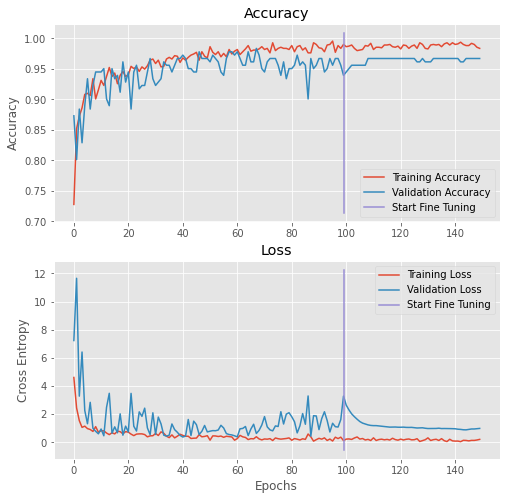

In [34]:
acc += train_history.history['accuracy']
val_acc += train_history.history['val_accuracy']

loss += train_history.history['loss']
val_loss += train_history.history['val_loss']

fig = plt.figure(figsize=(8, 8))
fig.patch.set_alpha(0.5)

plt.subplot(2, 1, 1)
plt.plot(acc)
plt.plot(val_acc)
plt.plot([init_epochs - 1, init_epochs - 1], plt.ylim())
plt.legend(['Training Accuracy', 'Validation Accuracy', 'Start Fine Tuning'],
           loc='lower right')
plt.ylabel('Accuracy')
plt.title('Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss)
plt.plot(val_loss)
plt.plot([init_epochs - 1, init_epochs - 1], plt.ylim())
plt.legend(['Training Loss', 'Validation Loss', 'Start Fine Tuning'],
           loc='upper right')
plt.ylabel('Cross Entropy')
plt.xlabel('Epochs')
plt.title('Loss')
plt.savefig(path + "/training_plot2.pdf")
plt.show()

In [35]:
new_model.evaluate(test_ds)

1/5 [=====>........................] - ETA: 0s - loss: 2.8078 - accuracy: 0.9375

2/5 [===========>..................] - ETA: 2s - loss: 2.6921 - accuracy: 0.9414

3/5 [=================>............] - ETA: 2s - loss: 1.7947 - accuracy: 0.9609

4/5 [=======================>......] - ETA: 1s - loss: 1.3461 - accuracy: 0.9707

5/5 [==============================] - ETA: 0s - loss: 1.3383 - accuracy: 0.9706

5/5 [==============================] - 6s 1s/step - loss: 1.3383 - accuracy: 0.9706


[1.3382691144943237, 0.9706422090530396]

In [36]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report

y_true, y_pred = [], []
for images, labels in test_ds:
    preds = new_model.predict(images)
    y_true.append(labels.numpy())
    y_pred.append(preds)

y_true, y_pred = np.concatenate(y_true), np.concatenate(y_pred)
y_probas = y_pred
y_true, y_pred = np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1)
print('Accuracy: ', accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred))

Accuracy:  0.9706422018348624
              precision    recall  f1-score   support

           0       0.98      0.92      0.95       158
           1       0.97      0.99      0.98       387

    accuracy                           0.97       545
   macro avg       0.97      0.95      0.96       545
weighted avg       0.97      0.97      0.97       545



In [37]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from scikitplot.metrics import plot_confusion_matrix, plot_roc

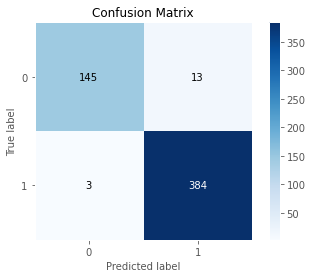

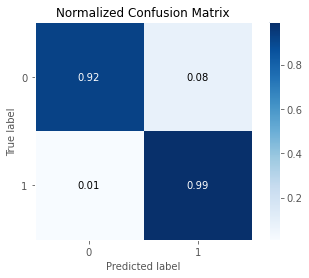

In [38]:
plot_confusion_matrix(y_true, y_pred)
plot_confusion_matrix(y_true, y_pred, normalize=True)

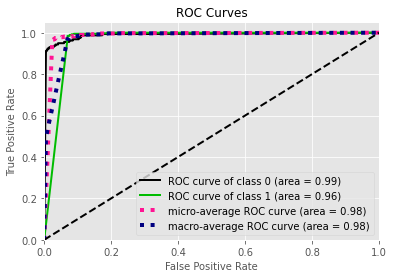

In [39]:
plot_roc(y_true, y_probas)

In [40]:
from imblearn.metrics import classification_report_imbalanced

Using TensorFlow backend.


In [41]:
print(classification_report(y_true, y_pred))
print(classification_report_imbalanced(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.92      0.95       158
           1       0.97      0.99      0.98       387

    accuracy                           0.97       545
   macro avg       0.97      0.95      0.96       545
weighted avg       0.97      0.97      0.97       545

                   pre       rec       spe        f1       geo       iba       sup

          0       0.98      0.92      0.99      0.95      0.95      0.90       158
          1       0.97      0.99      0.92      0.98      0.95      0.92       387

avg / total       0.97      0.97      0.94      0.97      0.95      0.91       545

